In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import warnings
import psycopg2

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from scipy.stats import norm, chi2_contingency
from datetime import datetime
import pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.linear_model import ElasticNet, Ridge

from scipy import stats
from scipy.stats import norm

from catboost import CatBoostClassifier, CatBoostRegressor
from collections import defaultdict
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import umap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

In [14]:
def get_data_new_query(query):
    data = pd.DataFrame()
    try:
        connection = psycopg2.connect(dbname='dwh'
                                      , host='dwh.skyeng.link'
                                      , port='15439'
                                      , user=''
                                      , password='')
        data = pd.read_sql_query(query, connection)
    except psycopg2.OperationalError as e:
        print(e)
    return data

# Metrics

In [18]:
min_date = '2020-04-29'
max_date = '2020-07-15'

d = dict()
d['ice_disconnected_count'] = dict()
d['ice_disconnected_count']['comment'] = 'количество дисконнектов ICE (протокол, который требует использования серверов STUN, TURN)'
d['ice_disconnected_count']['periods'] = dict()
d['ice_disconnected_count']['periods']['1'] = dict()
d['ice_disconnected_count']['periods']['1']['start'] = min_date
d['ice_disconnected_count']['periods']['1']['end'] = max_date

d['web_rtc_down_count'] = dict()
d['web_rtc_down_count']['comment'] = 'количество падений WebRTC'
d['web_rtc_down_count']['periods'] = dict()
d['web_rtc_down_count']['periods']['1'] = dict()
d['web_rtc_down_count']['periods']['1']['start'] = min_date
d['web_rtc_down_count']['periods']['1']['end'] = max_date

d['video_state_down'] = dict()
d['video_state_down']['comment'] = ''
d['video_state_down']['periods'] = dict()
d['video_state_down']['periods']['1'] = dict()
d['video_state_down']['periods']['1']['start'] = min_date
d['video_state_down']['periods']['1']['end'] = max_date

d['total_tech_count'] = dict()
d['total_tech_count']['comment'] = ''
d['total_tech_count']['periods'] = dict()
d['total_tech_count']['periods']['1'] = dict()
d['total_tech_count']['periods']['1']['start'] = min_date
d['total_tech_count']['periods']['1']['end'] = max_date

d['inc_inactive_connection_count'] = dict()
d['inc_inactive_connection_count']['comment'] = ''
d['inc_inactive_connection_count']['periods'] = dict()
d['inc_inactive_connection_count']['periods']['1'] = dict()
d['inc_inactive_connection_count']['periods']['1']['start'] = min_date
d['inc_inactive_connection_count']['periods']['1']['end'] = max_date

d['inc_fps_receiver_duration_share'] = dict()
d['inc_fps_receiver_duration_share']['comment'] = 'доля времени, когда в принимаемом потоке становилось менее 4 кадров в секунду'
d['inc_fps_receiver_duration_share']['periods'] = dict()
d['inc_fps_receiver_duration_share']['periods']['1'] = dict()
d['inc_fps_receiver_duration_share']['periods']['1']['start'] = min_date
d['inc_fps_receiver_duration_share']['periods']['1']['end'] = max_date

d['inc_fps_sender_duration_share'] = dict() 
d['inc_fps_sender_duration_share']['comment'] = 'доля времени, когда в отправляемом потоке становилось менее 4 кадров в секунду'
d['inc_fps_sender_duration_share']['periods'] = dict()
d['inc_fps_sender_duration_share']['periods']['1'] = dict()
d['inc_fps_sender_duration_share']['periods']['1']['start'] = min_date
d['inc_fps_sender_duration_share']['periods']['1']['end'] = max_date

d['inc_lag_audio_video_receiver_duration_share'] = dict() 
d['inc_lag_audio_video_receiver_duration_share']['comment'] = 'доля времени, когда в принимаемом потоке возникал рассинхрон между аудио и видео больше 1 секунды'
d['inc_lag_audio_video_receiver_duration_share']['periods'] = dict()
d['inc_lag_audio_video_receiver_duration_share']['periods']['1'] = dict()
d['inc_lag_audio_video_receiver_duration_share']['periods']['1']['start'] = min_date
d['inc_lag_audio_video_receiver_duration_share']['periods']['1']['end'] = max_date#'2020-05-18'

d['inc_qp_receiver_duration_share'] = dict()
d['inc_qp_receiver_duration_share']['comment'] = 'доля времени, когда в принимаемом потоке была пережатая картинка (квадраты и т.п.)'
d['inc_qp_receiver_duration_share']['periods'] = dict()
d['inc_qp_receiver_duration_share']['periods']['1'] = dict()
d['inc_qp_receiver_duration_share']['periods']['1']['start'] = min_date
d['inc_qp_receiver_duration_share']['periods']['1']['end'] = max_date

d['inc_resolution_receiver_duration_share'] = dict() 
d['inc_resolution_receiver_duration_share']['comment'] = 'доля времени, когда в принимаемом потоке была пережатая картинка (квадраты и т.п.)'
d['inc_resolution_receiver_duration_share']['periods'] = dict()
d['inc_resolution_receiver_duration_share']['periods']['1'] = dict()
d['inc_resolution_receiver_duration_share']['periods']['1']['start'] = min_date
d['inc_resolution_receiver_duration_share']['periods']['1']['end'] = max_date#'2020-05-18'

d['inc_rtt_receiver_duration_share'] = dict()
d['inc_rtt_receiver_duration_share']['comment'] = 'доля времени, когда в принимаемом потоке был слишком большой пинг до сервера'
d['inc_rtt_receiver_duration_share']['periods'] = dict()
d['inc_rtt_receiver_duration_share']['periods']['1'] = dict()
d['inc_rtt_receiver_duration_share']['periods']['1']['start'] = min_date
d['inc_rtt_receiver_duration_share']['periods']['1']['end'] = max_date

d['inc_rtt_sender_duration_share'] = dict()
d['inc_rtt_sender_duration_share']['comment'] = 'доля времени, когда в отправляемом потоке был слишком большой пинг до сервера'
d['inc_rtt_sender_duration_share']['periods'] = dict()
d['inc_rtt_sender_duration_share']['periods']['1'] = dict()
d['inc_rtt_sender_duration_share']['periods']['1']['start'] = min_date
d['inc_rtt_sender_duration_share']['periods']['1']['end'] = max_date

d['inc_video_bitrate_10_receiver_duration_share'] = dict()
d['inc_video_bitrate_10_receiver_duration_share']['comment'] = 'доля времени, когда в принимаемом потоке был битрэйт ниже 10кбит'
d['inc_video_bitrate_10_receiver_duration_share']['periods'] = dict()
d['inc_video_bitrate_10_receiver_duration_share']['periods']['1'] = dict()
d['inc_video_bitrate_10_receiver_duration_share']['periods']['1']['start'] = min_date
d['inc_video_bitrate_10_receiver_duration_share']['periods']['1']['end'] = max_date
d['inc_video_bitrate_10_receiver_duration_share']['lower'] = 0
d['inc_video_bitrate_10_receiver_duration_share']['upper'] = 100

d['inc_video_bitrate_25_receiver_duration_share'] = dict()
d['inc_video_bitrate_25_receiver_duration_share']['comment'] = 'доля времени, когда в принимаемом потоке был битрэйт ниже 25кбит'
d['inc_video_bitrate_25_receiver_duration_share']['periods'] = dict()
d['inc_video_bitrate_25_receiver_duration_share']['periods']['1'] = dict()
d['inc_video_bitrate_25_receiver_duration_share']['periods']['1']['start'] = min_date
d['inc_video_bitrate_25_receiver_duration_share']['periods']['1']['end'] = max_date
d['inc_video_bitrate_25_receiver_duration_share']['lower'] = 0
d['inc_video_bitrate_25_receiver_duration_share']['upper'] = 100

d['inc_video_bitrate_6_sender_duration_share'] = dict()
d['inc_video_bitrate_6_sender_duration_share']['comment'] = 'доля времени, когда в принимаемом потоке был битрэйт ниже 6кбит'
d['inc_video_bitrate_6_sender_duration_share']['periods'] = dict()
d['inc_video_bitrate_6_sender_duration_share']['periods']['1'] = dict()
d['inc_video_bitrate_6_sender_duration_share']['periods']['1']['start'] = min_date
d['inc_video_bitrate_6_sender_duration_share']['periods']['1']['end'] = max_date
d['inc_video_bitrate_6_sender_duration_share']['lower'] = 0
d['inc_video_bitrate_6_sender_duration_share']['upper'] = 100


In [19]:
def plot_in_time(metric, d):
    q = '''
    SELECT
        al.start_at,
        al.metric AS avg_all,
        nz.metric AS avg_non_zero,
        al.role
    FROM
    (
        SELECT 
            TRUNC(start_at) as start_at,
            AVG({0}::float) AS metric,
            role
        FROM report.video_quality_metric_first_packet_dataset
        {1}
        GROUP BY TRUNC(start_at), role
    ) AS al
    LEFT JOIN
    (
        SELECT 
            TRUNC(start_at) as start_at,
            AVG({0}::float) AS metric,
            role
        FROM report.video_quality_metric_first_packet_dataset
        WHERE {0}::float > 0
        {2}
        GROUP BY TRUNC(start_at), role
    ) AS nz
        ON al.start_at = nz.start_at AND al.role = nz.role
    WHERE al.start_at > '2020-04-29'
    ORDER BY al.start_at
    '''
    
    borders_all = ''
    borders_non_zero = ''
    
    if 'lower' in list(d[metric].keys()):
        borders_all = 'WHERE {0}::float >= {1}'.format(metric, d[metric]['lower'])
        borders_non_zero = 'AND {0}::float >= {1}'.format(metric, d[metric]['lower'])
    
    if 'upper' in list(d[metric].keys()):
        b = '{0}::float <= {1}'.format(metric, d[metric]['upper'])
        borders_non_zero = '{0} AND {1}'.format(borders_non_zero, b)
        borders_all = 'WHERE {1}'.format(b) if borders_all == '' else '{0} AND {1}'.format(borders_all, b)
        
    q = q.format(metric, borders_all, borders_non_zero)
    
    d = get_data_new_query(q)
    
    plotly.offline.iplot({
    "data": [go.Scatter(x=d.loc[d['role'] == 'student']['start_at']
                        , y=d.loc[d['role'] == 'student']['avg_all']
                        , mode = 'lines'
                        , name = 'Average All Students'
                       , line=dict(color='darkblue')),
             go.Scatter(x=d.loc[d['role'] == 'student']['start_at']
                        , y=d.loc[d['role'] == 'student']['avg_non_zero']
                        , mode = 'lines'
                        , name = 'Average non zero Students'
                       , line=dict(color='cornflowerblue')),
             go.Scatter(x=d.loc[d['role'] == 'teacher']['start_at']
                        , y=d.loc[d['role'] == 'teacher']['avg_all']
                        , mode = 'lines'
                        , name = 'Average All Teachers'
                       , line=dict(color='red')),
             go.Scatter(x=d.loc[d['role'] == 'teacher']['start_at']
                        , y=d.loc[d['role'] == 'teacher']['avg_non_zero']
                        , mode = 'lines'
                        , name = 'Average non zero Teachers'
                       , line=dict(color='salmon'))
            ],
    "layout": go.Layout(title=metric)})


def count_non_zero_in_time(metric, d):
    q = '''
    SELECT
        al.start_at,
        al.metric AS count_all,
        nz.metric AS count_non_zero,
        al.role
    FROM
    (
        SELECT 
            TRUNC(start_at) as start_at,
            COUNT(*) AS metric,
            role
        FROM report.video_quality_metric_first_packet_dataset 
        {1}
        GROUP BY TRUNC(start_at), role
    ) AS al
    LEFT JOIN
    (
        SELECT 
            TRUNC(start_at) as start_at,
            COUNT(*) AS metric,
            role
        FROM report.video_quality_metric_first_packet_dataset
        WHERE {0}::float > 0 {2}
        GROUP BY TRUNC(start_at), role
    ) AS nz
        ON al.start_at = nz.start_at
    WHERE al.start_at > '2020-04-29'
    ORDER BY al.start_at
    '''
    
    borders_all = ''
    borders_non_zero = ''
    
    if 'lower' in list(d[metric].keys()):
        borders_all = 'WHERE {0}::float >= {1}'.format(metric, d[metric]['lower'])
        borders_non_zero = 'AND {0}::float >= {1}'.format(metric, d[metric]['lower'])
    
    if 'upper' in list(d[metric].keys()):
        b = '{0}::float <= {1}'.format(metric, d[metric]['upper'])
        borders_all = ('WHERE {0}'.format(b) if borders_all == '' else '{0} AND {1}'.format(borders_all, b))
        borders_non_zero = '{0} AND {1}'.format(borders_non_zero, b)
        
    q = q.format(metric, borders_all, borders_non_zero)
    
    d = get_data_new_query(q)
    
    plotly.offline.iplot({
    "data": [go.Scatter(x=d.loc[d['role'] == 'student']['start_at']
                        , y=d.loc[d['role'] == 'student']['count_all']
                        , mode = 'lines'
                        , name = 'Count All Students'
                       , line=dict(color='violet')),
             go.Scatter(x=d.loc[d['role'] == 'student']['start_at']
                        , y=d.loc[d['role'] == 'student']['count_non_zero']
                        , mode = 'lines'
                        , name = 'Count non zero Students'
                       , line=dict(color='pink')),
             go.Scatter(x=d.loc[d['role'] == 'teacher']['start_at']
                        , y=d.loc[d['role'] == 'teacher']['count_all']
                        , mode = 'lines'
                        , name = 'Count All Teachers'
                       , line=dict(color='brown')),
             go.Scatter(x=d.loc[d['role'] == 'teacher']['start_at']
                        , y=d.loc[d['role'] == 'teacher']['count_non_zero']
                        , mode = 'lines'
                        , name = 'Count non zero Teachers'
                       , line=dict(color='orange'))
            ],
    "layout": go.Layout(title=metric)})

        
def get_limitations(metric, d):
    limitations = "WHERE ((TRUNC(start_at) >= '{0}' AND TRUNC(start_at) <= '{1}')".format(d[metric]['periods']['1']['start'],
                                                                                         d[metric]['periods']['1']['end'])

    if len(d[metric]['periods'].keys()) > 1:
        for key in set(d[metric]['periods'].keys()) - set(['1']):
            limitations = "{0} OR (TRUNC(start_at) >= '{1}' AND TRUNC(start_at) <= '{2}')".format(limitations, 
                                                                                                  d[metric]['periods'][key]['start'],
                                                                                                  d[metric]['periods'][key]['end'])
    
    limitations = '{0})'.format(limitations)
    
    return limitations


def get_limitations_ext(metric, d):
    limitations = "WHERE ((TRUNC(start_at) >= '{0}' AND TRUNC(start_at) <= '{1}')".format(d[metric]['periods']['1']['start'],
                                                                                         d[metric]['periods']['1']['end'])

    if len(d[metric]['periods'].keys()) > 1:
        for key in set(d[metric]['periods'].keys()) - set(['1']):
            limitations = "{0} OR (TRUNC(start_at) >= '{1}' AND TRUNC(start_at) <= '{2}')".format(limitations, 
                                                                                                  d[metric]['periods'][key]['start'],
                                                                                                  d[metric]['periods'][key]['end'])
    
    limitations = '{0})'.format(limitations)
    
    limitations = '{0} AND {1}::float >= {2}'.format(limitations, metric, d[metric]['lower'])
    limitations = '{0} AND {1}::float <= {2}'.format(limitations, metric, d[metric]['upper'])
    
    return limitations


def get_select(metric, d):
    
    q = '''
    LEFT JOIN
    (
        SELECT
            s.class_id,
            s.{1}_is_nan,
            s.{1}_student,
            t.{1}_teacher
        FROM
        (
            SELECT 
                class_id,
                CASE
                    WHEN {0} THEN 0
                    ELSE 1
                END AS {1}_is_nan,
                CASE
                    WHEN {1}::float <= 0 THEN 0
                    WHEN {1}::float > 0 AND {1}::float <= {2} THEN 1
                    WHEN {1}::float > {2} THEN 3
                END AS {1}_student
            FROM report.video_quality_metric_first_packet_dataset
            WHERE start_at > '2020-04-29'
            AND role = 'student'
            AND rooms_count_in_room = 1
        ) AS s
        LEFT JOIN
        (
            SELECT 
                class_id,
                CASE
                    WHEN {1}::float <= 0 THEN 0
                    WHEN {1}::float > 0 AND {1}::float <= {3} THEN 1
                    WHEN {1}::float > {3} THEN 3
                END AS {1}_teacher
            FROM report.video_quality_metric_first_packet_dataset
            WHERE start_at > '2020-04-29'
            AND role = 'teacher'
            AND rooms_count_in_room = 1
        ) AS t
        ON s.class_id = t.class_id
    ) AS {1}
    ON video_mark.class_id = {1}.class_id
    '''
    
    limitations = "(start_at::datetime >= '{0}' AND start_at::datetime <= '{1}')".format(d[metric]['periods']['1']['start'],
                                                                                          d[metric]['periods']['1']['end'])
    
    q = q.format(limitations, metric, d[metric]['threshold']['student'], d[metric]['threshold']['teacher'])
    
    return q


def get_select_raw(metric, d):
    
    q = '''
    LEFT JOIN
    (
        SELECT
            s.class_id,
            s.{1}_is_nan,
            s.{1}_student,
            t.{1}_teacher
        FROM
        (
            SELECT 
                class_id,
                CASE
                    WHEN {0} THEN 0
                    ELSE 1
                END AS {1}_is_nan,
                CASE
                    WHEN {1}::float <= 0 THEN 0
                    ELSE {1}::float
                END AS {1}_student
            FROM report.video_quality_metric_first_packet_dataset
            WHERE start_at > '2020-04-29'
            AND role = 'student'
            AND rooms_count_in_room = 1
        ) AS s
        LEFT JOIN
        (
            SELECT 
                class_id,
                CASE
                    WHEN {1}::float <= 0 THEN 0
                    ELSE {1}::float
                END AS {1}_teacher
            FROM report.video_quality_metric_first_packet_dataset
            WHERE start_at > '2020-04-29'
            AND role = 'teacher'
            AND rooms_count_in_room = 1
        ) AS t
        ON s.class_id = t.class_id
    ) AS {1}
    ON video_mark.class_id = {1}.class_id
    '''
    
    limitations = "(start_at::datetime >= '{0}' AND start_at::datetime <= '{1}')".format(d[metric]['periods']['1']['start'],
                                                                                          d[metric]['periods']['1']['end'])
    
    q = q.format(limitations, metric)
    
    return q

    
def load_data_first(metric, d, n = 10000):
    q = '''
    SELECT
        {0}::float AS value,
        video_mark::int,
        role
    FROM report.video_quality_metric_first_packet_dataset
    {1}
    AND rooms_count_in_room = 1
    AND {0} NOT LIKE '%scott%'
    AND video_mark IS NOT NULL
--    ORDER BY RANDOM()
--    LIMIT {2}
    '''
    
    limitations = get_limitations(metric, d)
    
    q = q.format(metric, limitations, n)
    
    d = get_data_new_query(q)
    
    with open('{0}.pkl'.format(metric), 'wb') as file:
        pickle.dump(d, file)
    

def plot_in_time_limited(metric, d):
    
    limitations = get_limitations_ext(metric, d)
    
    q = '''
    SELECT
        al.start_at,
        al.metric AS avg_all,
        nz.metric AS avg_non_zero,
        al.role
    FROM
    (
        SELECT 
            TRUNC(start_at) as start_at,
            AVG({0}::float) AS metric,
            role
        FROM report.video_quality_metric_first_packet_dataset
        {1}
        GROUP BY TRUNC(start_at), role
    ) AS al
    LEFT JOIN
    (
        SELECT 
            TRUNC(start_at) as start_at,
            AVG({0}::float) AS metric,
            role
        FROM report.video_quality_metric_first_packet_dataset
        {1}
        AND {0}::float > 0
        GROUP BY TRUNC(start_at), role
    ) AS nz
        ON al.start_at = nz.start_at
    ORDER BY al.start_at
    '''
    
    q = q.format(metric, limitations)
    
    d = get_data_new_query(q)
    
    plotly.offline.iplot({
    "data": [go.Scatter(x=d.loc[d['role'] == 'student']['start_at']
                        , y=d.loc[d['role'] == 'student']['avg_all']
                        , mode = 'lines'
                        , name = 'Average All Students'
                       , line=dict(color='green')),
             go.Scatter(x=d.loc[d['role'] == 'student']['start_at']
                        , y=d.loc[d['role'] == 'student']['avg_non_zero']
                        , mode = 'lines'
                        , name = 'Average non zero Students'
                       , line=dict(color='lightgreen')),
             go.Scatter(x=d.loc[d['role'] == 'teacher']['start_at']
                        , y=d.loc[d['role'] == 'teacher']['avg_all']
                        , mode = 'lines'
                        , name = 'Average All Teacher'
                       , line=dict(color='violet')),
             go.Scatter(x=d.loc[d['role'] == 'teacher']['start_at']
                        , y=d.loc[d['role'] == 'teacher']['avg_non_zero']
                        , mode = 'lines'
                        , name = 'Average non zero Teachers'
                       , line=dict(color='pink'))
            ],
    "layout": go.Layout(title=metric)})
    
    
def get_borders(df, d, metric):
    
    q1, q3 = np.quantile(df.loc[df['value'] > 0]['value'], [0.005, 0.995])#[0.25, 0.75])
    #lb = q1 - 1.5*(q3 - q1)
    #ub = q3 + 1.5*(q3 - q1)
    lb = 0
    ub = q3
    
    d[metric]['lower'] = lb
    d[metric]['upper'] = ub
    
    print([lb, ub])
    
    return d

def chi2_test(df):
    c1_0_zero = len(df.loc[(df['is_c1'] == 0) & (df['value'] == 0)])
    c1_0_not_zero = len(df.loc[(df['is_c1'] == 0) & (df['value'] > 0)])
    c1_1_zero = len(df.loc[(df['is_c1'] == 1) & (df['value'] == 0)])
    c1_1_not_zero = len(df.loc[(df['is_c1'] == 1) & (df['value'] > 0)])

    if ((c1_0_zero > 0) & (c1_0_not_zero > 0) & (c1_1_zero > 0) & (c1_1_not_zero > 0)):
        chi_pvalue = chi2_contingency(np.array([[c1_0_zero, c1_0_not_zero],
                                                [c1_1_zero, c1_1_not_zero]]))[1]
        print("Chi2 p-value = {0}. !{1}!".format(chi_pvalue, 
                                                'Dependent' if chi_pvalue <= 0.05 else 'Independent'))
    else:
        print('Cant calc zero-nonzero independency test')

    
def metric_analysis(metric, d):
    print('------------------------------', metric.upper(), '-------------------------------')
    
    print('Изменение среднего по времени для метрики {0} ({1})'.format(metric, d[metric]['comment']))
    plot_in_time(metric, d)

    print('Изменение количества записей по времени для метрики {0} ({1})'.format(metric, d[metric]['comment']))
    count_non_zero_in_time(metric, d)
        
    load_data_first(metric, d, n = 100000) 
    
    with open('{0}.pkl'.format(metric), 'rb') as file:
        df = pickle.load(file)
 
    print('boxplot для {0} > 0'.format(metric))
    plt.figure(figsize = (15, 10))
    sns.boxplot(data = df.loc[df['value'] > 0], x = 'role', y = 'value')
    plt.show()
    
    print('Границы для выбросов:')
    d = get_borders(df, d, metric)
    df = df.loc[(df['value'] >= d[metric]['lower']) & (df['value'] <= d[metric]['upper'])]
    
    print('boxplot после чистки выбросов для {0} > 0'.format(metric))
    plt.figure(figsize = (15, 10))
    sns.boxplot(data = df.loc[df['value'] > 0], x = 'role', y = 'value')
    plt.show()
    
    print('boxplot после чистки выбросов для студентов для {0} > 0'.format(metric))
    plt.figure(figsize = (15, 10))
    sns.boxplot(data = df.loc[(df['value'] > 0) & (df['role'] == 'student')], x = 'video_mark', y = 'value')
    plt.show()

    print('boxplot после чистки выбросов для учителей для {0} > 0'.format(metric))
    plt.figure(figsize = (15, 10))
    sns.boxplot(data = df.loc[(df['value'] > 0) & (df['role'] == 'teacher')], x = 'video_mark', y = 'value')
    plt.show()
    
    print('Гистограмма после чистки выбросов для {0} > 0'.format(metric))
    plt.figure(figsize = (15, 10))
    sns.distplot(df.loc[(df['value'] > 0) & (df['role'] == 'student')]['value'], label = 'student')
    sns.distplot(df.loc[(df['value'] > 0) & (df['role'] == 'teacher')]['value'], label = 'teacher')
    plt.legend()
    plt.show()
    
    print('Изменение среднего по времени после чистки выбросов и учета только нужных периодов')
    plot_in_time_limited(metric, d)
    
    print('')
        
    print('Гистограмма для студентов для {0} > 0'.format(metric))
    plt.figure(figsize = (15, 10))
    sns.distplot(df.loc[(df['video_mark'] == 1) & (df['value'] > 0) & (df['role'] == 'student')]['value'], 
                 label = 'mark = 1', kde = False)
    sns.distplot(df.loc[(df['video_mark'] == 2) & (df['value'] > 0) & (df['role'] == 'student')]['value'], 
                 label = 'mark = 2', kde = False)
    sns.distplot(df.loc[(df['video_mark'] == 3) & (df['value'] > 0) & (df['role'] == 'student')]['value'], 
                 label = 'mark = 3', kde = False)
    sns.distplot(df.loc[(df['video_mark'] == 4) & (df['value'] > 0) & (df['role'] == 'student')]['value'], 
                 label = 'mark = 4', kde = False)
    sns.distplot(df.loc[(df['video_mark'] == 5) & (df['value'] > 0) & (df['role'] == 'student')]['value'], 
                 label = 'mark = 5', kde = False)

    plt.legend()
    plt.show()

    print('Гистограмма для учителей для {0} > 0'.format(metric))
    plt.figure(figsize = (15, 10))
    sns.distplot(df.loc[(df['video_mark'] == 1) & (df['value'] > 0) & (df['role'] == 'teacher')]['value'], 
                 label = 'mark = 1', kde = False)
    sns.distplot(df.loc[(df['video_mark'] == 2) & (df['value'] > 0) & (df['role'] == 'teacher')]['value'], 
                 label = 'mark = 2', kde = False)
    sns.distplot(df.loc[(df['video_mark'] == 3) & (df['value'] > 0) & (df['role'] == 'teacher')]['value'], 
                 label = 'mark = 3', kde = False)
    sns.distplot(df.loc[(df['video_mark'] == 4) & (df['value'] > 0) & (df['role'] == 'teacher')]['value'], 
                 label = 'mark = 4', kde = False)
    sns.distplot(df.loc[(df['video_mark'] == 5) & (df['value'] > 0) & (df['role'] == 'teacher')]['value'], 
                 label = 'mark = 5', kde = False)

    plt.legend()
    plt.show()

    print('')
    print('')
    
def report(x_train, x_test, y_train, y_test, model):
    preds_train = model.predict(x_train)
    preds_train_prob = model.predict_proba(x_train)[:, 1]
    preds_test = model.predict(x_test)
    preds_test_prob = model.predict_proba(x_test)[:, 1]
    
    if (len(np.unique(y_train)) == 2):
        cutoff = find_optimal_cutoff(y_train, preds_train_prob)[0]
        print(cutoff)
        preds_train_co = pd.Series(preds_train_prob).map(lambda x: 1 if x > cutoff else 0)
        preds_test_co = pd.Series(preds_test_prob).map(lambda x: 1 if x > cutoff else 0)

        print('Train')
        d_train = pd.DataFrame(metrics.classification_report(y_train, preds_train, output_dict = True))
        d_train = d_train.drop(['accuracy', 'macro avg', 'weighted avg'], axis = 1)
        d_train = d_train.transpose()[['precision', 'recall', 'f1-score']]
        
        d_train_co = pd.DataFrame(metrics.classification_report(y_train, preds_train_co, output_dict = True))
        d_train_co = d_train_co.drop(['accuracy', 'macro avg', 'weighted avg'], axis = 1)
        d_train_co = d_train_co.transpose()[['precision', 'recall', 'f1-score']]
        
        print(pd.concat([d_train, d_train_co], axis = 1))

        print('')
        print('Test')
        d_test = pd.DataFrame(metrics.classification_report(y_test, preds_test, output_dict = True))
        d_test = d_test.drop(['accuracy', 'macro avg', 'weighted avg'], axis = 1)
        d_test = d_test.transpose()[['precision', 'recall', 'f1-score']]
        
        d_test_co = pd.DataFrame(metrics.classification_report(y_test, preds_test_co, output_dict = True))
        d_test_co = d_test_co.drop(['accuracy', 'macro avg', 'weighted avg'], axis = 1)
        d_test_co = d_test_co.transpose()[['precision', 'recall', 'f1-score']]

        print(pd.concat([d_test, d_test_co], axis = 1))
    
    else:
        print('Train')
        d_train = pd.DataFrame(metrics.classification_report(y_train, preds_train, output_dict = True))
        d_train = d_train.drop(['accuracy', 'macro avg', 'weighted avg'], axis = 1)
        d_train = d_train.transpose()[['precision', 'recall', 'f1-score']]
        print(d_train)
        
        print('')
        print('Test')
        d_test = pd.DataFrame(metrics.classification_report(y_test, preds_test, output_dict = True))
        d_test = d_test.drop(['accuracy', 'macro avg', 'weighted avg'], axis = 1)
        d_test = d_test.transpose()[['precision', 'recall', 'f1-score']]
        print(d_test)

def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1 - fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


# Feature Analysis

------------------------------ ICE_DISCONNECTED_COUNT -------------------------------
Изменение среднего по времени для метрики ice_disconnected_count (количество дисконнектов ICE (протокол, который требует использования серверов STUN, TURN))


Изменение количества записей по времени для метрики ice_disconnected_count (количество дисконнектов ICE (протокол, который требует использования серверов STUN, TURN))


boxplot для ice_disconnected_count > 0


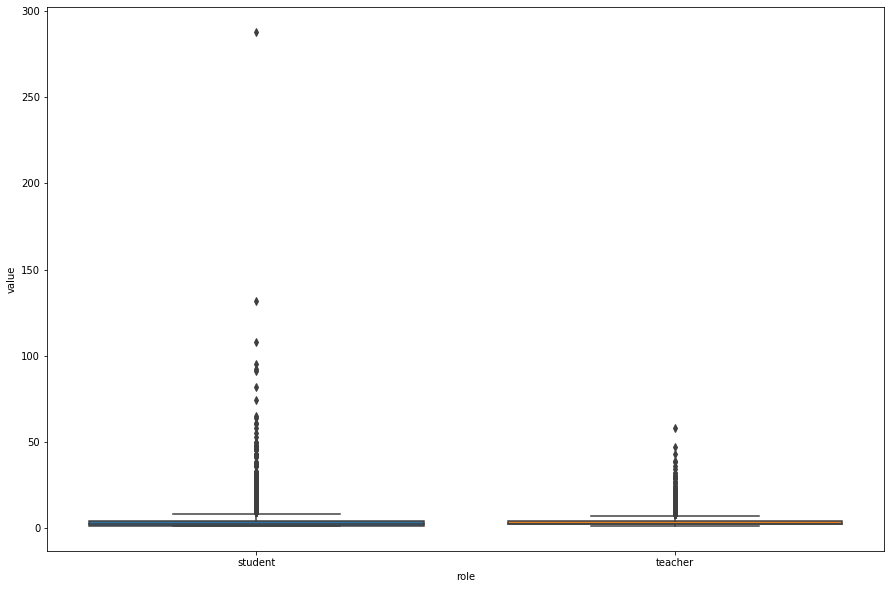

Границы для выбросов:
[0, 36.0]
boxplot после чистки выбросов для ice_disconnected_count > 0


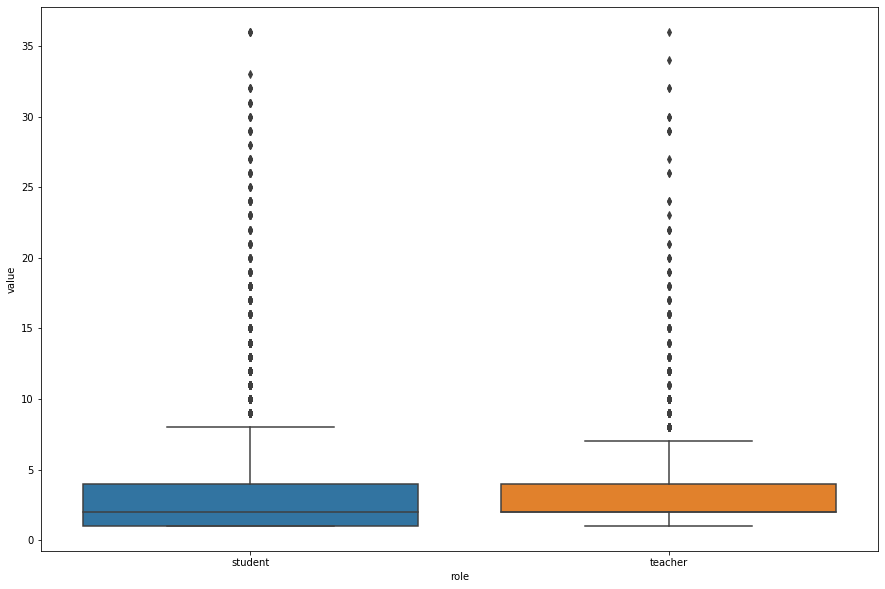

boxplot после чистки выбросов для студентов для ice_disconnected_count > 0


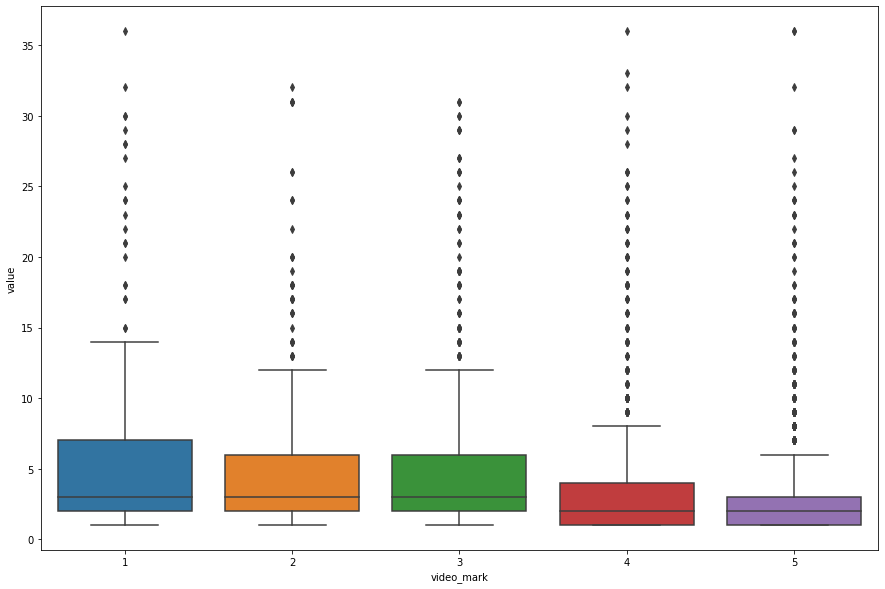

boxplot после чистки выбросов для учителей для ice_disconnected_count > 0


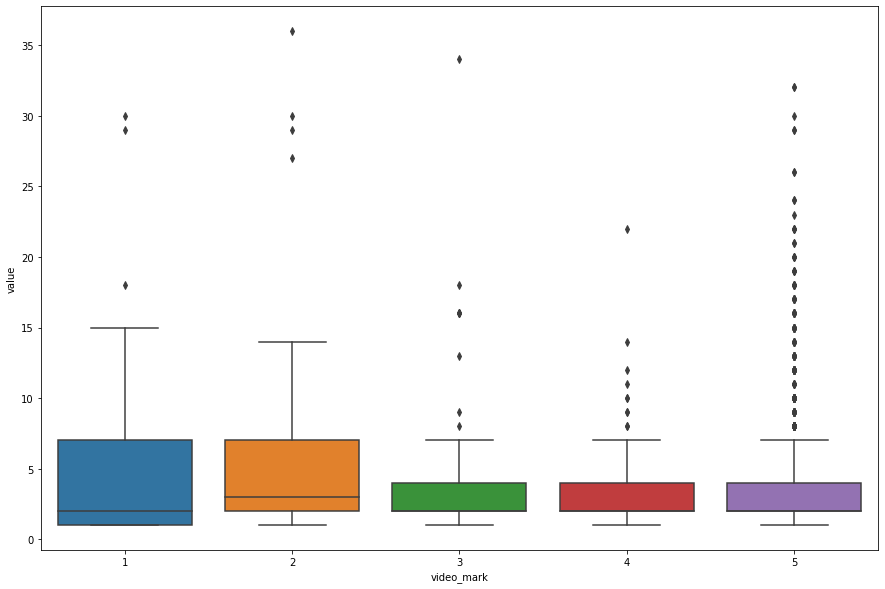

Гистограмма после чистки выбросов для ice_disconnected_count > 0


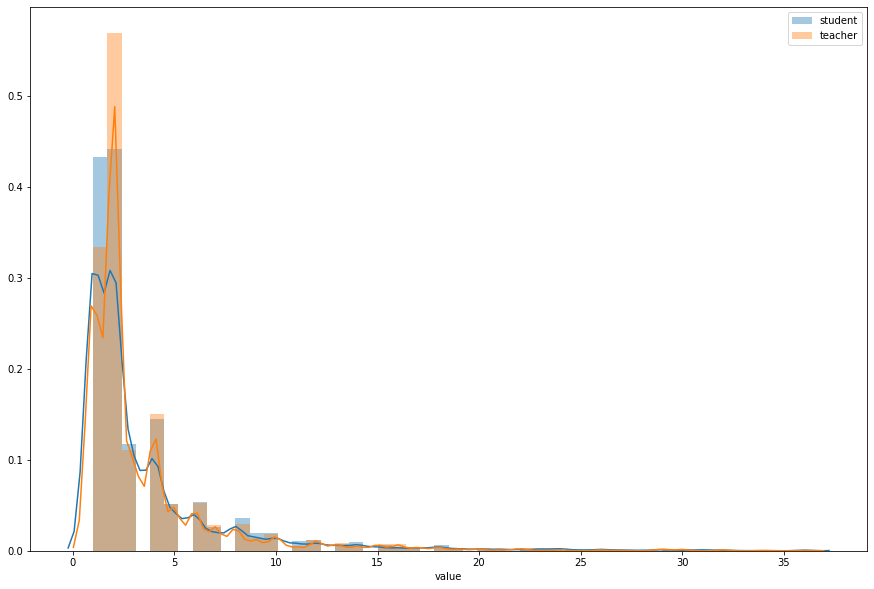

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для ice_disconnected_count > 0


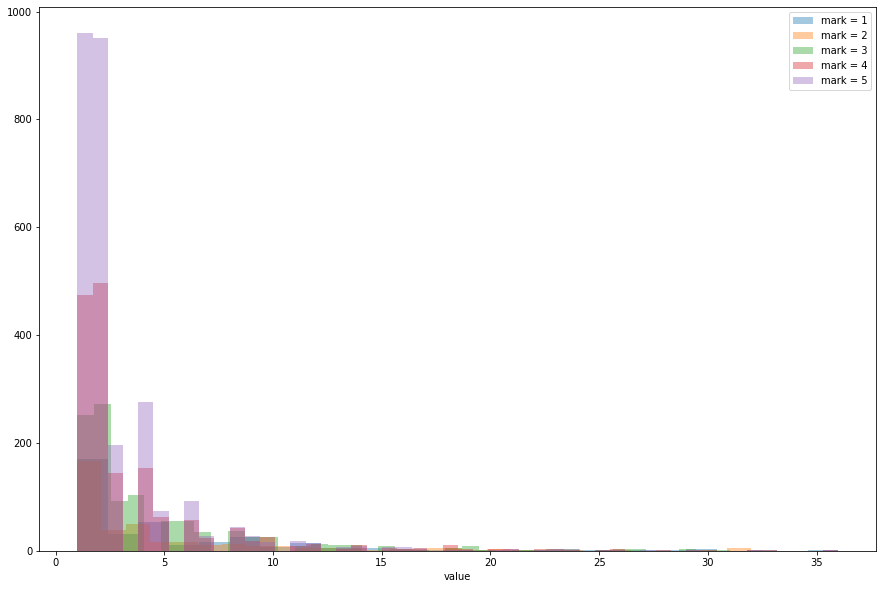

Гистограмма для учителей для ice_disconnected_count > 0


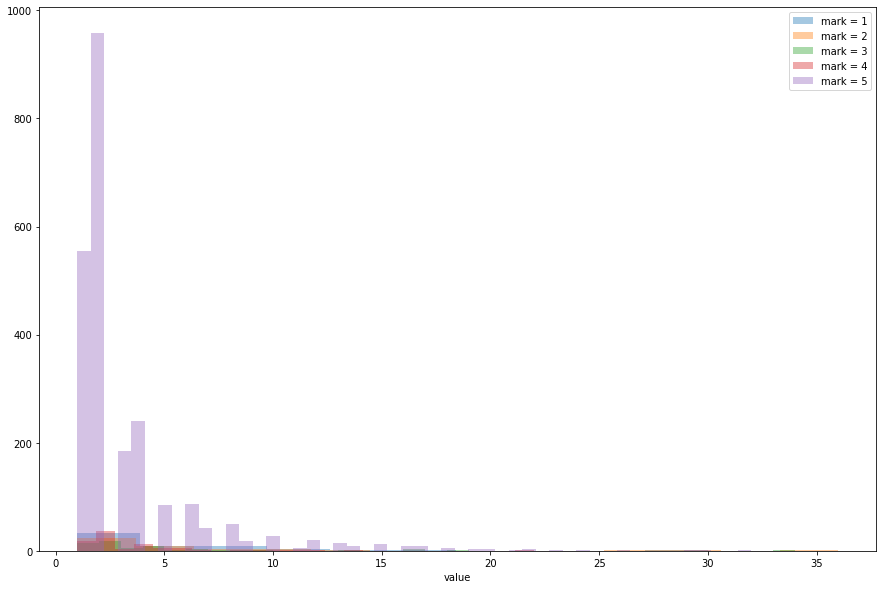



------------------------------ WEB_RTC_DOWN_COUNT -------------------------------
Изменение среднего по времени для метрики web_rtc_down_count (количество падений WebRTC)


Изменение количества записей по времени для метрики web_rtc_down_count (количество падений WebRTC)


boxplot для web_rtc_down_count > 0


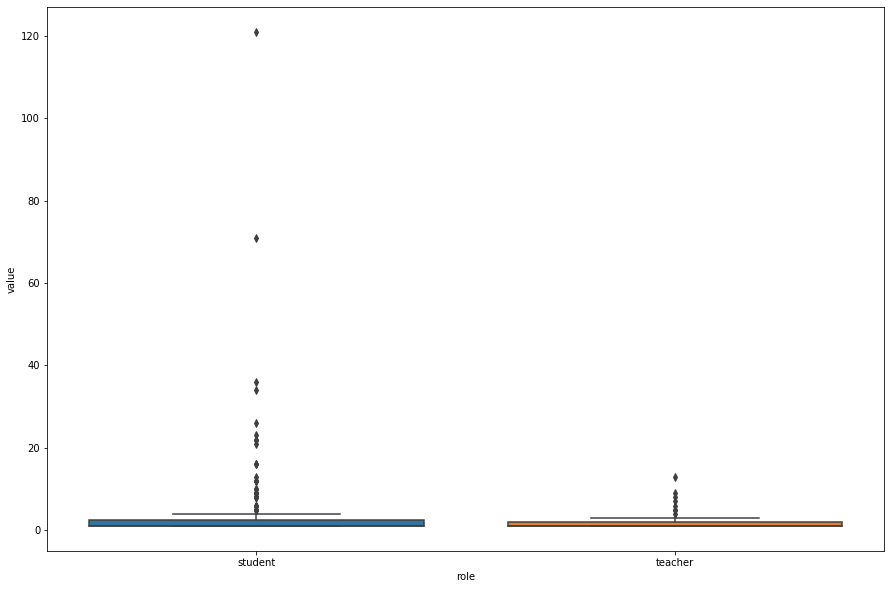

Границы для выбросов:
[0, 54.374999999999204]
boxplot после чистки выбросов для web_rtc_down_count > 0


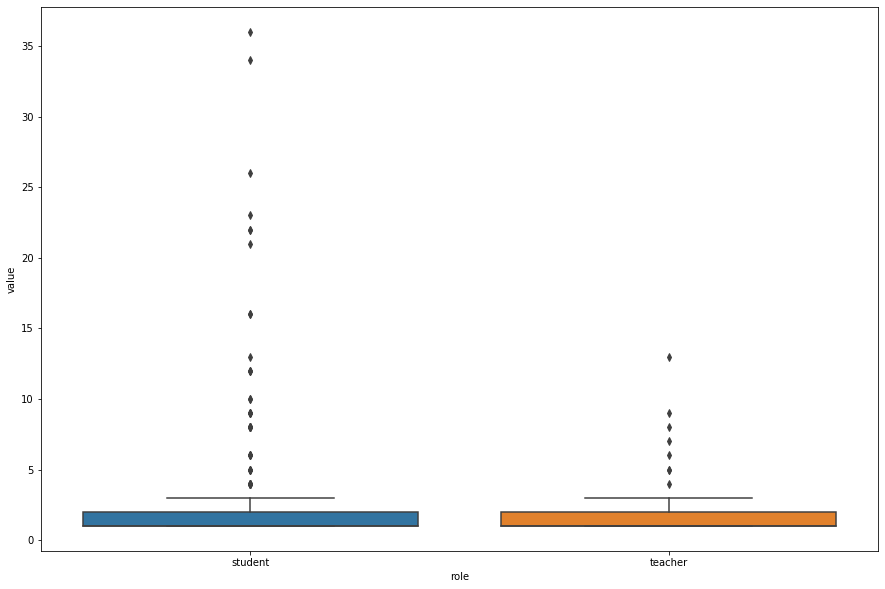

boxplot после чистки выбросов для студентов для web_rtc_down_count > 0


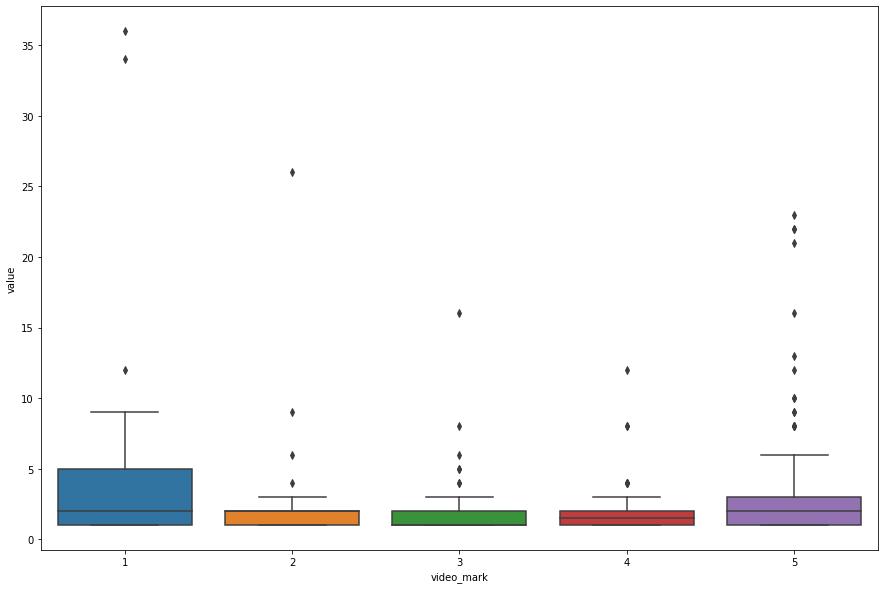

boxplot после чистки выбросов для учителей для web_rtc_down_count > 0


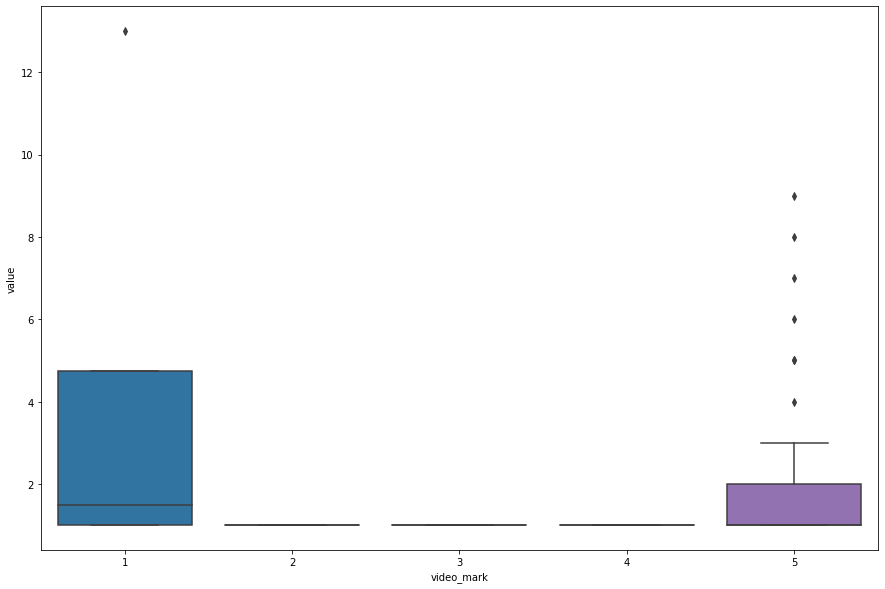

Гистограмма после чистки выбросов для web_rtc_down_count > 0


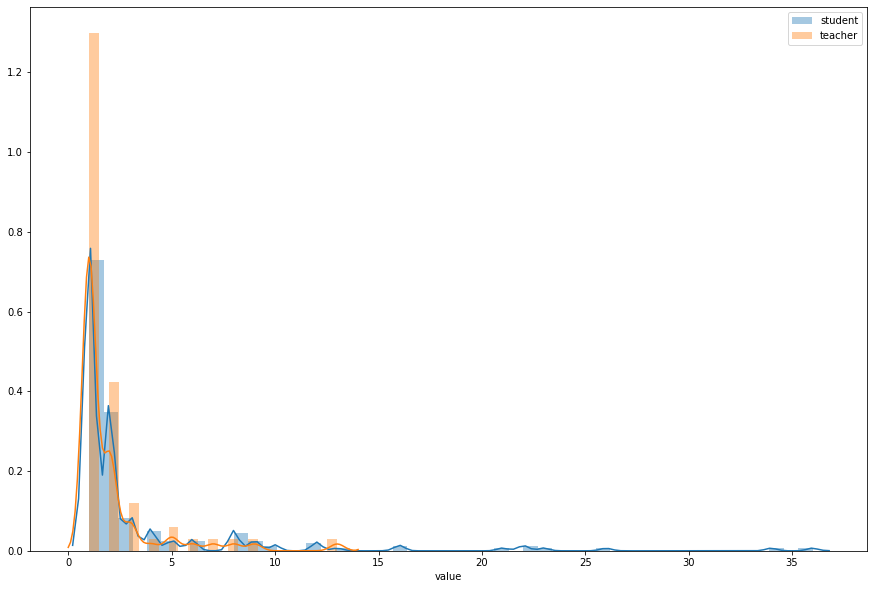

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для web_rtc_down_count > 0


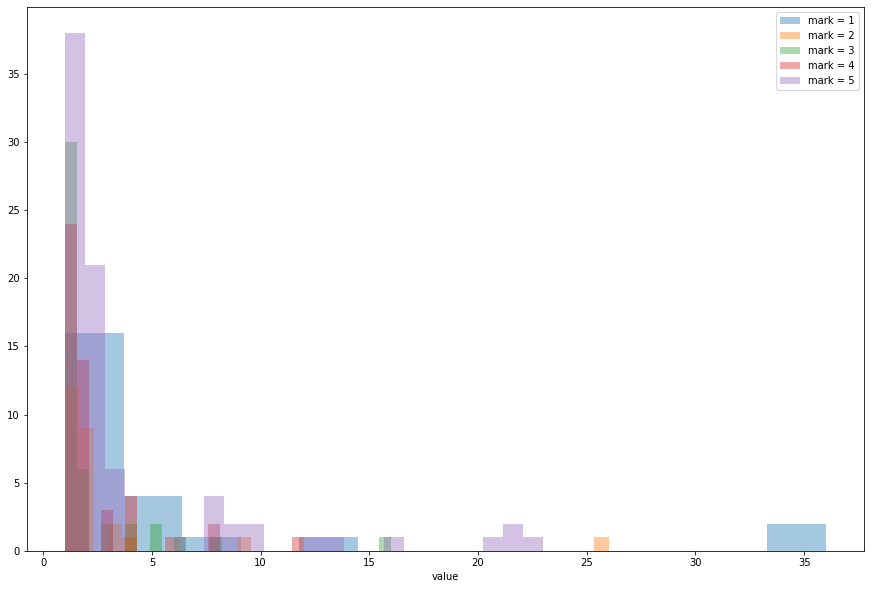

Гистограмма для учителей для web_rtc_down_count > 0


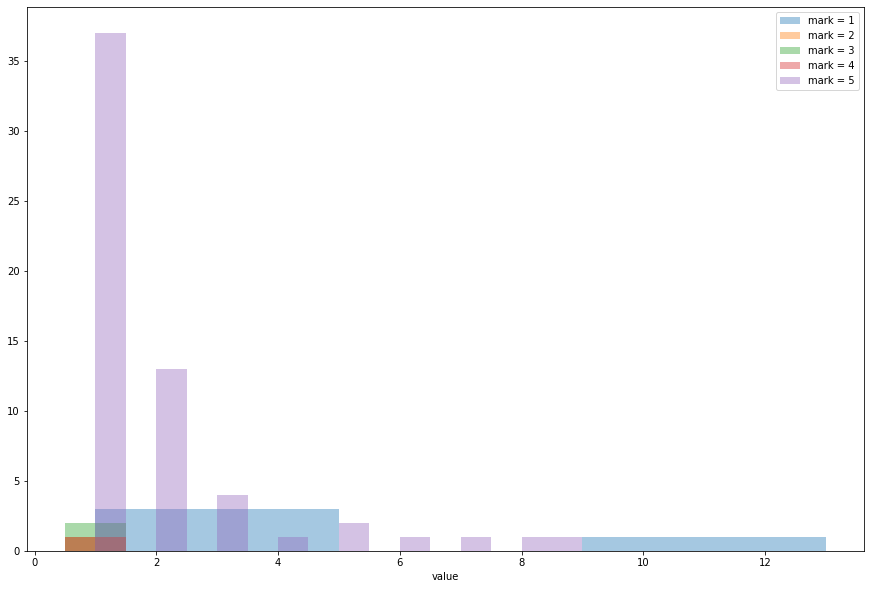



------------------------------ VIDEO_STATE_DOWN -------------------------------
Изменение среднего по времени для метрики video_state_down ()


Изменение количества записей по времени для метрики video_state_down ()


boxplot для video_state_down > 0


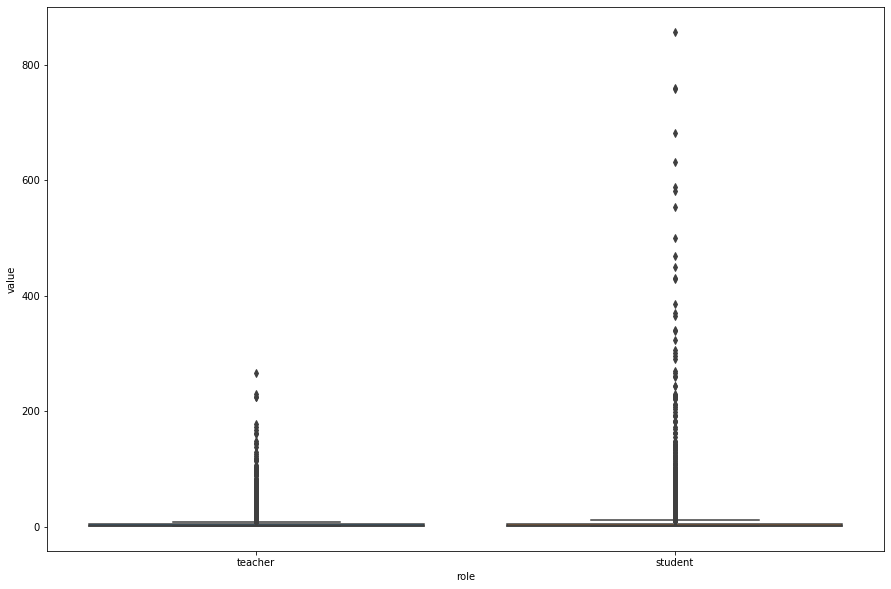

Границы для выбросов:
[0, 135.35499999999956]
boxplot после чистки выбросов для video_state_down > 0


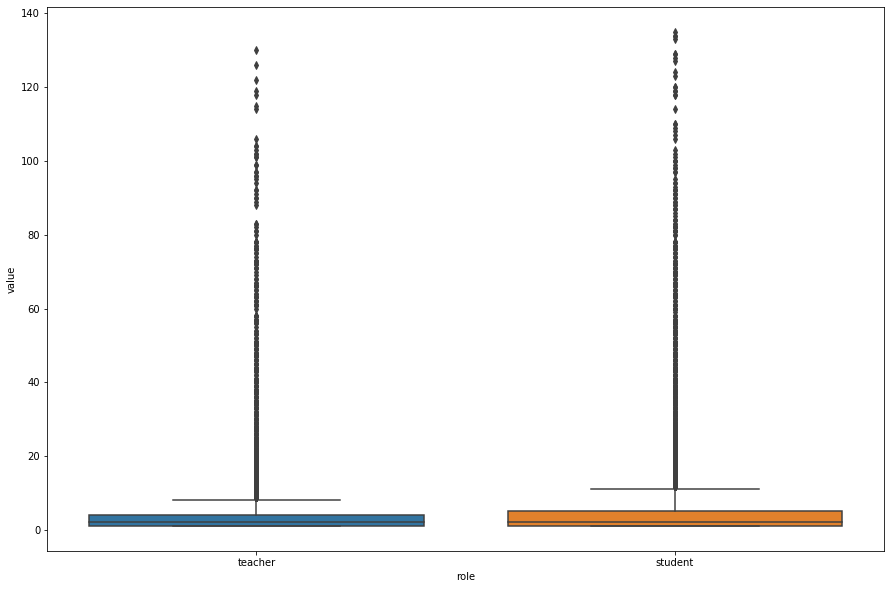

boxplot после чистки выбросов для студентов для video_state_down > 0


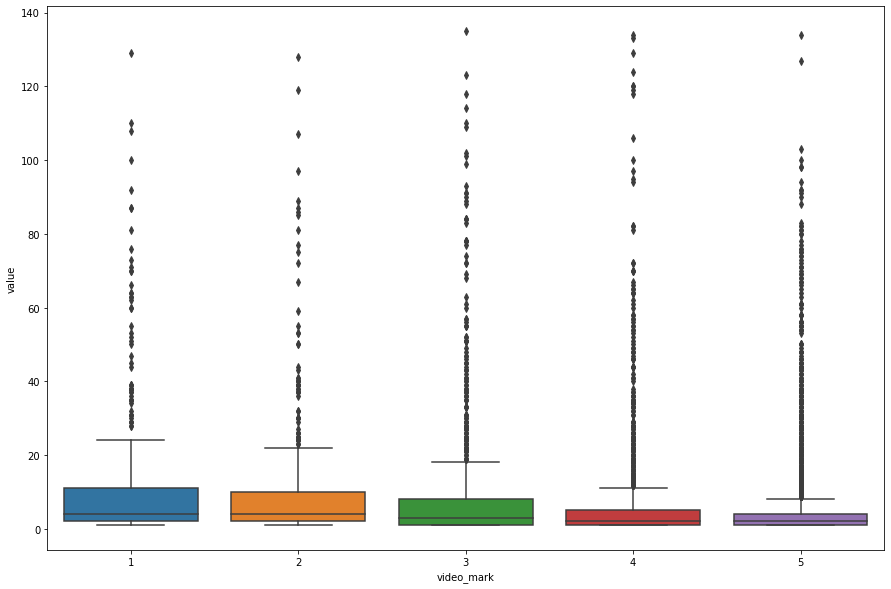

boxplot после чистки выбросов для учителей для video_state_down > 0


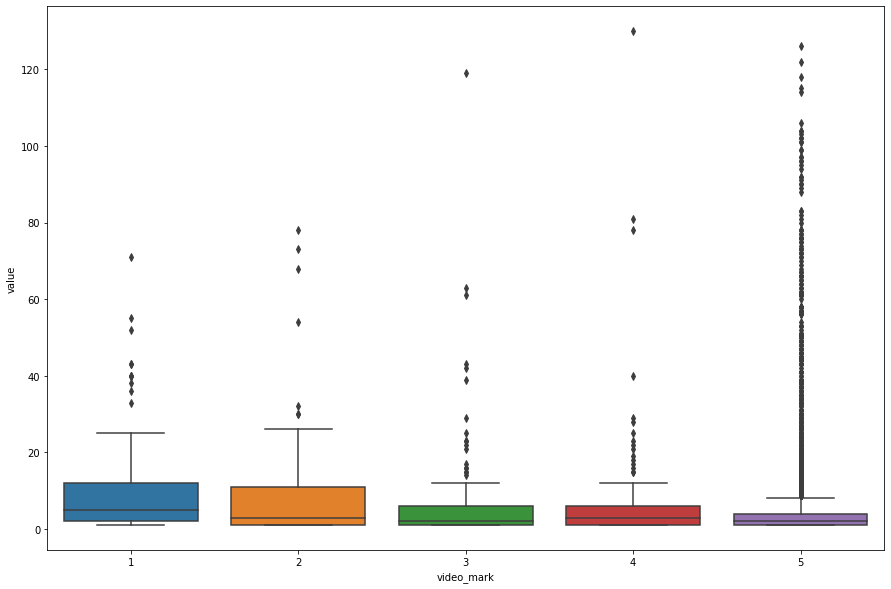

Гистограмма после чистки выбросов для video_state_down > 0


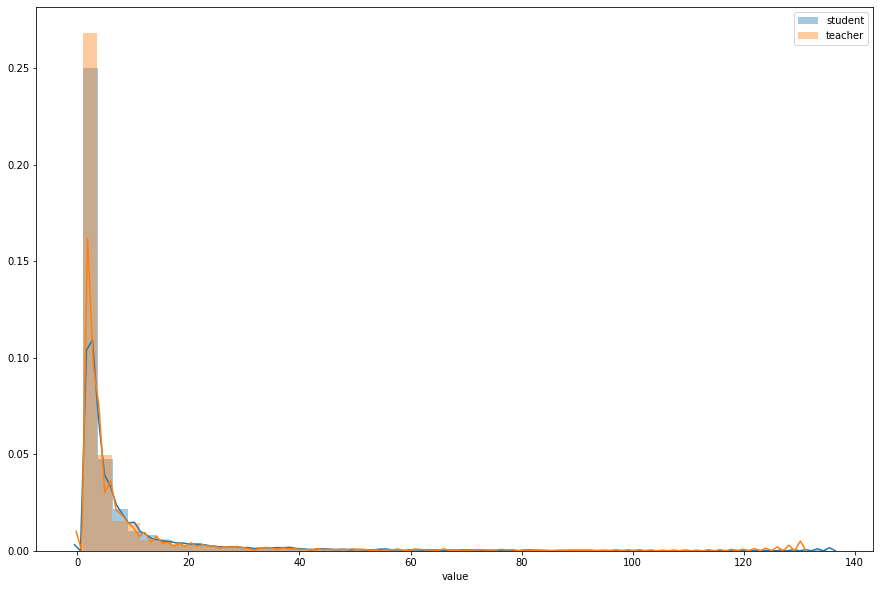

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для video_state_down > 0


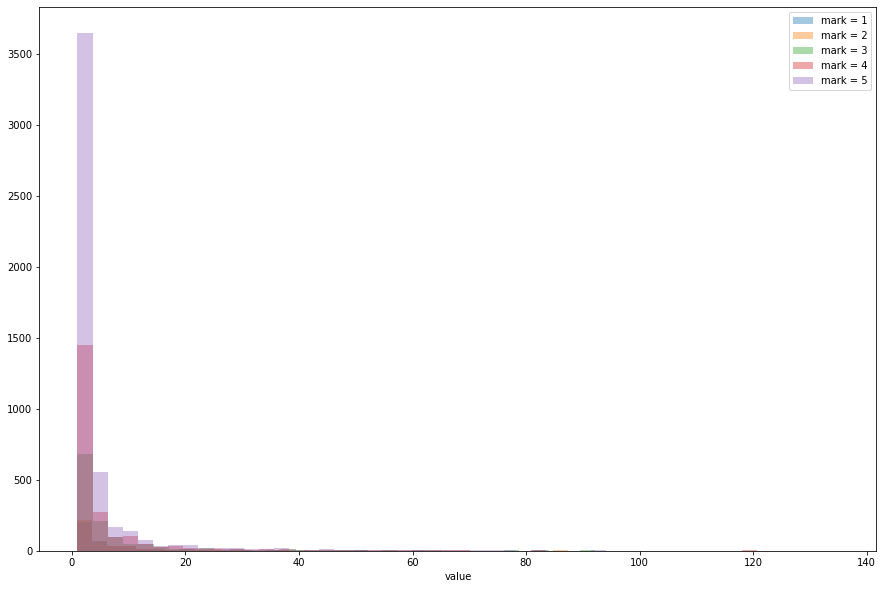

Гистограмма для учителей для video_state_down > 0


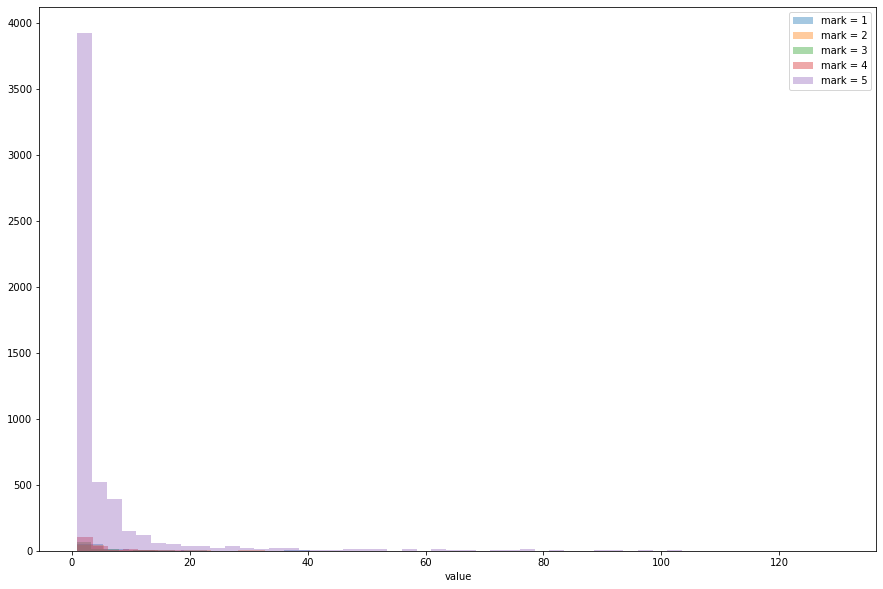



------------------------------ TOTAL_TECH_COUNT -------------------------------
Изменение среднего по времени для метрики total_tech_count ()


Изменение количества записей по времени для метрики total_tech_count ()


boxplot для total_tech_count > 0


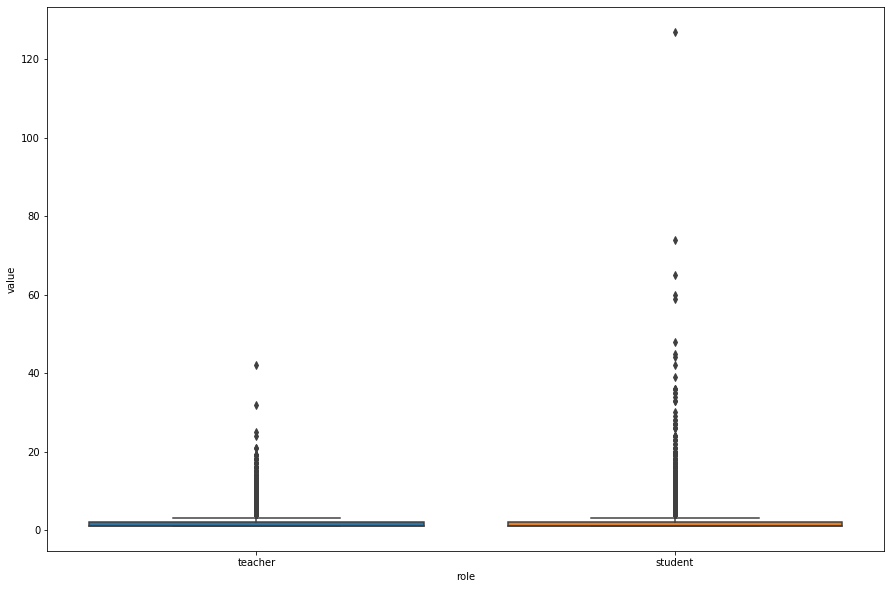

Границы для выбросов:
[0, 11.0]
boxplot после чистки выбросов для total_tech_count > 0


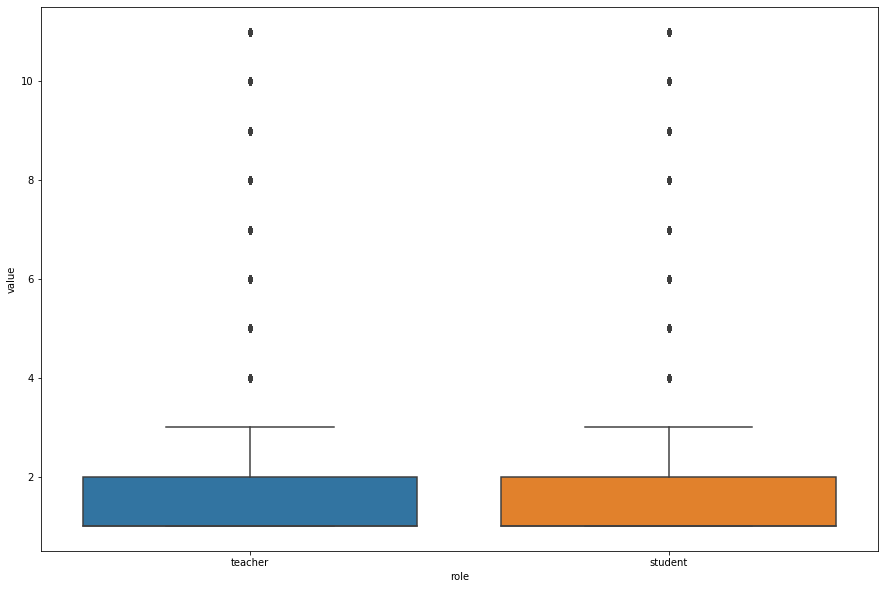

boxplot после чистки выбросов для студентов для total_tech_count > 0


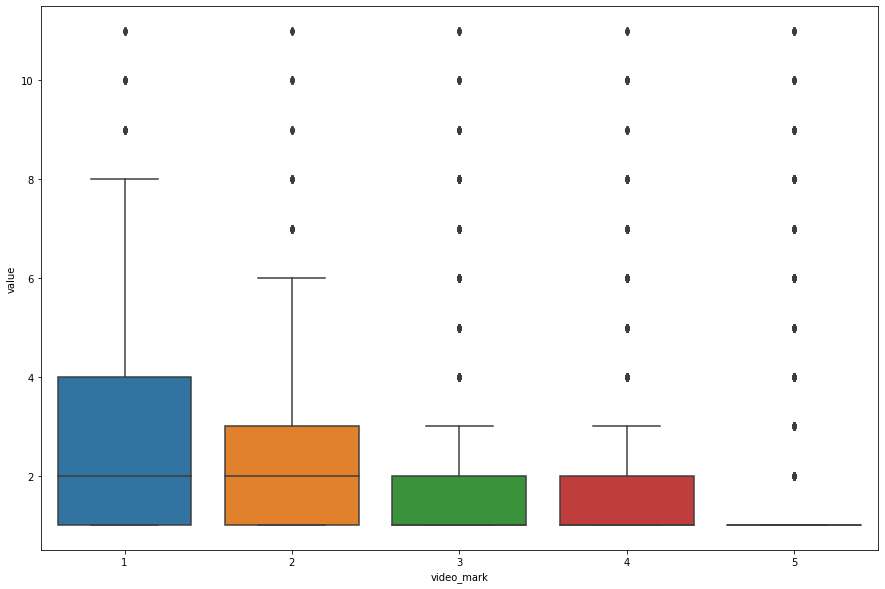

boxplot после чистки выбросов для учителей для total_tech_count > 0


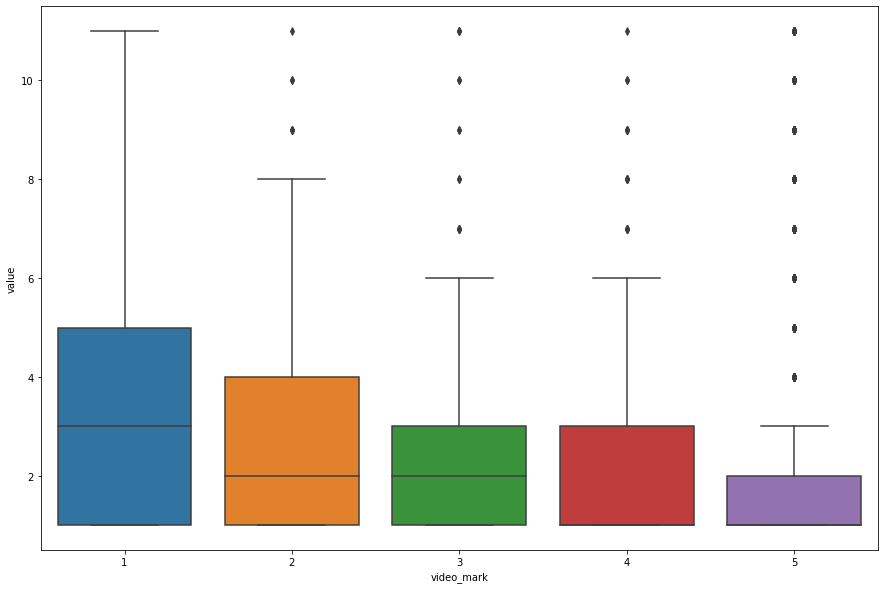

Гистограмма после чистки выбросов для total_tech_count > 0


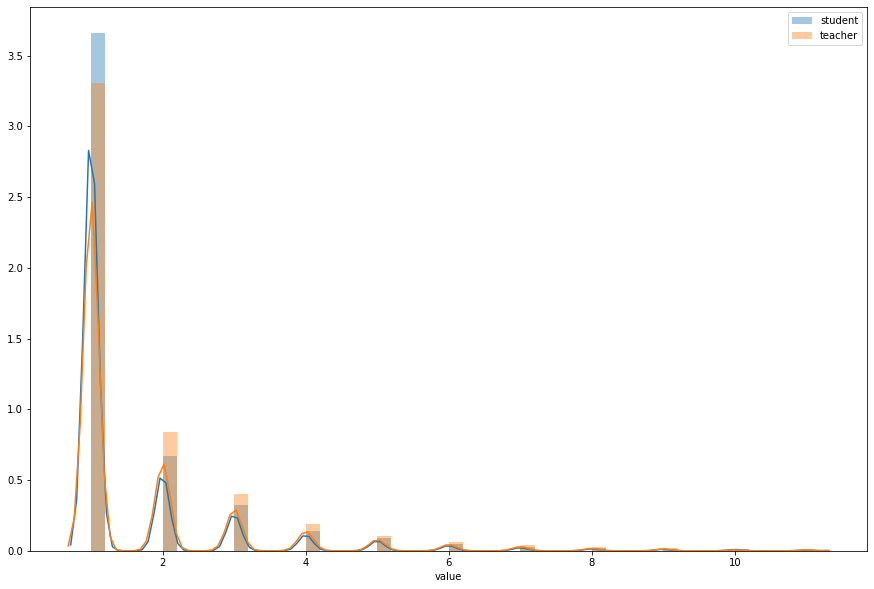

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для total_tech_count > 0


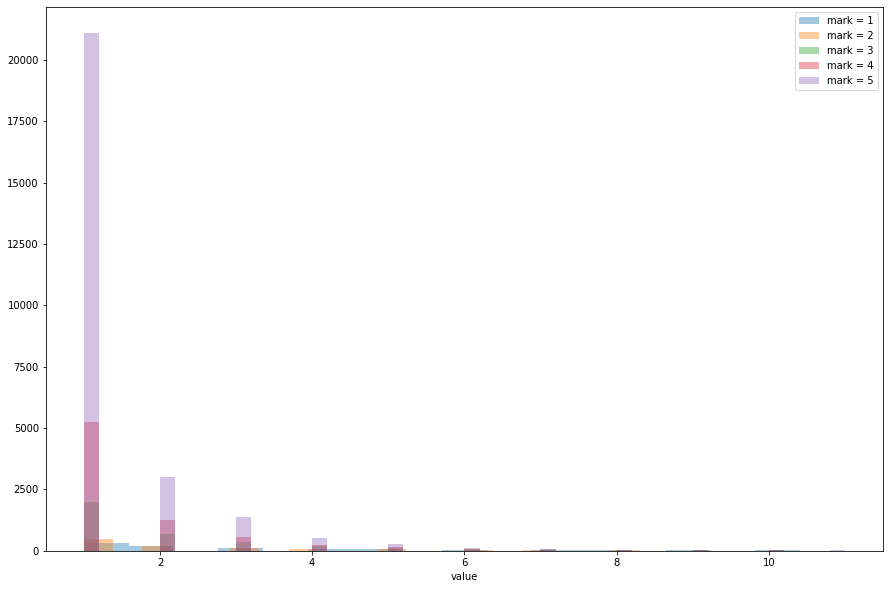

Гистограмма для учителей для total_tech_count > 0


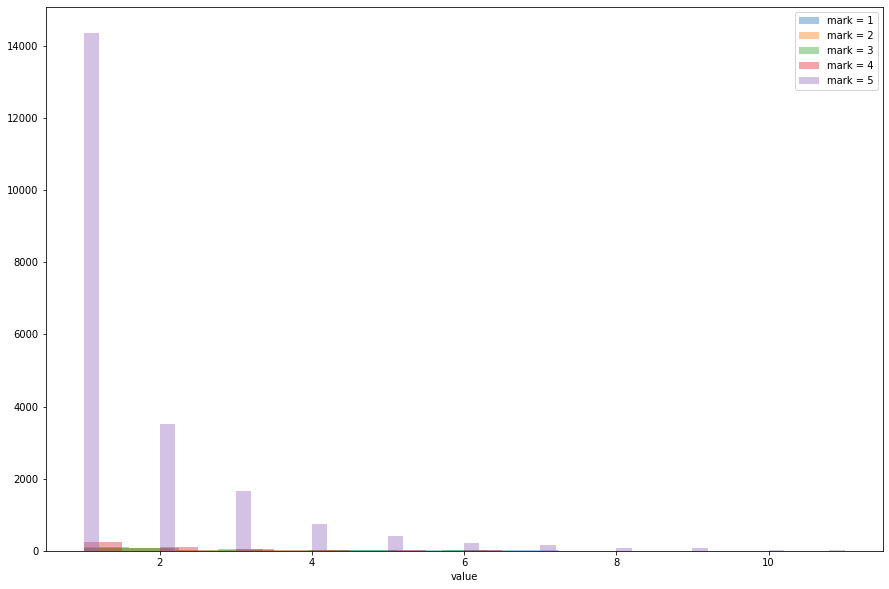



------------------------------ INC_INACTIVE_CONNECTION_COUNT -------------------------------
Изменение среднего по времени для метрики inc_inactive_connection_count ()


Изменение количества записей по времени для метрики inc_inactive_connection_count ()


boxplot для inc_inactive_connection_count > 0


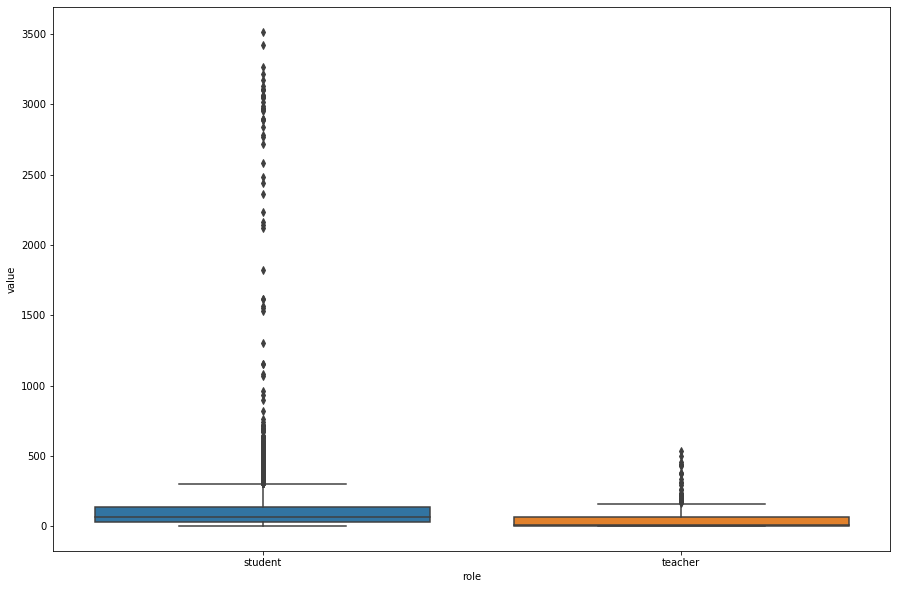

Границы для выбросов:
[0, 2429.809999999963]
boxplot после чистки выбросов для inc_inactive_connection_count > 0


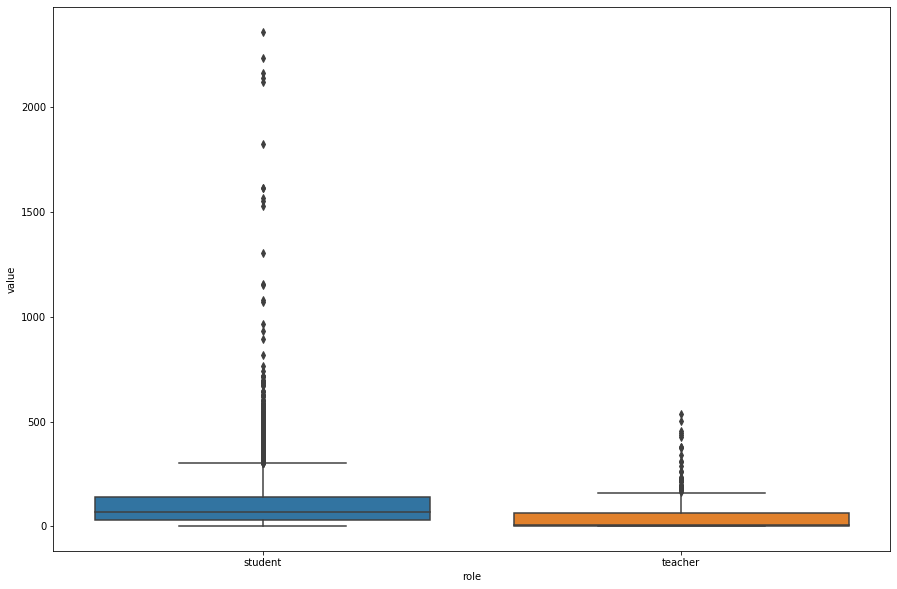

boxplot после чистки выбросов для студентов для inc_inactive_connection_count > 0


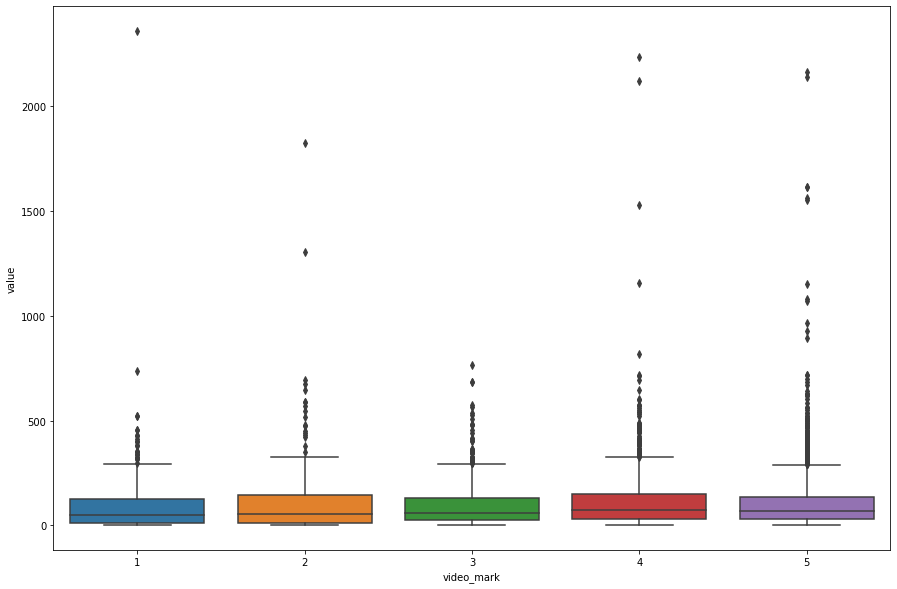

boxplot после чистки выбросов для учителей для inc_inactive_connection_count > 0


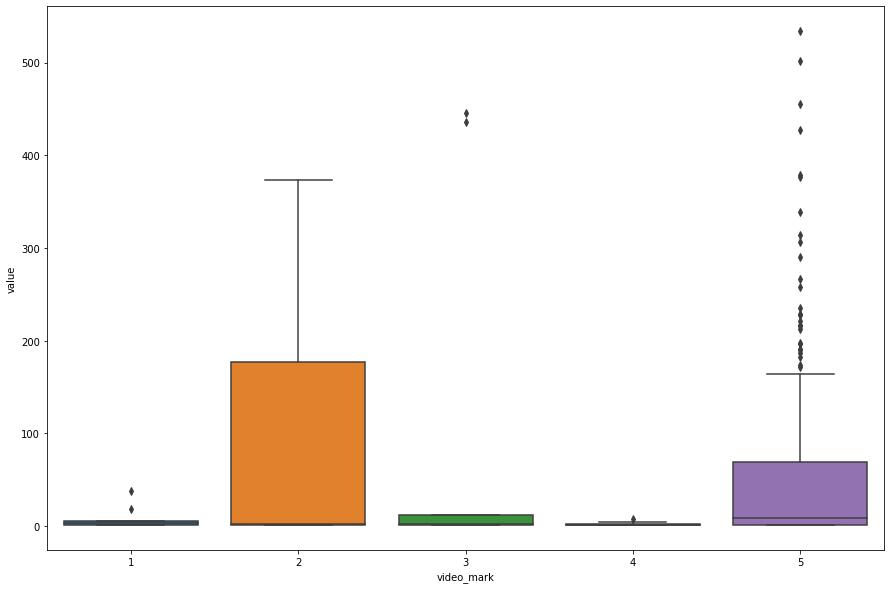

Гистограмма после чистки выбросов для inc_inactive_connection_count > 0


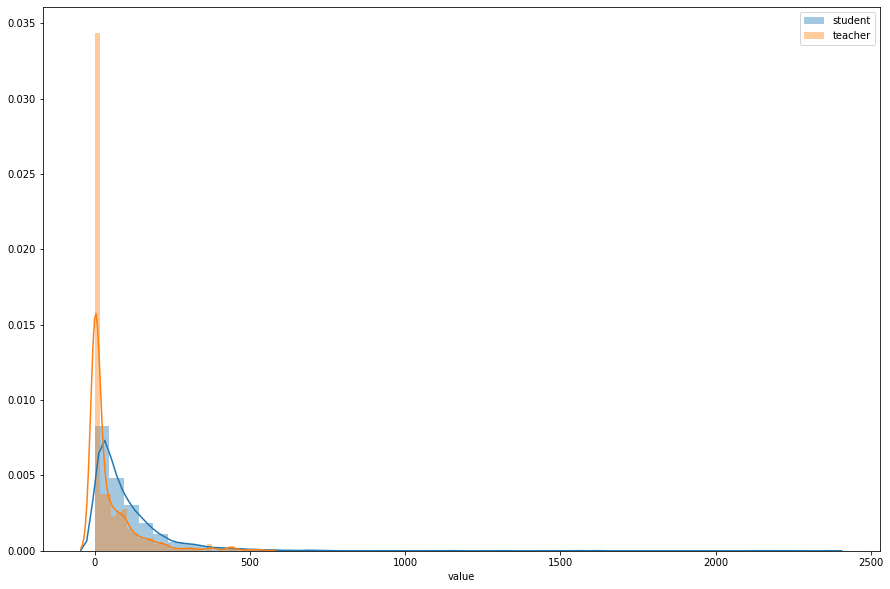

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_inactive_connection_count > 0


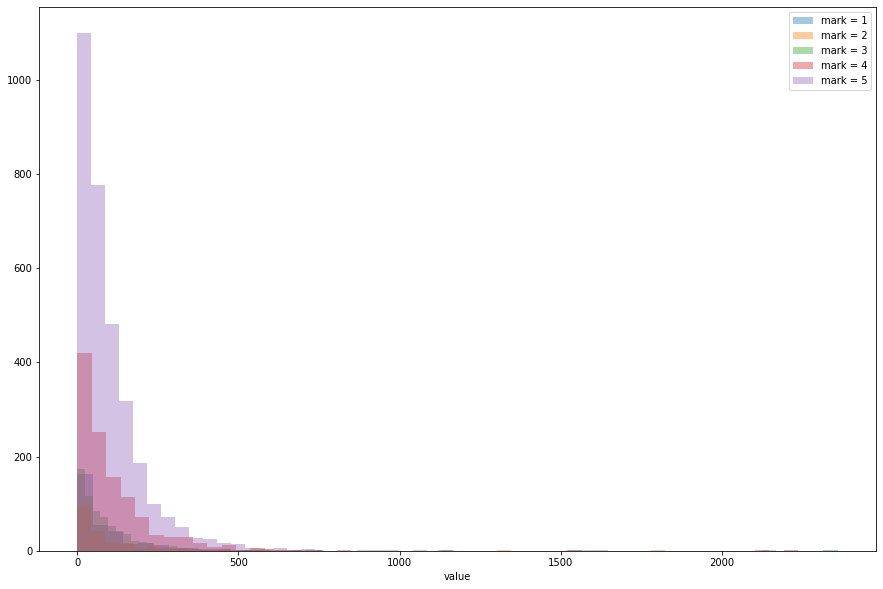

Гистограмма для учителей для inc_inactive_connection_count > 0


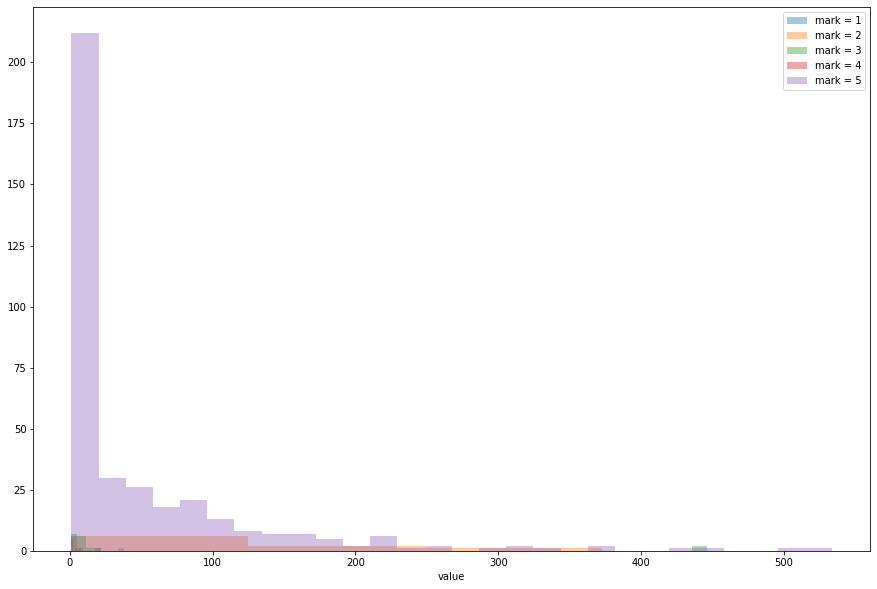



------------------------------ INC_FPS_RECEIVER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_fps_receiver_duration_share (доля времени, когда в принимаемом потоке становилось менее 4 кадров в секунду)


Изменение количества записей по времени для метрики inc_fps_receiver_duration_share (доля времени, когда в принимаемом потоке становилось менее 4 кадров в секунду)


boxplot для inc_fps_receiver_duration_share > 0


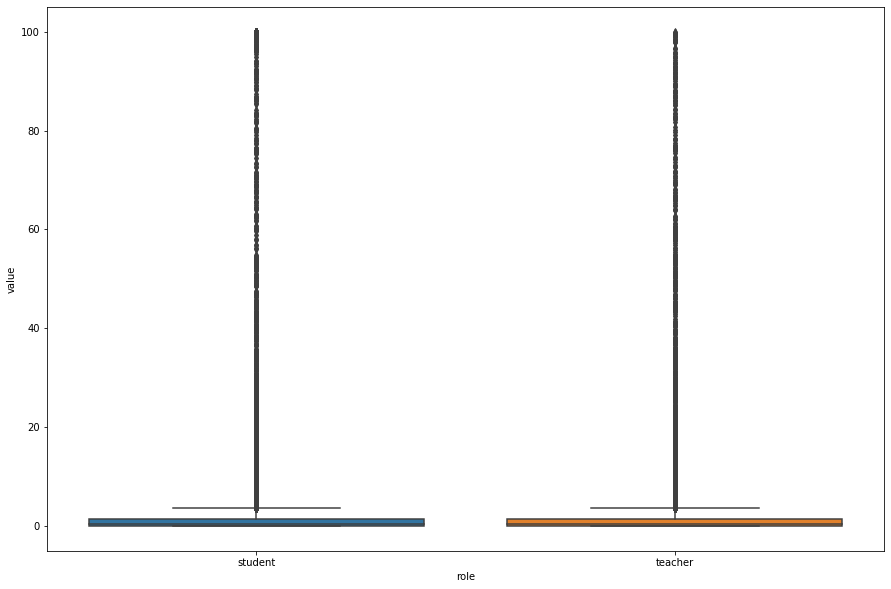

Границы для выбросов:
[0, 99.23669999999998]
boxplot после чистки выбросов для inc_fps_receiver_duration_share > 0


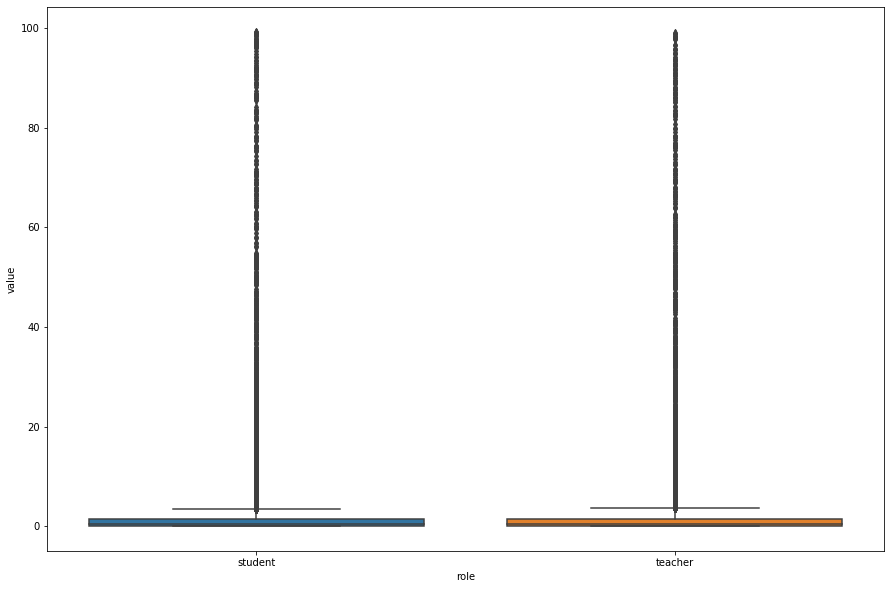

boxplot после чистки выбросов для студентов для inc_fps_receiver_duration_share > 0


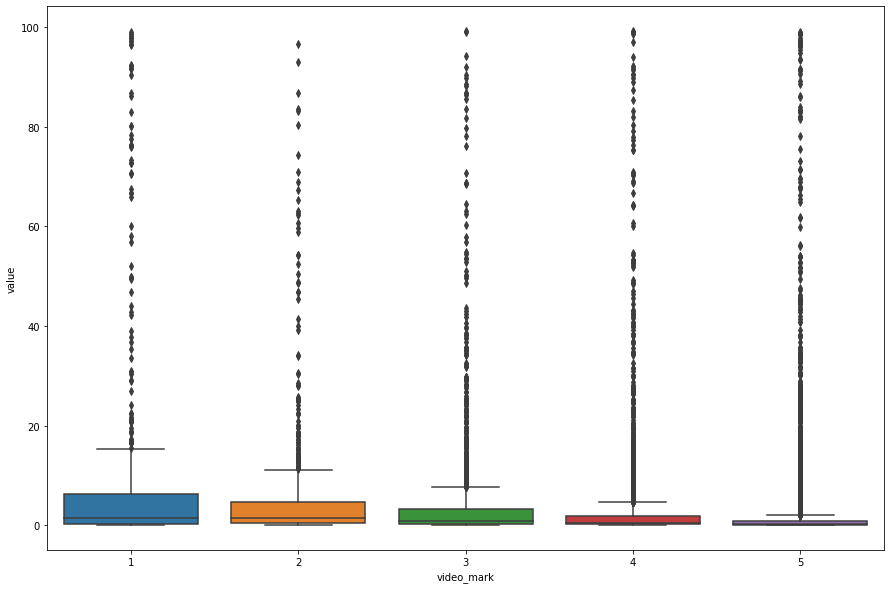

boxplot после чистки выбросов для учителей для inc_fps_receiver_duration_share > 0


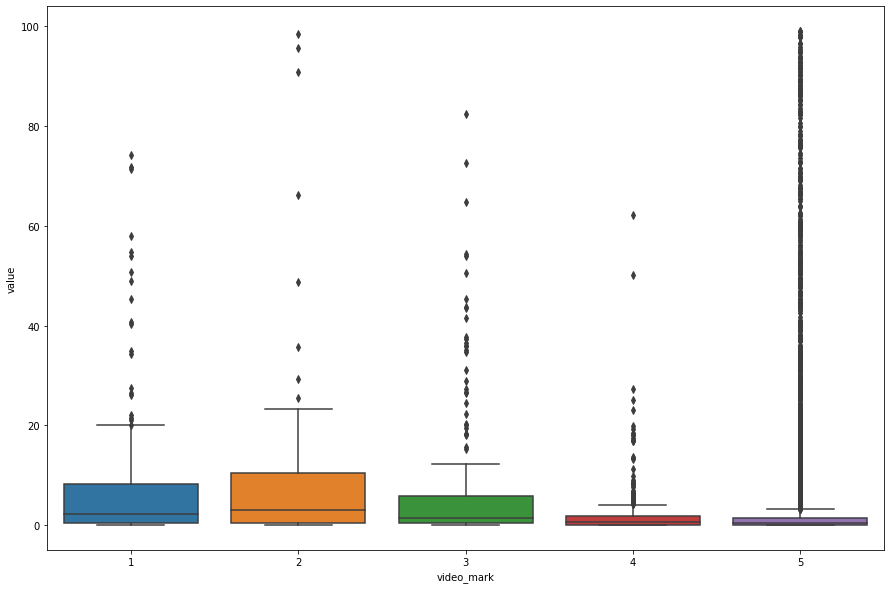

Гистограмма после чистки выбросов для inc_fps_receiver_duration_share > 0


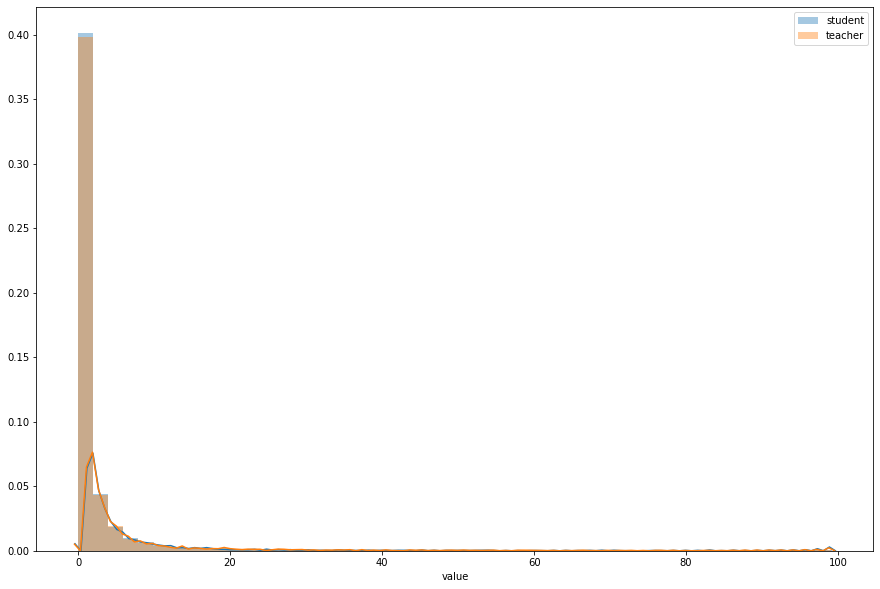

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_fps_receiver_duration_share > 0


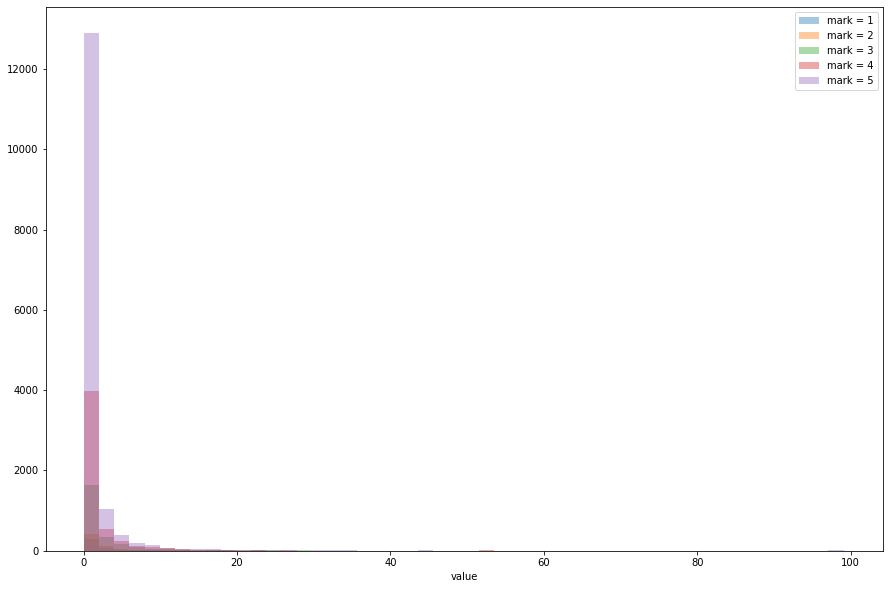

Гистограмма для учителей для inc_fps_receiver_duration_share > 0


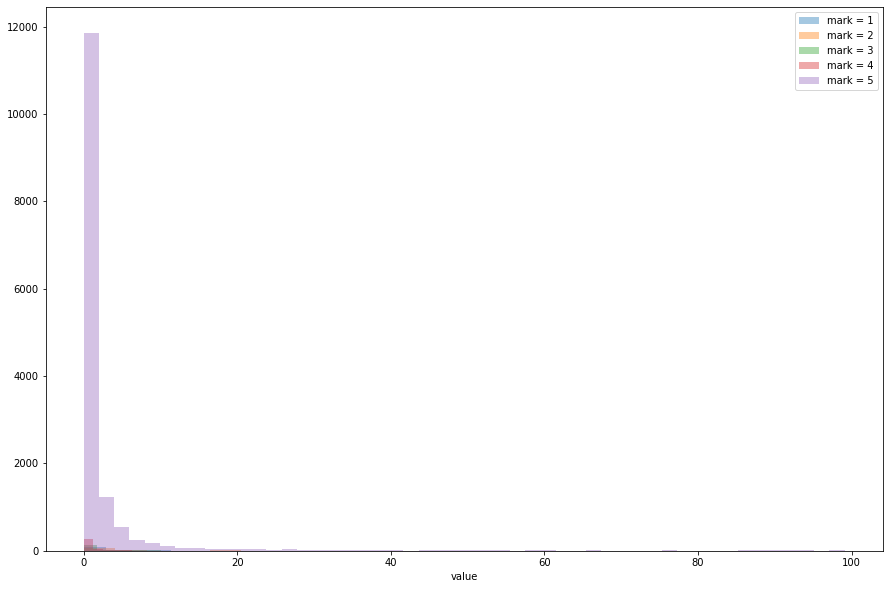



------------------------------ INC_FPS_SENDER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_fps_sender_duration_share (доля времени, когда в отправляемом потоке становилось менее 4 кадров в секунду)


Изменение количества записей по времени для метрики inc_fps_sender_duration_share (доля времени, когда в отправляемом потоке становилось менее 4 кадров в секунду)


boxplot для inc_fps_sender_duration_share > 0


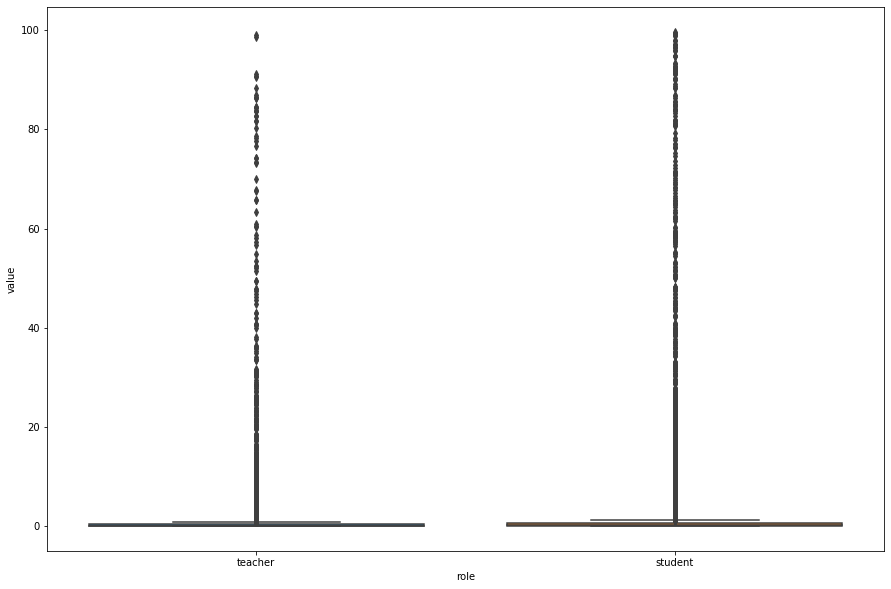

Границы для выбросов:
[0, 76.50999999999999]
boxplot после чистки выбросов для inc_fps_sender_duration_share > 0


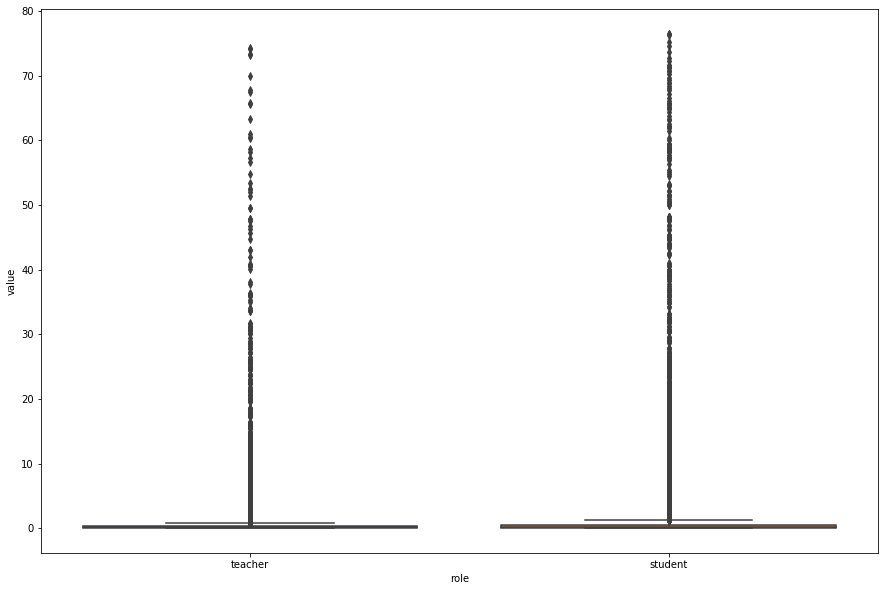

boxplot после чистки выбросов для студентов для inc_fps_sender_duration_share > 0


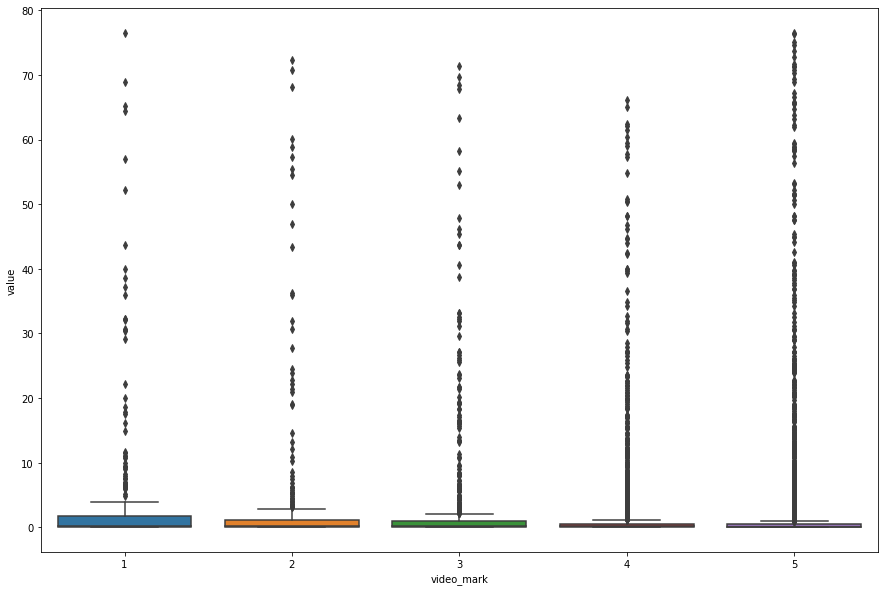

boxplot после чистки выбросов для учителей для inc_fps_sender_duration_share > 0


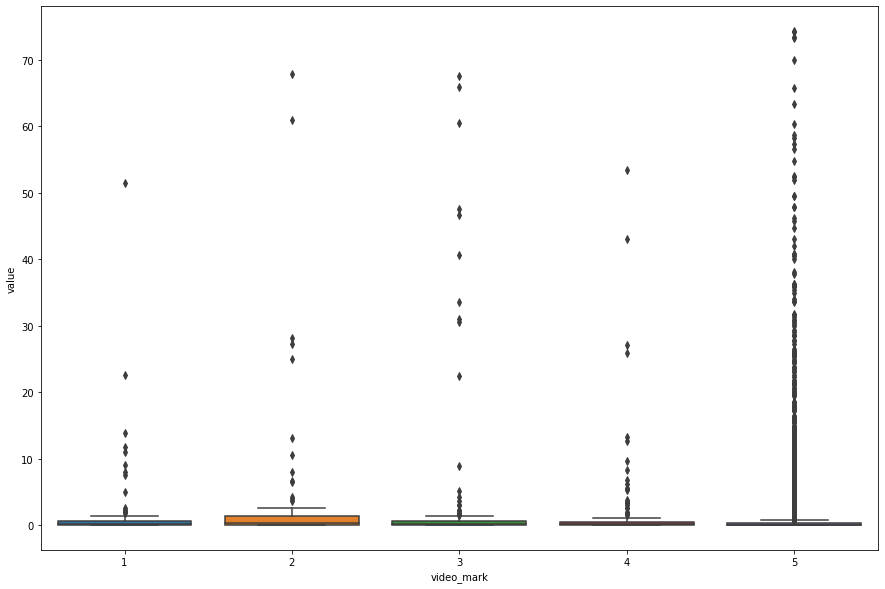

Гистограмма после чистки выбросов для inc_fps_sender_duration_share > 0


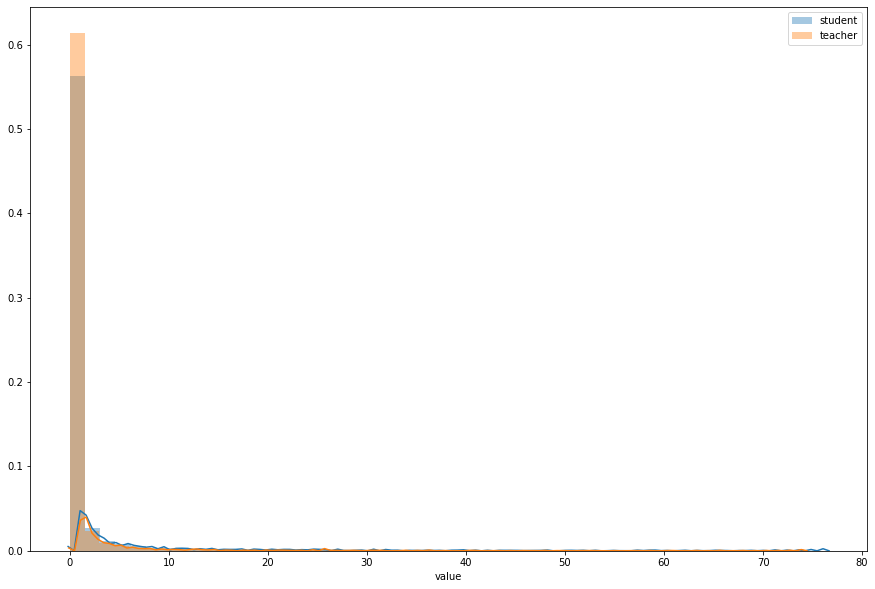

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_fps_sender_duration_share > 0


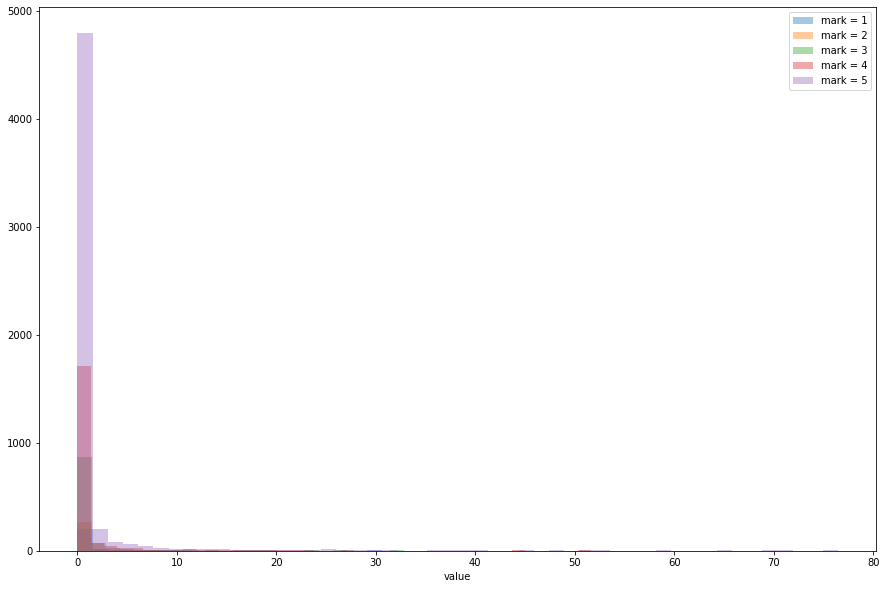

Гистограмма для учителей для inc_fps_sender_duration_share > 0


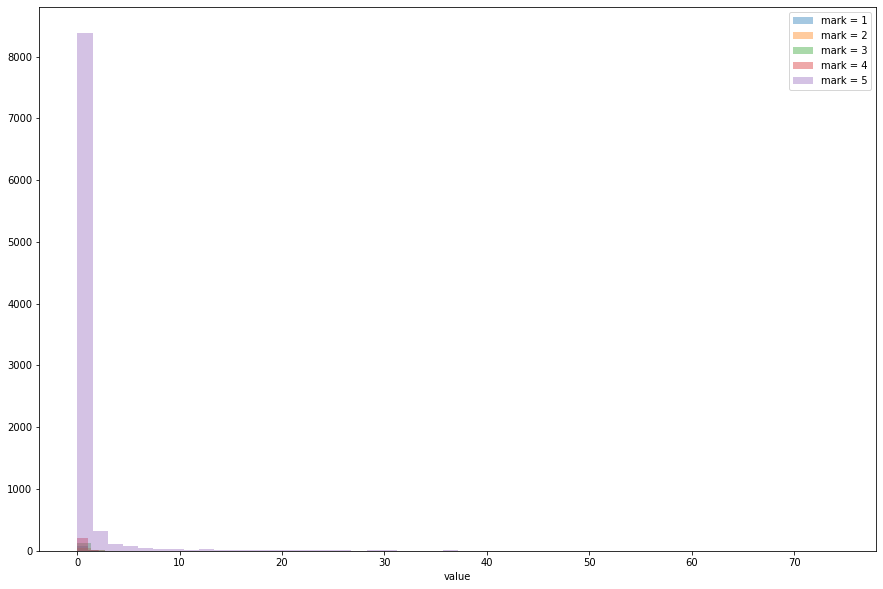



------------------------------ INC_LAG_AUDIO_VIDEO_RECEIVER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_lag_audio_video_receiver_duration_share (доля времени, когда в принимаемом потоке возникал рассинхрон между аудио и видео больше 1 секунды)


Изменение количества записей по времени для метрики inc_lag_audio_video_receiver_duration_share (доля времени, когда в принимаемом потоке возникал рассинхрон между аудио и видео больше 1 секунды)


boxplot для inc_lag_audio_video_receiver_duration_share > 0


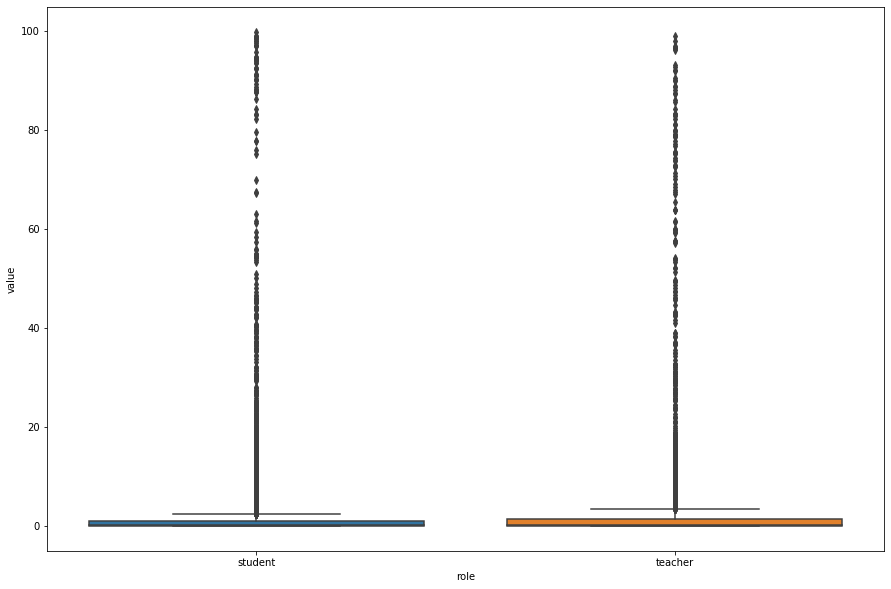

Границы для выбросов:
[0, 82.9450999999998]
boxplot после чистки выбросов для inc_lag_audio_video_receiver_duration_share > 0


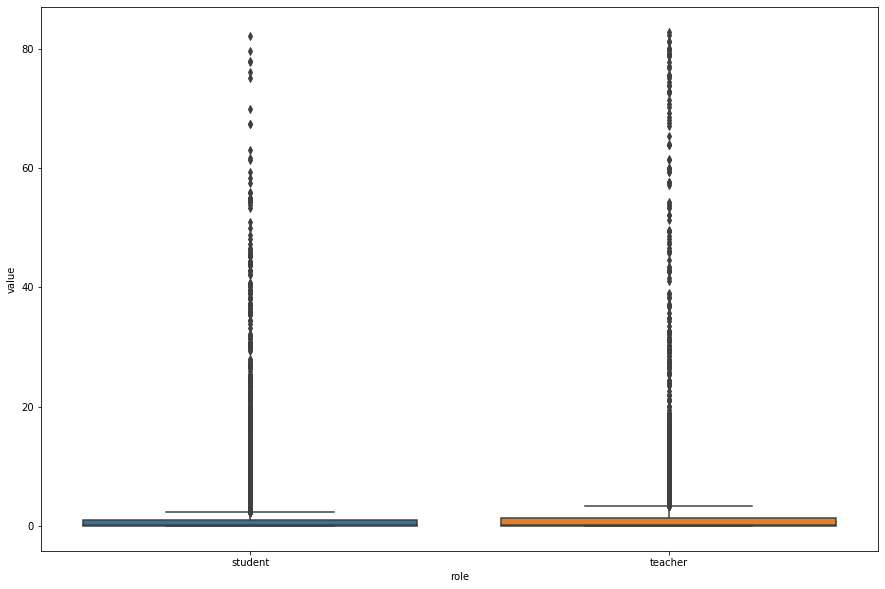

boxplot после чистки выбросов для студентов для inc_lag_audio_video_receiver_duration_share > 0


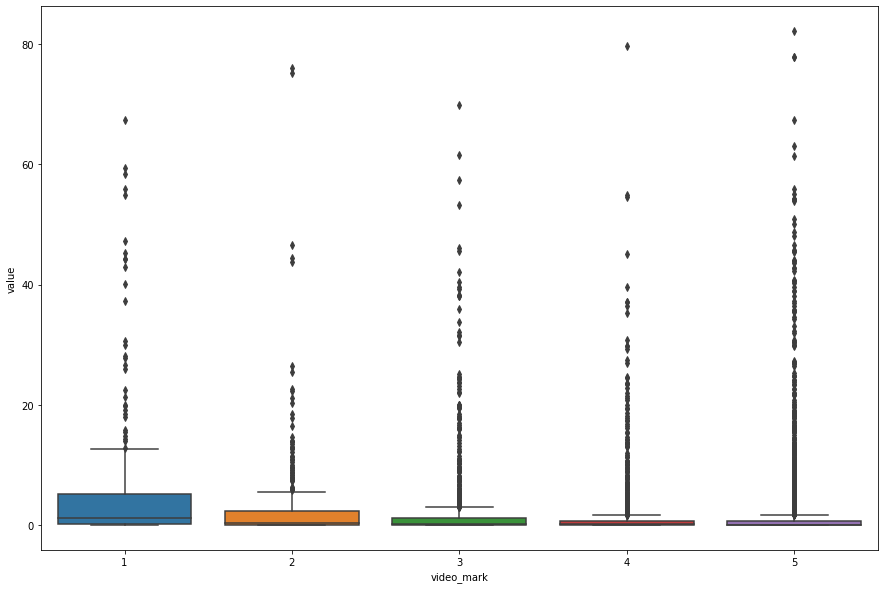

boxplot после чистки выбросов для учителей для inc_lag_audio_video_receiver_duration_share > 0


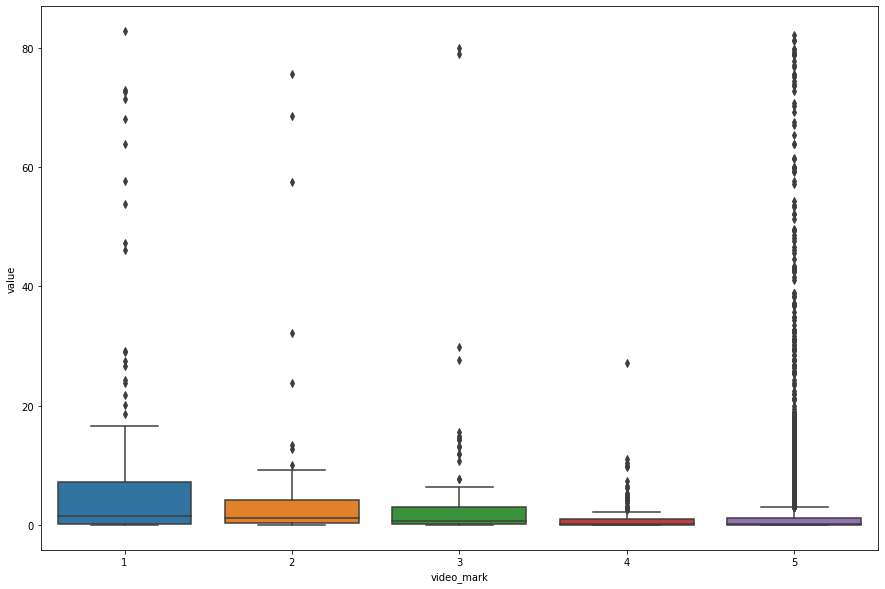

Гистограмма после чистки выбросов для inc_lag_audio_video_receiver_duration_share > 0


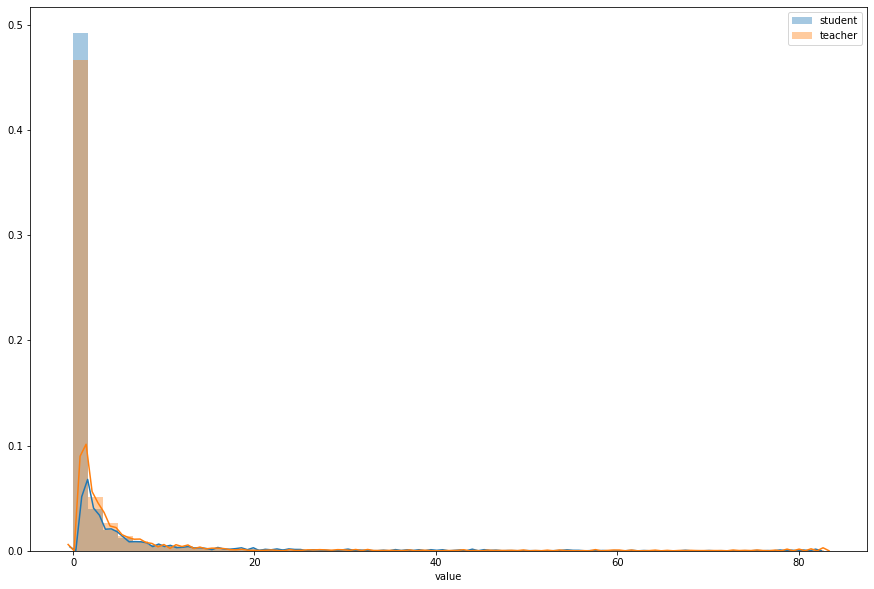

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_lag_audio_video_receiver_duration_share > 0


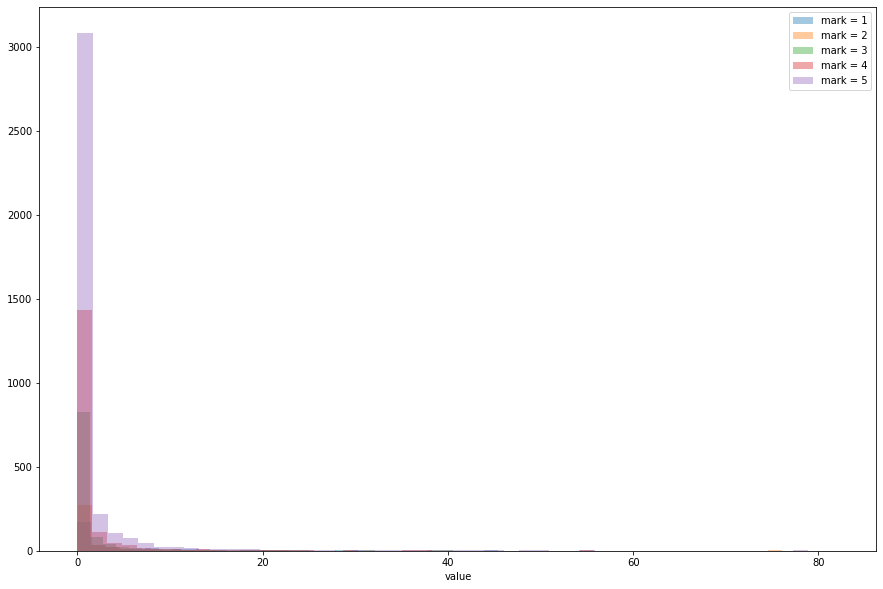

Гистограмма для учителей для inc_lag_audio_video_receiver_duration_share > 0


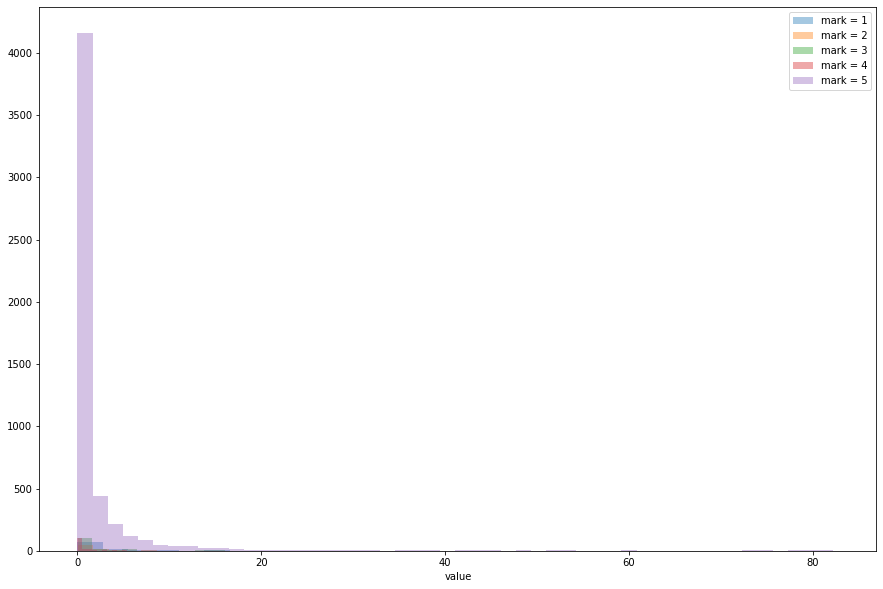



------------------------------ INC_QP_RECEIVER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_qp_receiver_duration_share (доля времени, когда в принимаемом потоке была пережатая картинка (квадраты и т.п.))


Изменение количества записей по времени для метрики inc_qp_receiver_duration_share (доля времени, когда в принимаемом потоке была пережатая картинка (квадраты и т.п.))


boxplot для inc_qp_receiver_duration_share > 0


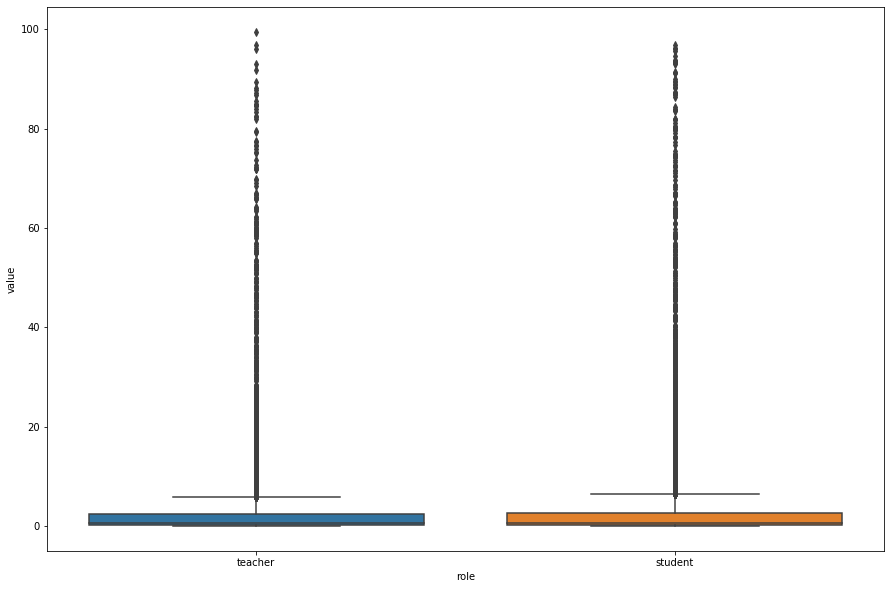

Границы для выбросов:
[0, 67.35399999999849]
boxplot после чистки выбросов для inc_qp_receiver_duration_share > 0


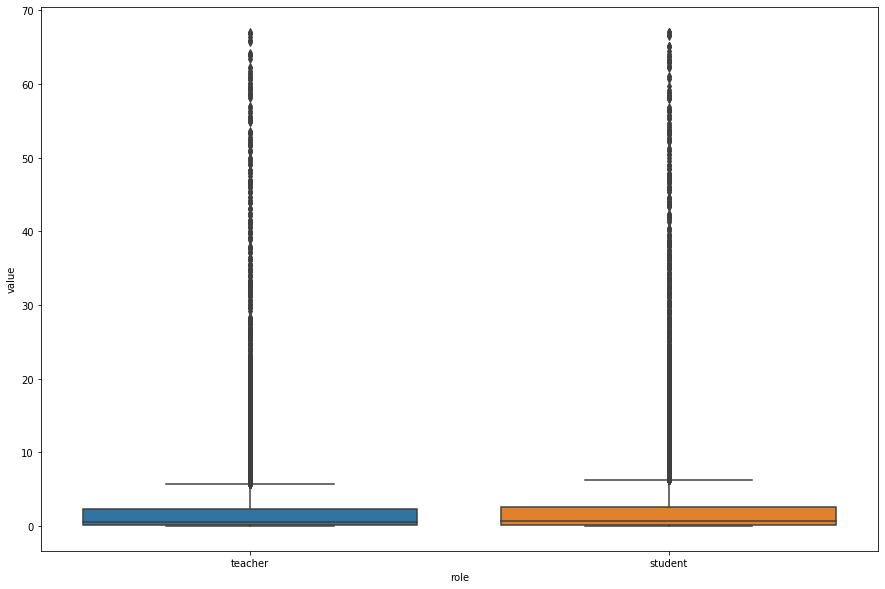

boxplot после чистки выбросов для студентов для inc_qp_receiver_duration_share > 0


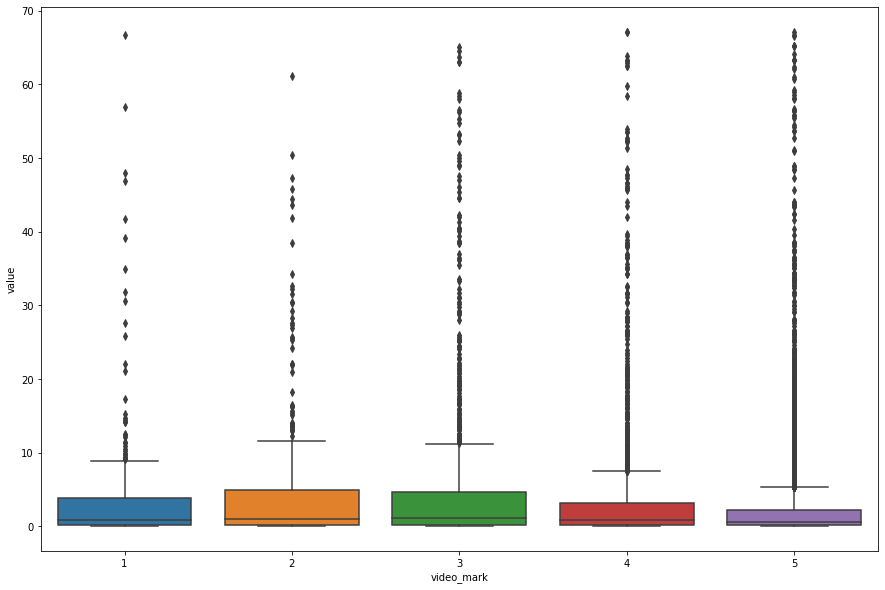

boxplot после чистки выбросов для учителей для inc_qp_receiver_duration_share > 0


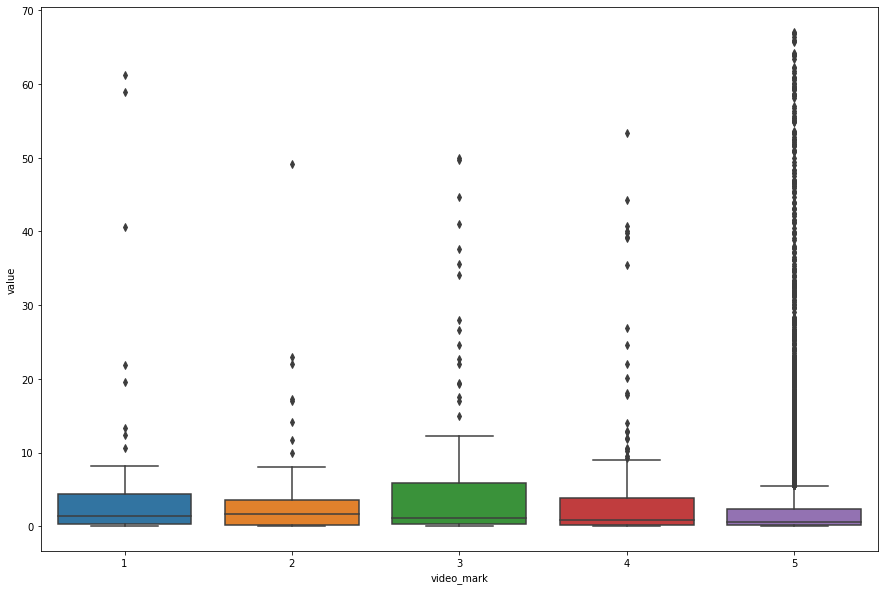

Гистограмма после чистки выбросов для inc_qp_receiver_duration_share > 0


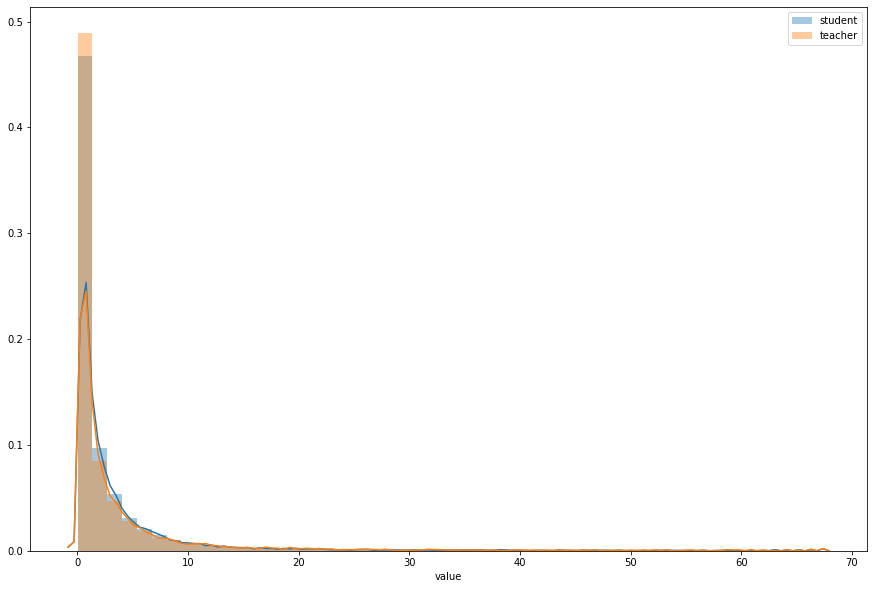

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_qp_receiver_duration_share > 0


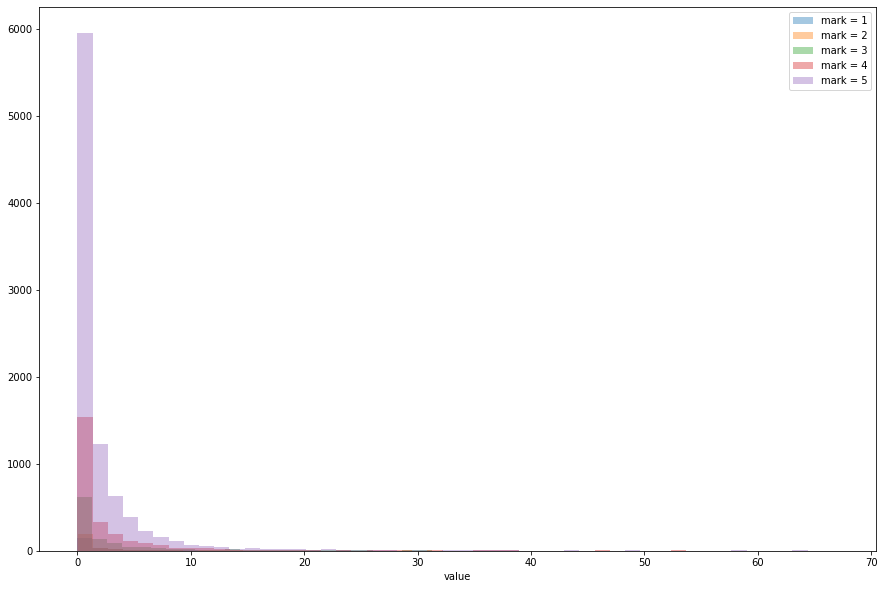

Гистограмма для учителей для inc_qp_receiver_duration_share > 0


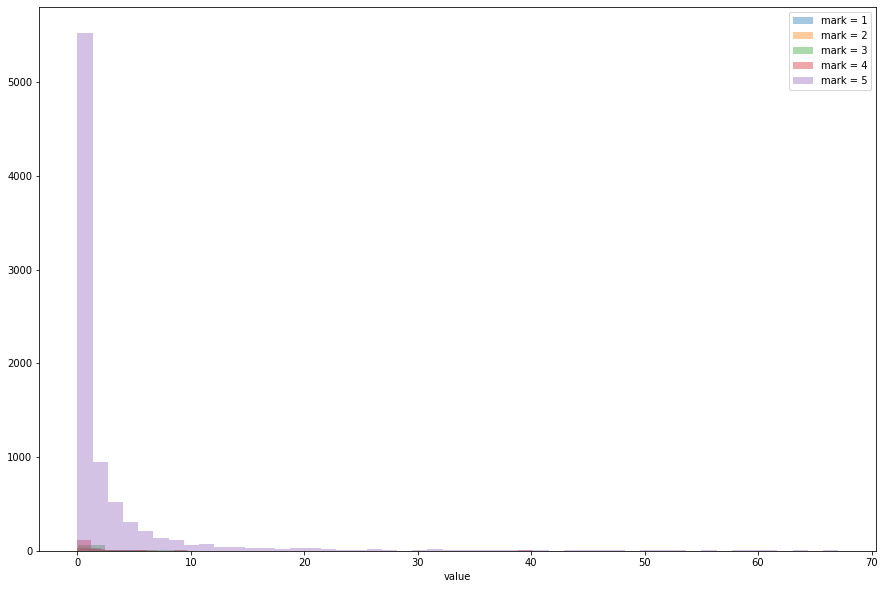



------------------------------ INC_RESOLUTION_RECEIVER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_resolution_receiver_duration_share (доля времени, когда в принимаемом потоке была пережатая картинка (квадраты и т.п.))


Изменение количества записей по времени для метрики inc_resolution_receiver_duration_share (доля времени, когда в принимаемом потоке была пережатая картинка (квадраты и т.п.))


boxplot для inc_resolution_receiver_duration_share > 0


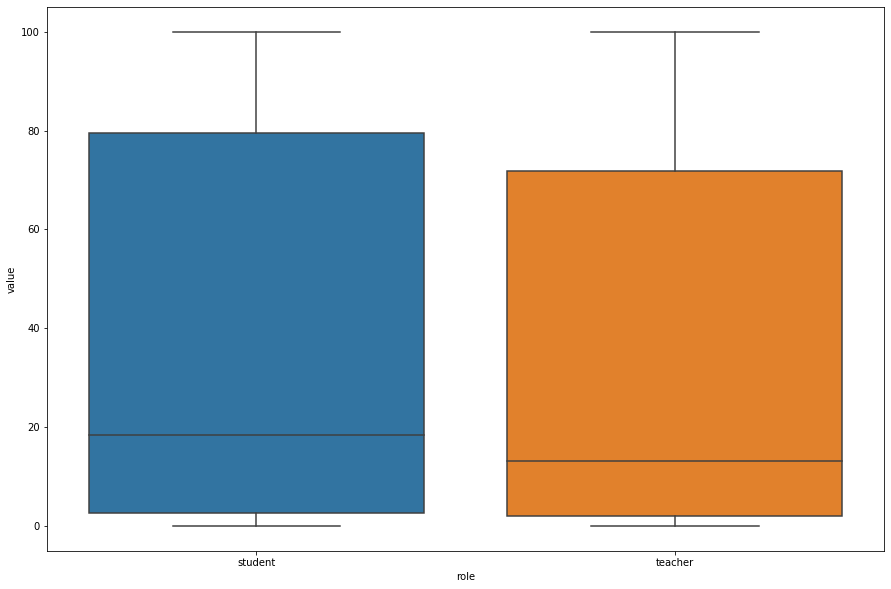

Границы для выбросов:
[0, 99.9]
boxplot после чистки выбросов для inc_resolution_receiver_duration_share > 0


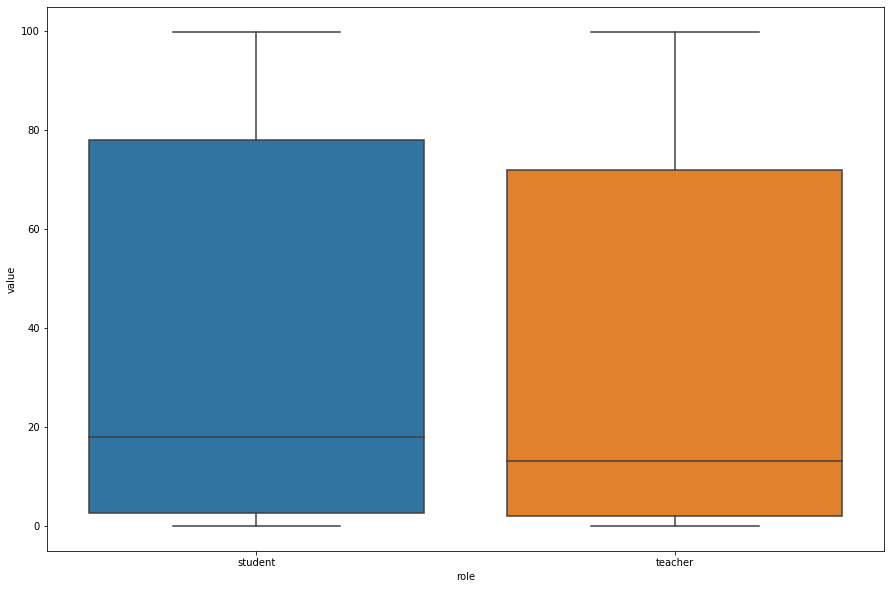

boxplot после чистки выбросов для студентов для inc_resolution_receiver_duration_share > 0


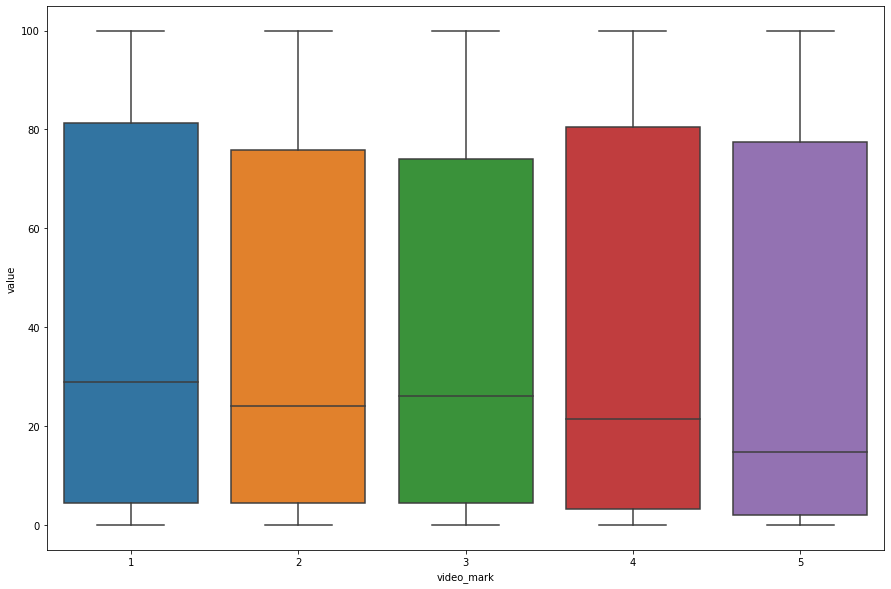

boxplot после чистки выбросов для учителей для inc_resolution_receiver_duration_share > 0


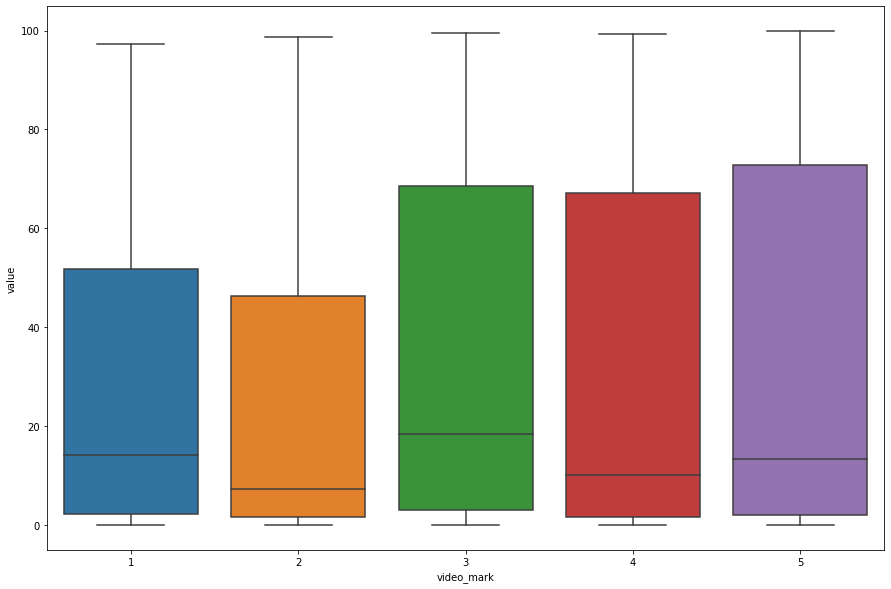

Гистограмма после чистки выбросов для inc_resolution_receiver_duration_share > 0


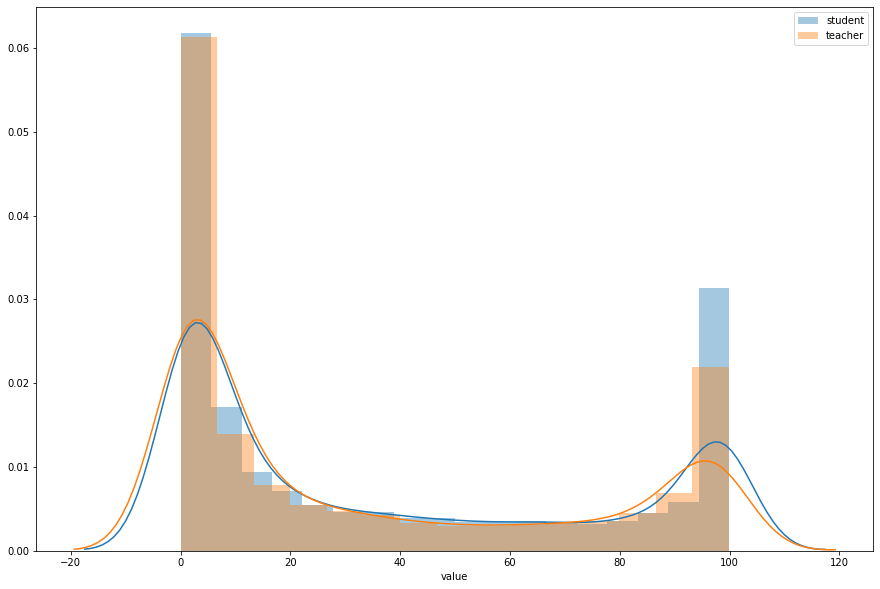

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_resolution_receiver_duration_share > 0


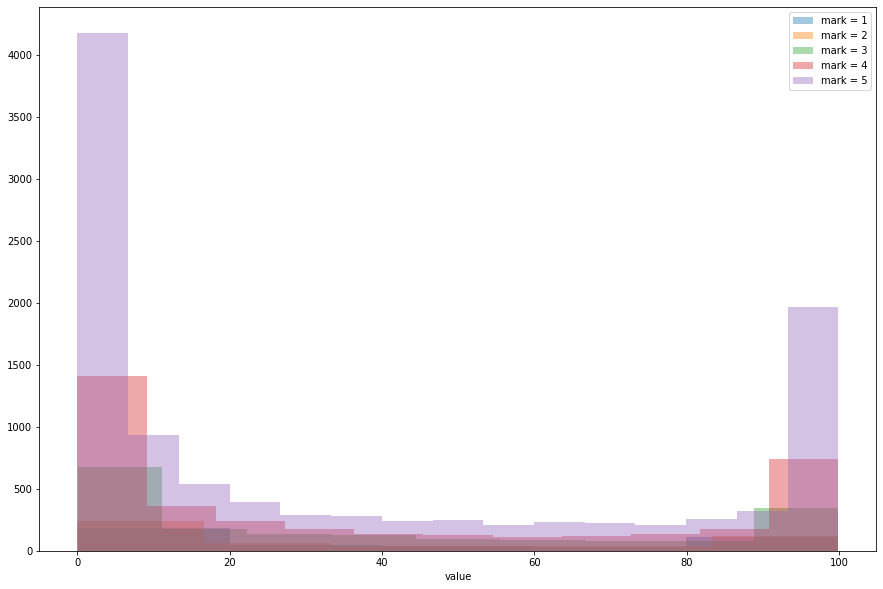

Гистограмма для учителей для inc_resolution_receiver_duration_share > 0


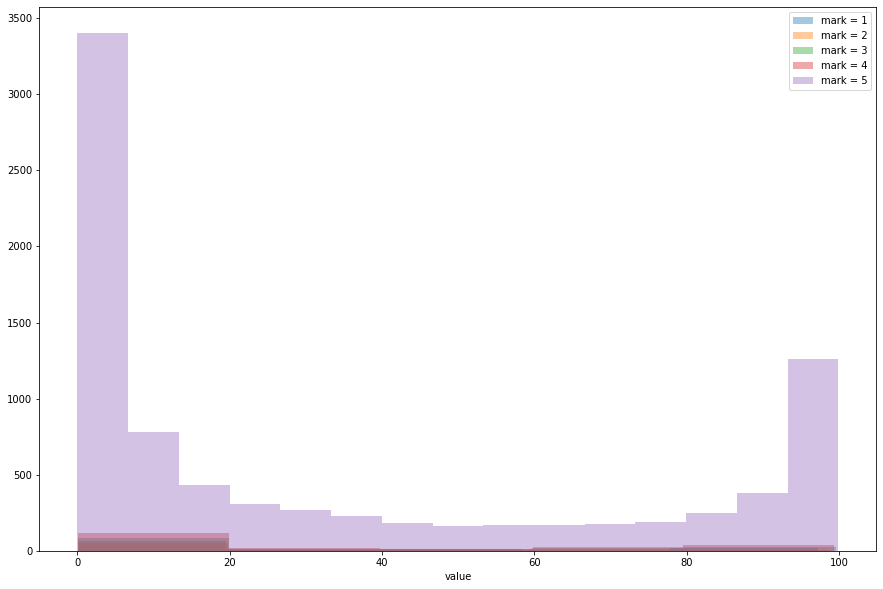



------------------------------ INC_RTT_RECEIVER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_rtt_receiver_duration_share (доля времени, когда в принимаемом потоке был слишком большой пинг до сервера)


Изменение количества записей по времени для метрики inc_rtt_receiver_duration_share (доля времени, когда в принимаемом потоке был слишком большой пинг до сервера)


boxplot для inc_rtt_receiver_duration_share > 0


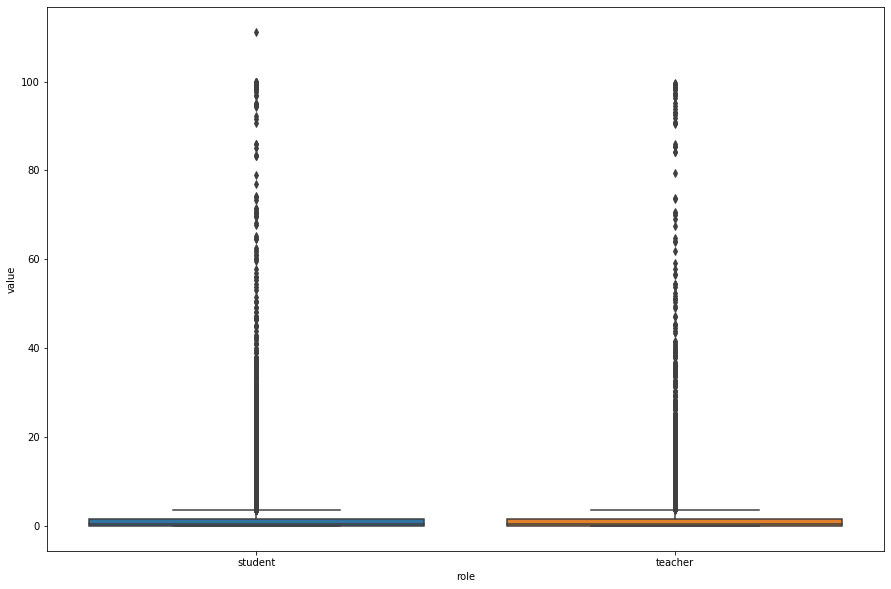

Границы для выбросов:
[0, 50.87259999999951]
boxplot после чистки выбросов для inc_rtt_receiver_duration_share > 0


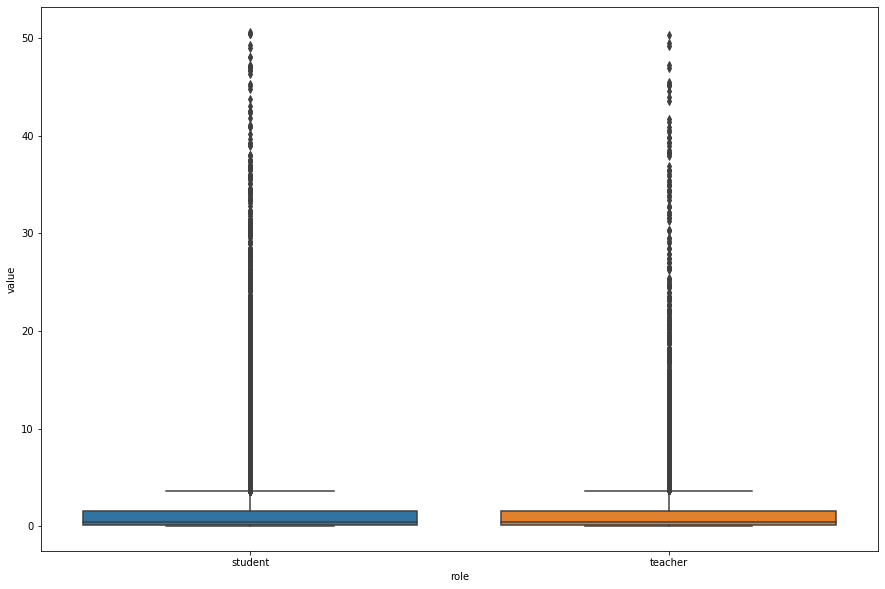

boxplot после чистки выбросов для студентов для inc_rtt_receiver_duration_share > 0


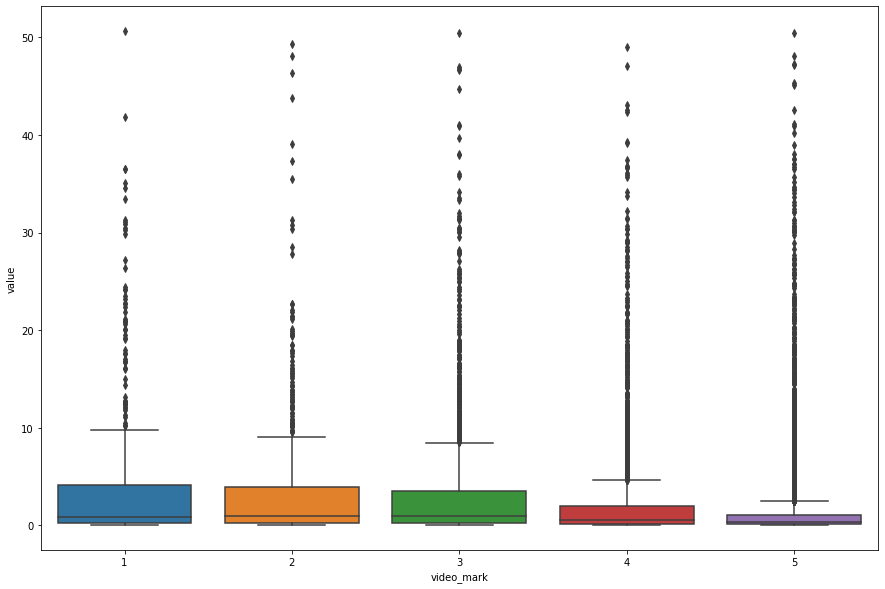

boxplot после чистки выбросов для учителей для inc_rtt_receiver_duration_share > 0


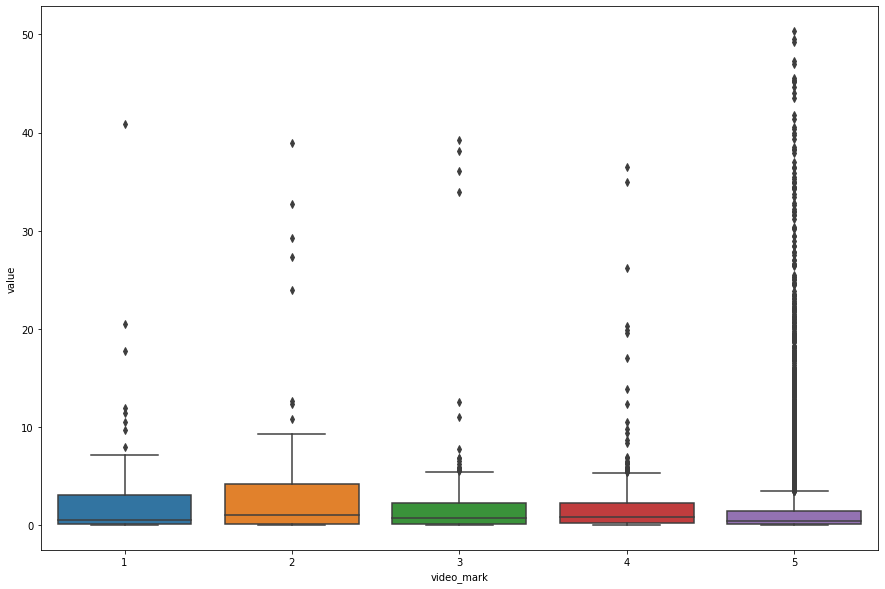

Гистограмма после чистки выбросов для inc_rtt_receiver_duration_share > 0


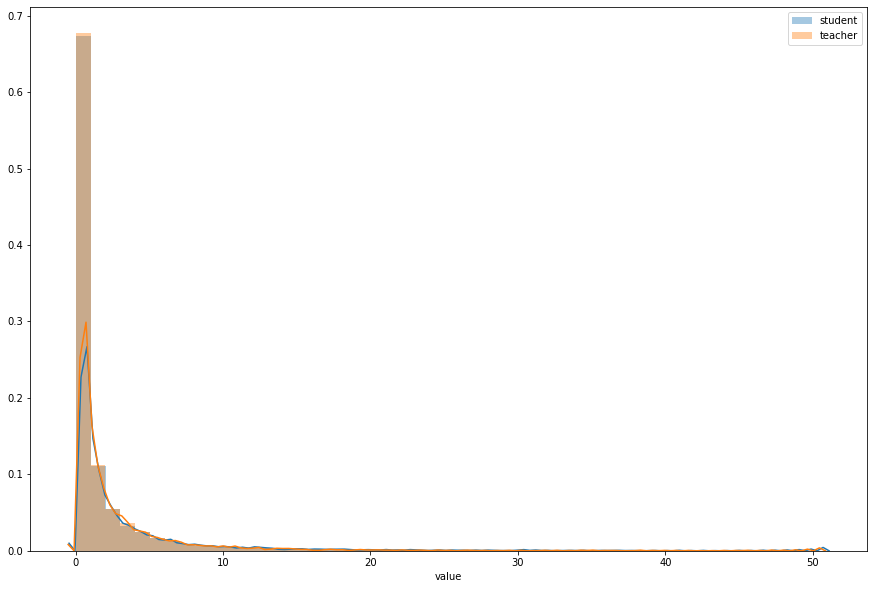

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_rtt_receiver_duration_share > 0


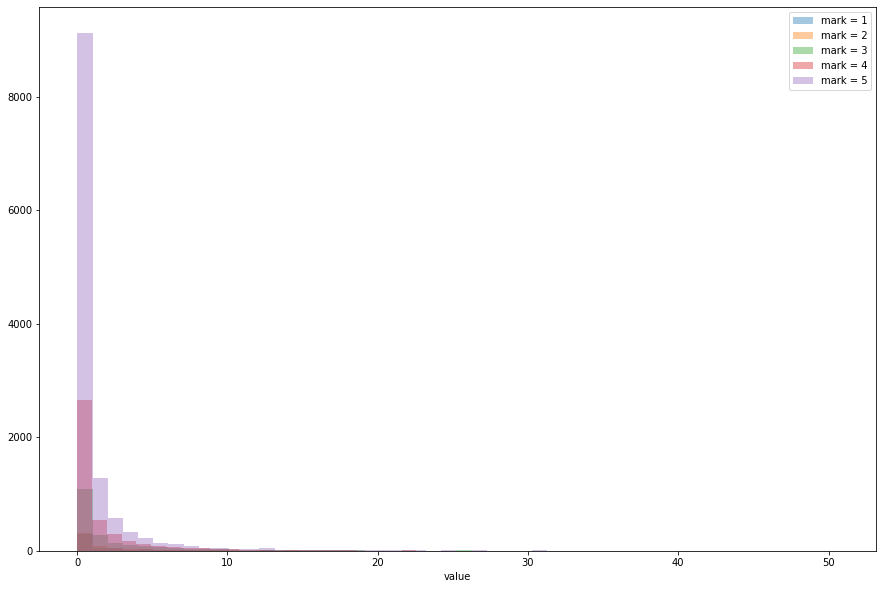

Гистограмма для учителей для inc_rtt_receiver_duration_share > 0


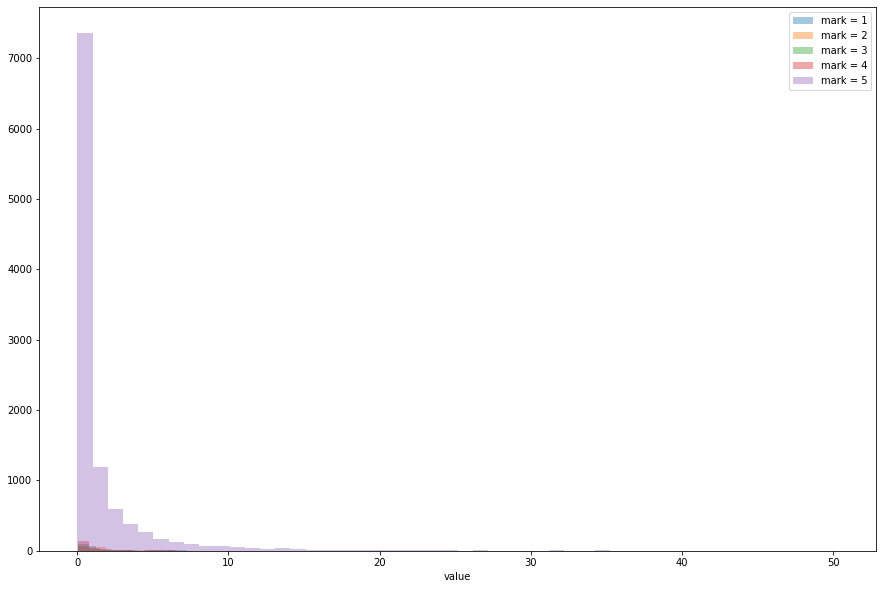



------------------------------ INC_RTT_SENDER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_rtt_sender_duration_share (доля времени, когда в отправляемом потоке был слишком большой пинг до сервера)


Изменение количества записей по времени для метрики inc_rtt_sender_duration_share (доля времени, когда в отправляемом потоке был слишком большой пинг до сервера)


boxplot для inc_rtt_sender_duration_share > 0


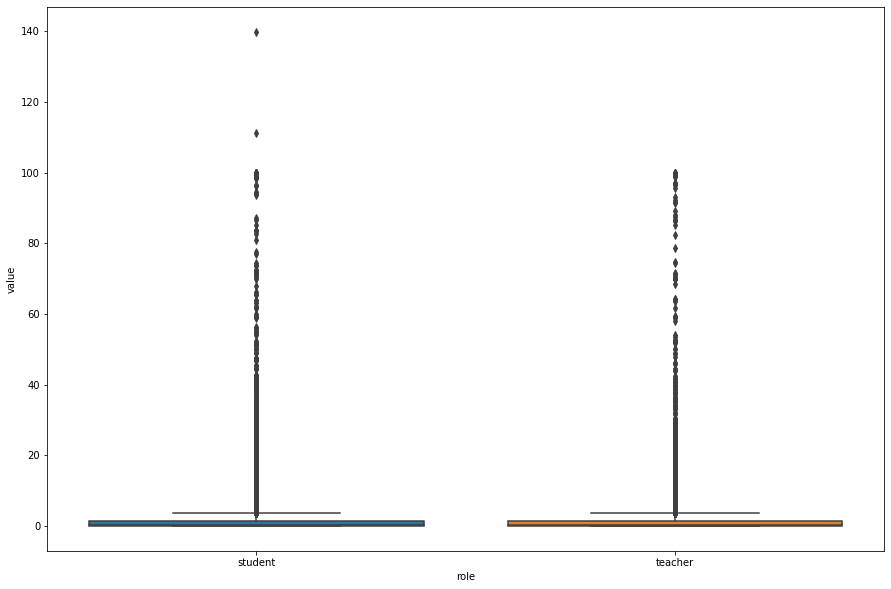

Границы для выбросов:
[0, 51.53694999999996]
boxplot после чистки выбросов для inc_rtt_sender_duration_share > 0


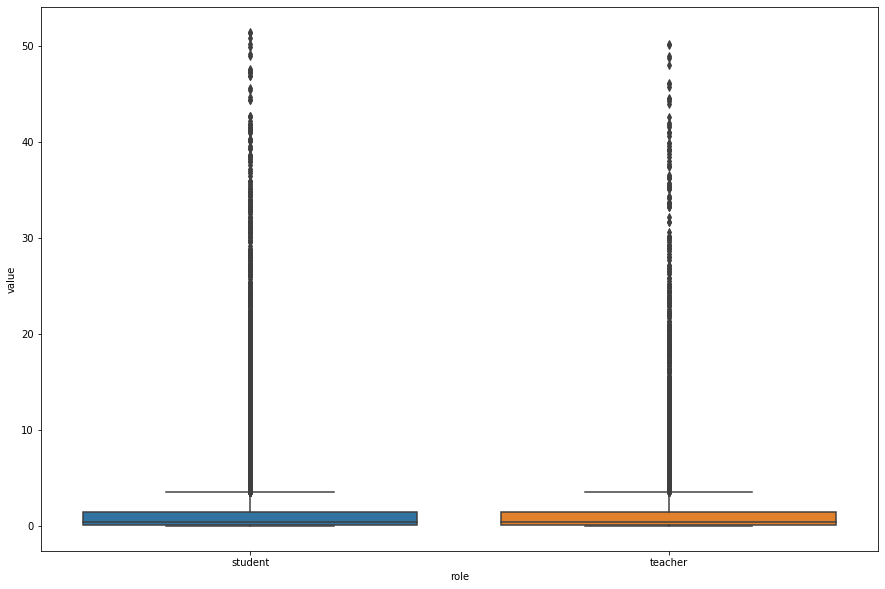

boxplot после чистки выбросов для студентов для inc_rtt_sender_duration_share > 0


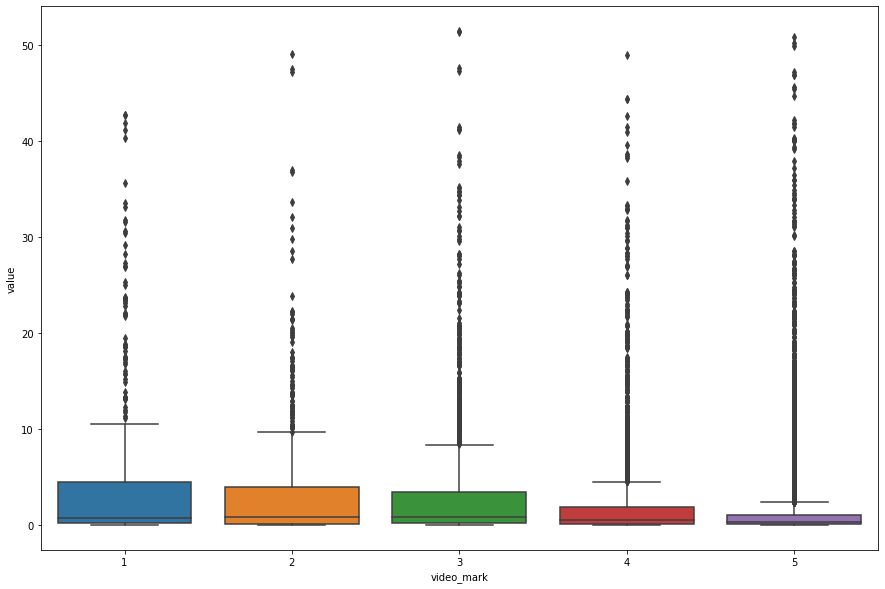

boxplot после чистки выбросов для учителей для inc_rtt_sender_duration_share > 0


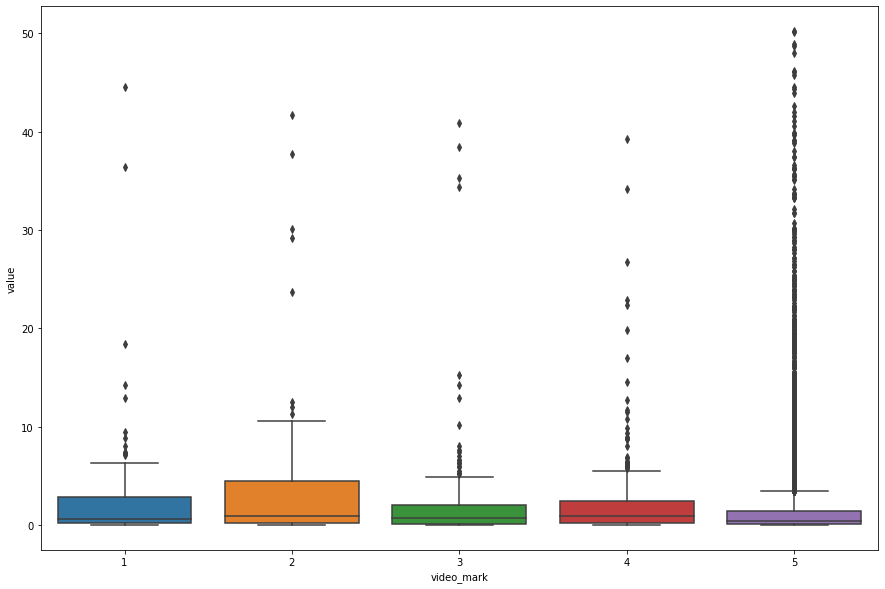

Гистограмма после чистки выбросов для inc_rtt_sender_duration_share > 0


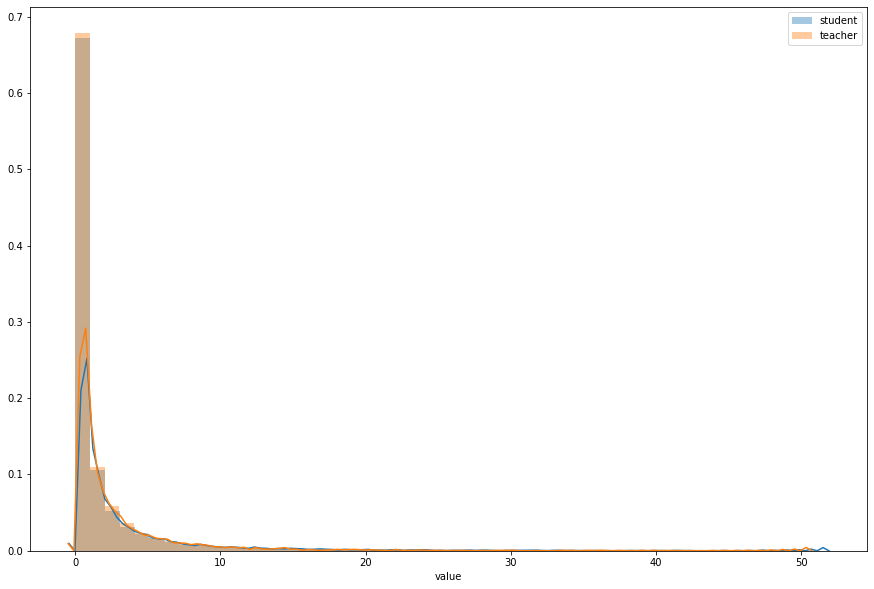

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_rtt_sender_duration_share > 0


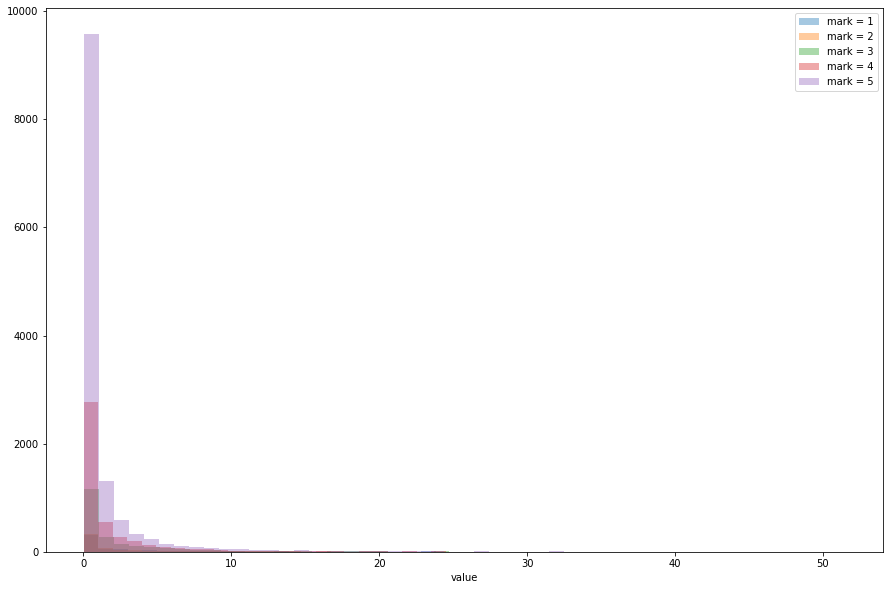

Гистограмма для учителей для inc_rtt_sender_duration_share > 0


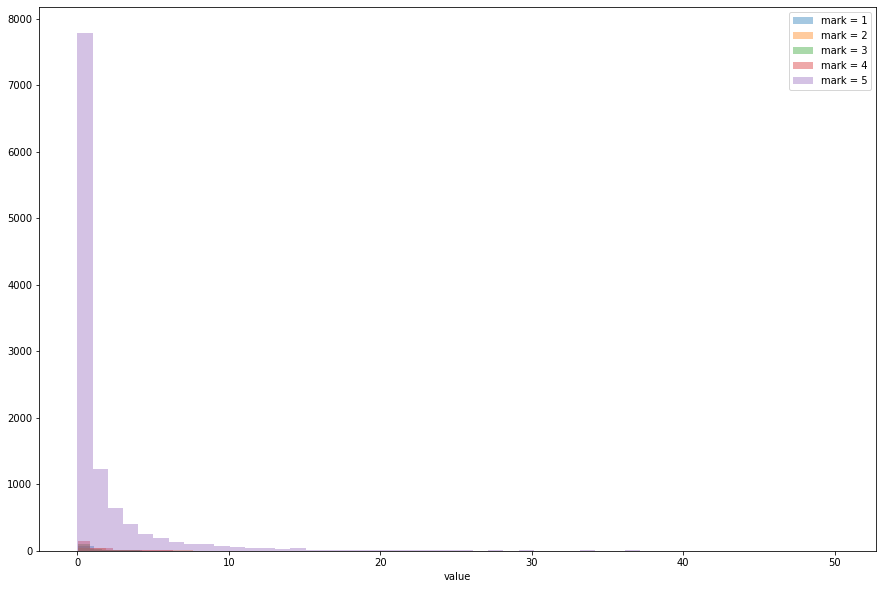



------------------------------ INC_VIDEO_BITRATE_10_RECEIVER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_video_bitrate_10_receiver_duration_share (доля времени, когда в принимаемом потоке был битрэйт ниже 10кбит)


Изменение количества записей по времени для метрики inc_video_bitrate_10_receiver_duration_share (доля времени, когда в принимаемом потоке был битрэйт ниже 10кбит)


boxplot для inc_video_bitrate_10_receiver_duration_share > 0


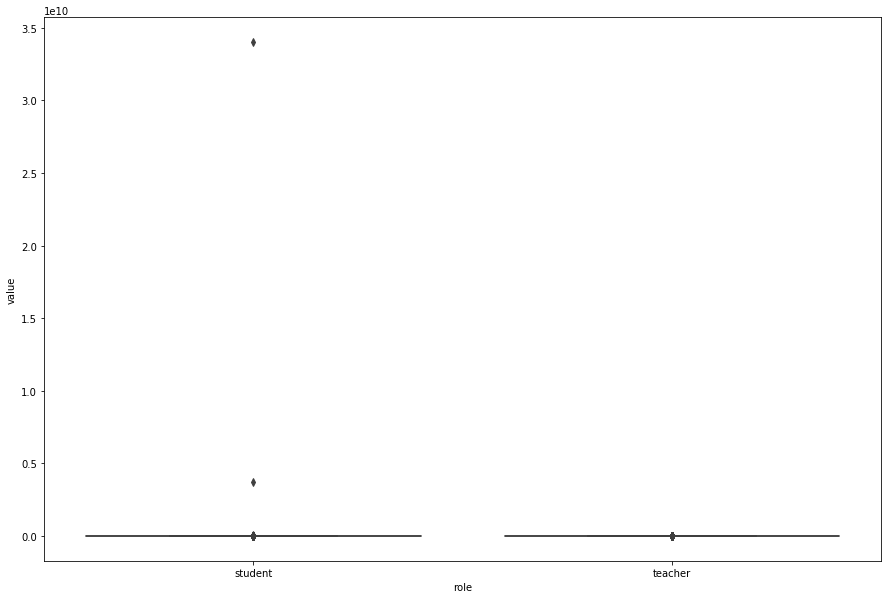

Границы для выбросов:
[0, 99.64]
boxplot после чистки выбросов для inc_video_bitrate_10_receiver_duration_share > 0


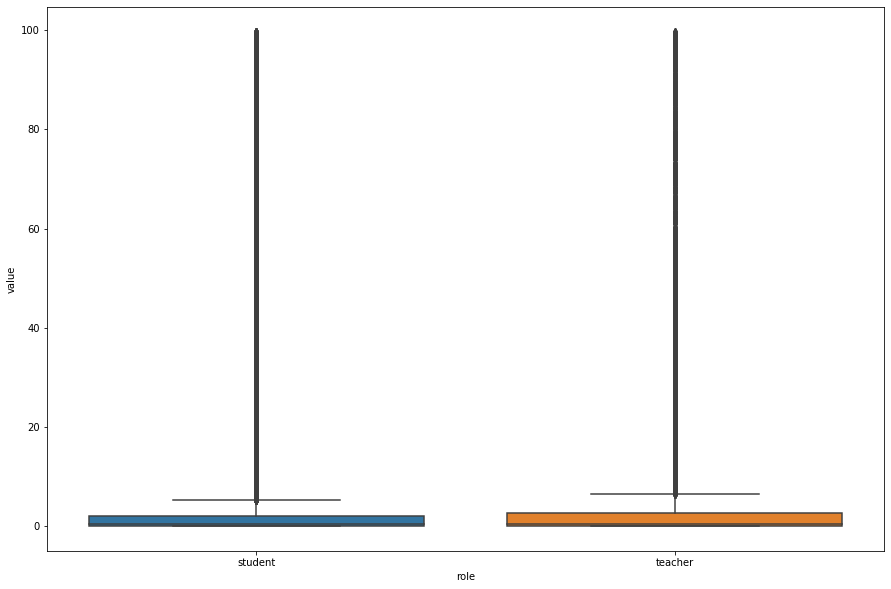

boxplot после чистки выбросов для студентов для inc_video_bitrate_10_receiver_duration_share > 0


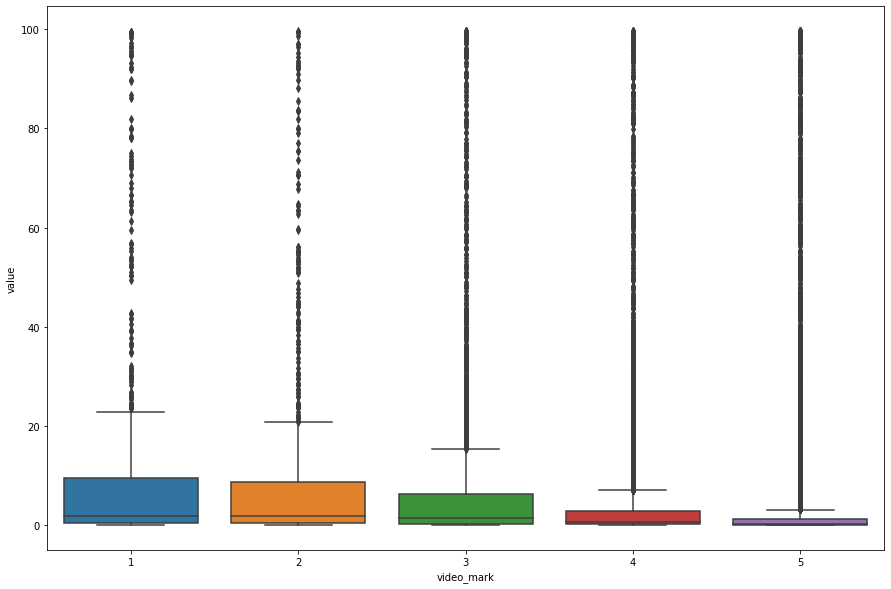

boxplot после чистки выбросов для учителей для inc_video_bitrate_10_receiver_duration_share > 0


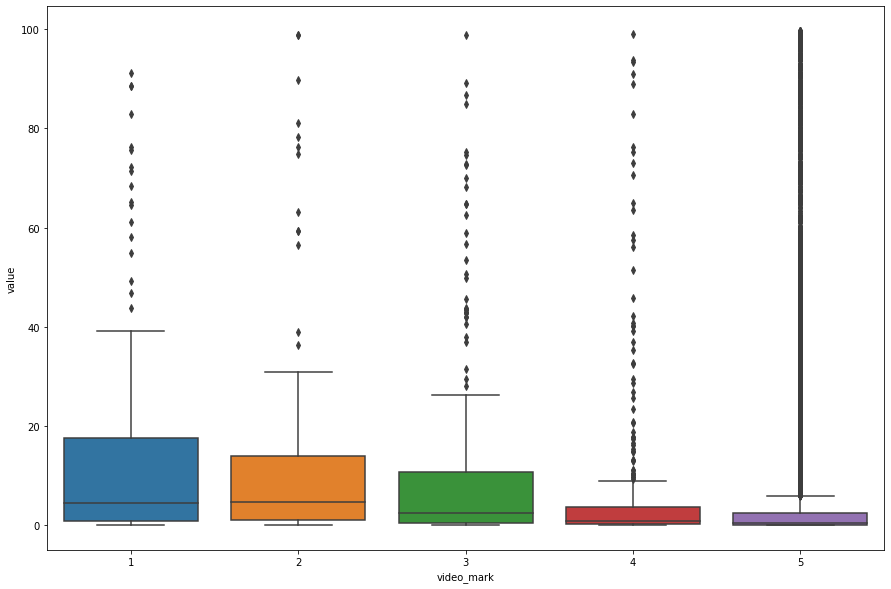

Гистограмма после чистки выбросов для inc_video_bitrate_10_receiver_duration_share > 0


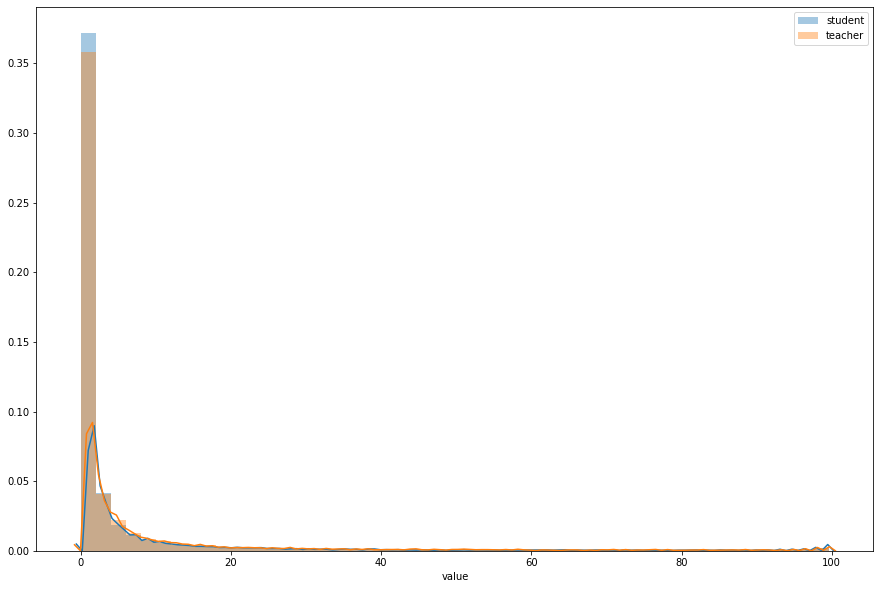

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_video_bitrate_10_receiver_duration_share > 0


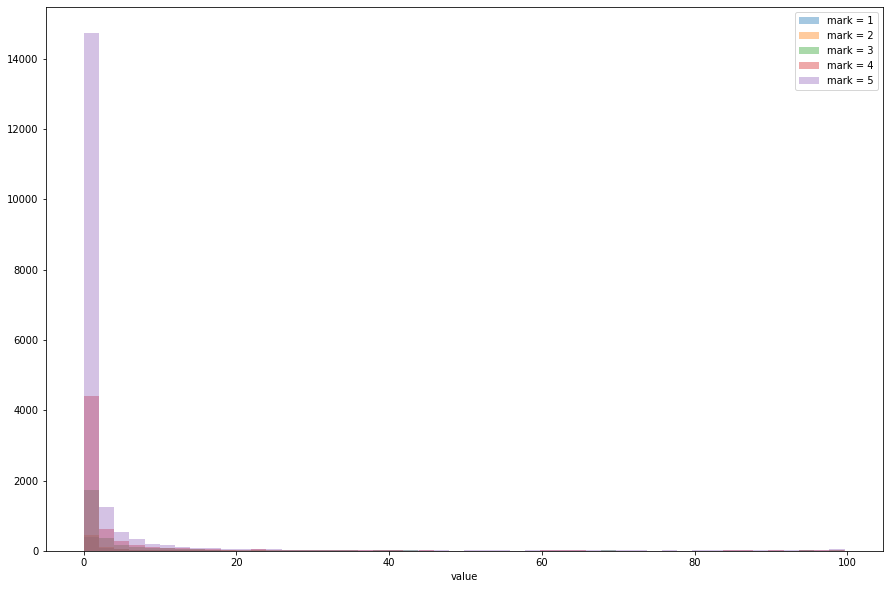

Гистограмма для учителей для inc_video_bitrate_10_receiver_duration_share > 0


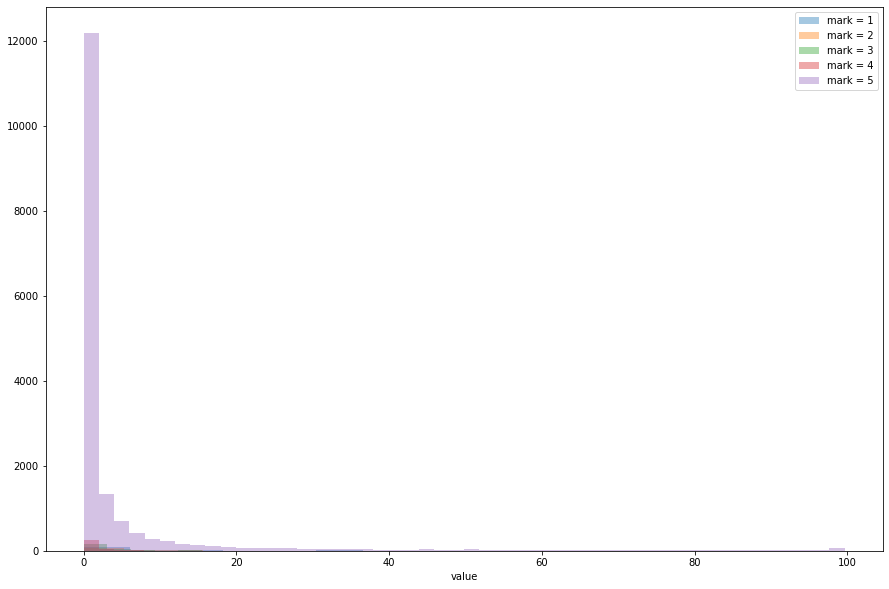



------------------------------ INC_VIDEO_BITRATE_25_RECEIVER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_video_bitrate_25_receiver_duration_share (доля времени, когда в принимаемом потоке был битрэйт ниже 25кбит)


Изменение количества записей по времени для метрики inc_video_bitrate_25_receiver_duration_share (доля времени, когда в принимаемом потоке был битрэйт ниже 25кбит)


boxplot для inc_video_bitrate_25_receiver_duration_share > 0


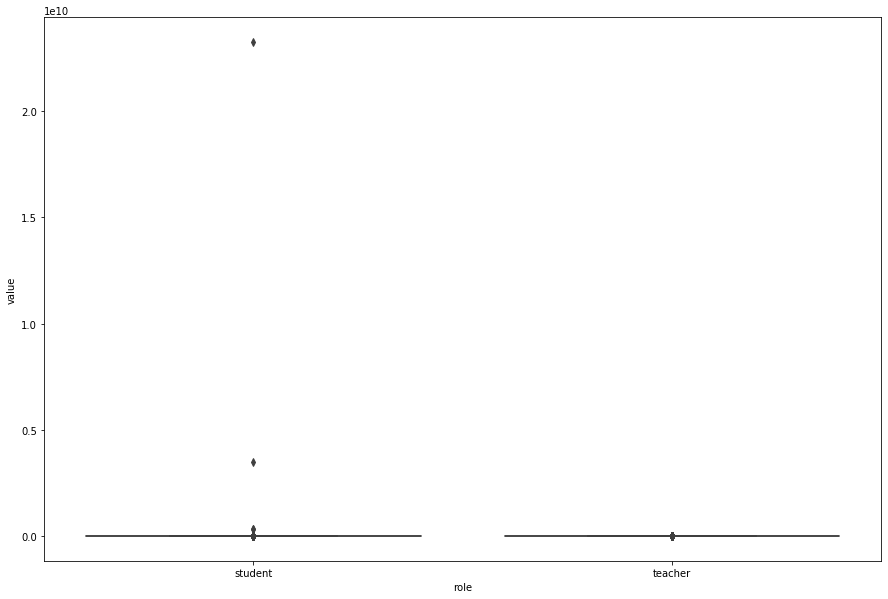

Границы для выбросов:
[0, 99.71464999999996]
boxplot после чистки выбросов для inc_video_bitrate_25_receiver_duration_share > 0


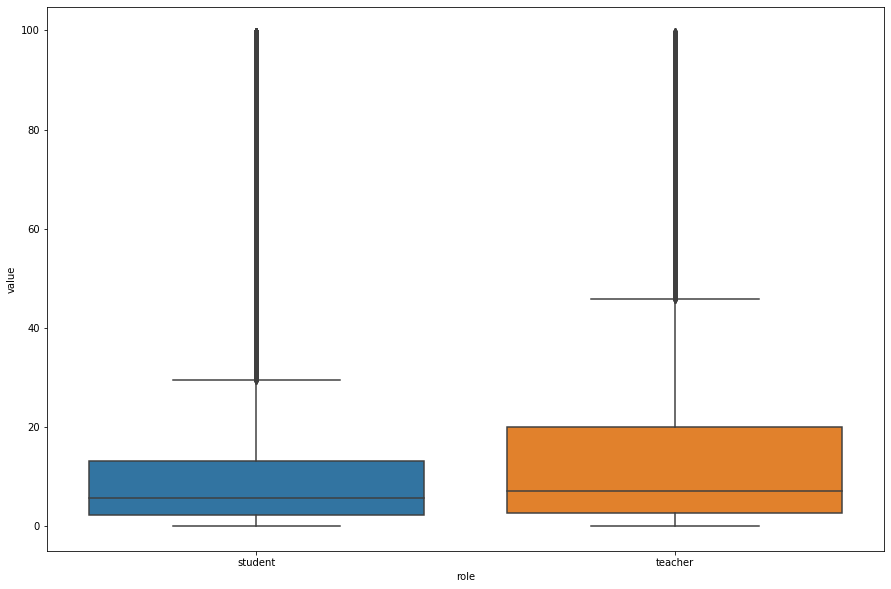

boxplot после чистки выбросов для студентов для inc_video_bitrate_25_receiver_duration_share > 0


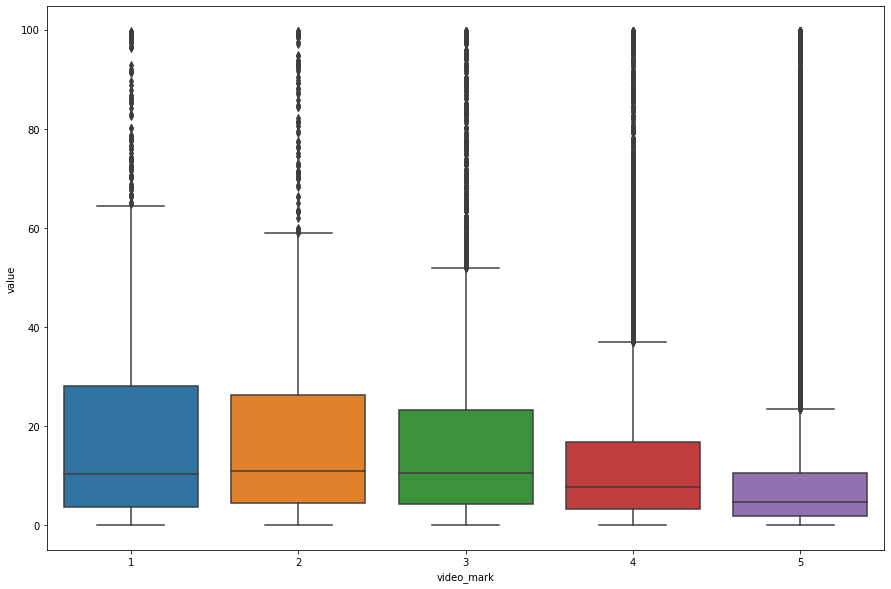

boxplot после чистки выбросов для учителей для inc_video_bitrate_25_receiver_duration_share > 0


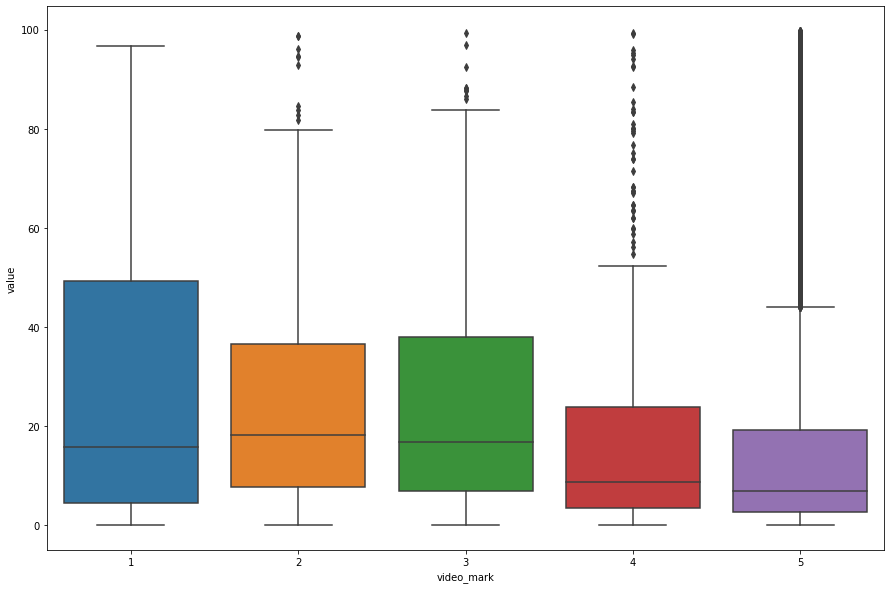

Гистограмма после чистки выбросов для inc_video_bitrate_25_receiver_duration_share > 0


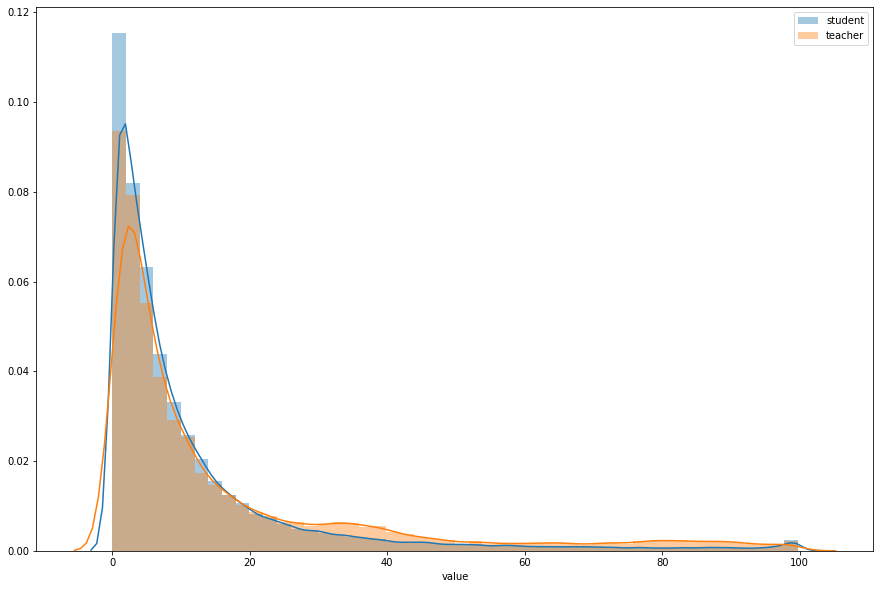

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_video_bitrate_25_receiver_duration_share > 0


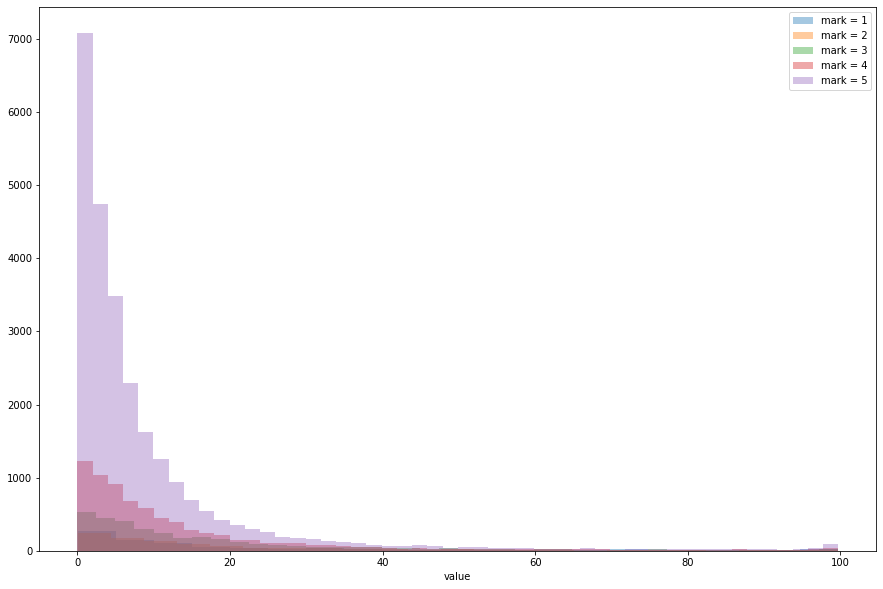

Гистограмма для учителей для inc_video_bitrate_25_receiver_duration_share > 0


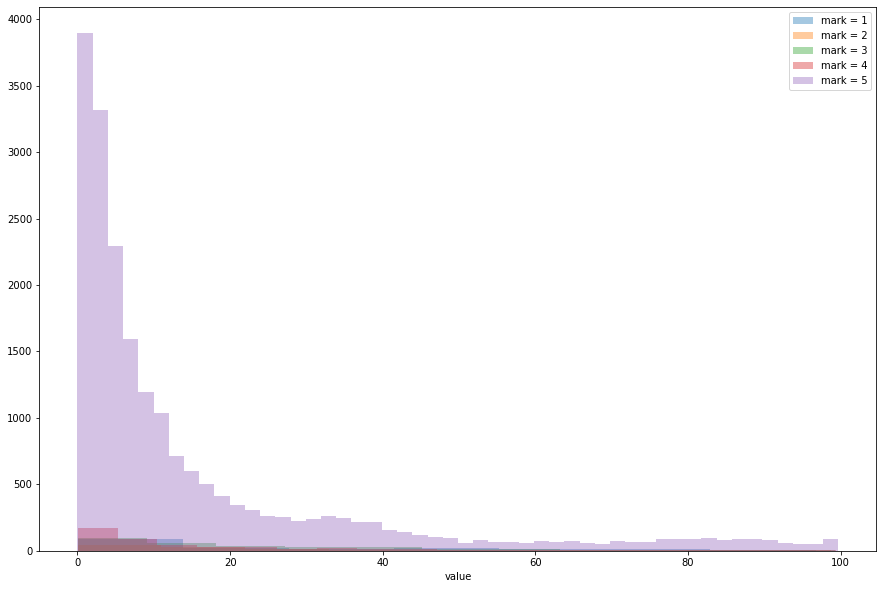



------------------------------ INC_VIDEO_BITRATE_6_SENDER_DURATION_SHARE -------------------------------
Изменение среднего по времени для метрики inc_video_bitrate_6_sender_duration_share (доля времени, когда в принимаемом потоке был битрэйт ниже 6кбит)


Изменение количества записей по времени для метрики inc_video_bitrate_6_sender_duration_share (доля времени, когда в принимаемом потоке был битрэйт ниже 6кбит)


boxplot для inc_video_bitrate_6_sender_duration_share > 0


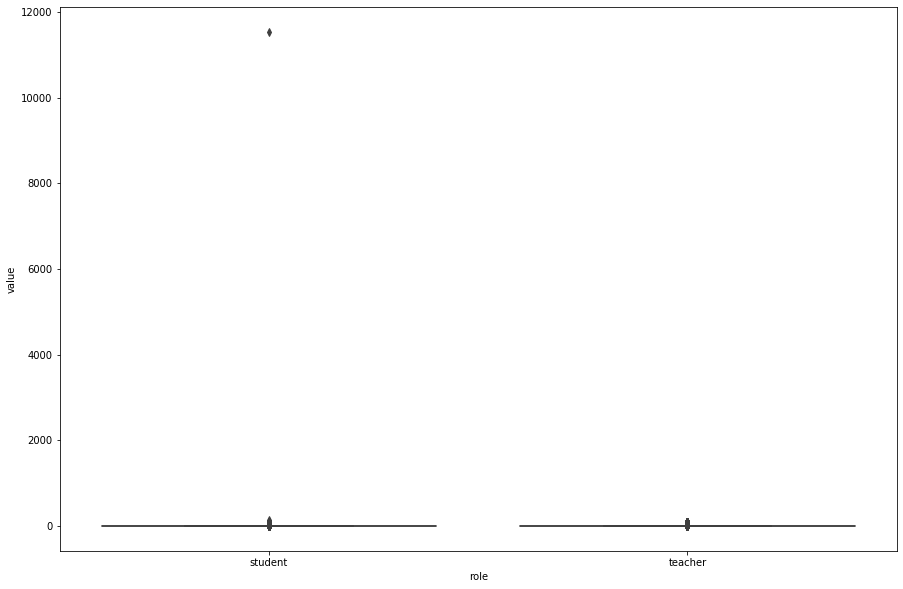

Границы для выбросов:
[0, 96.93805000000003]
boxplot после чистки выбросов для inc_video_bitrate_6_sender_duration_share > 0


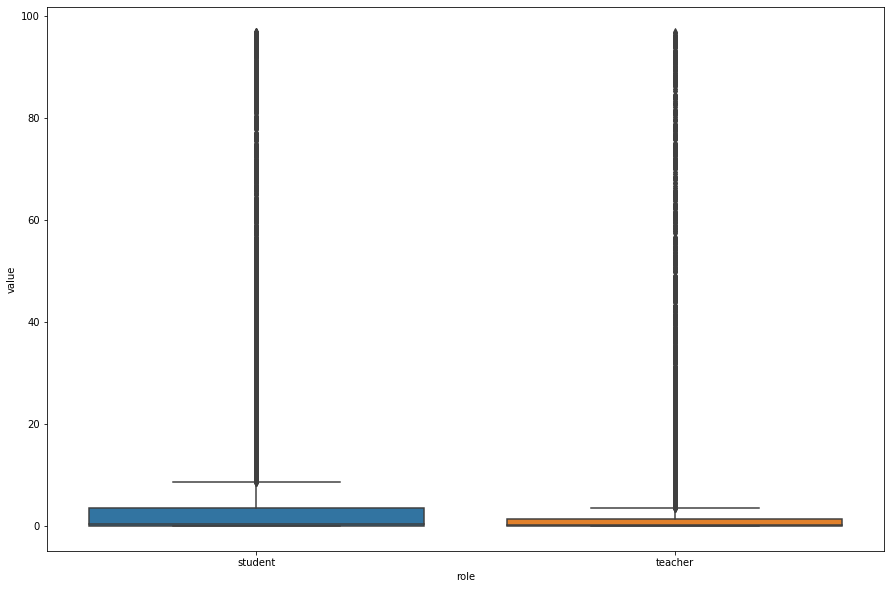

boxplot после чистки выбросов для студентов для inc_video_bitrate_6_sender_duration_share > 0


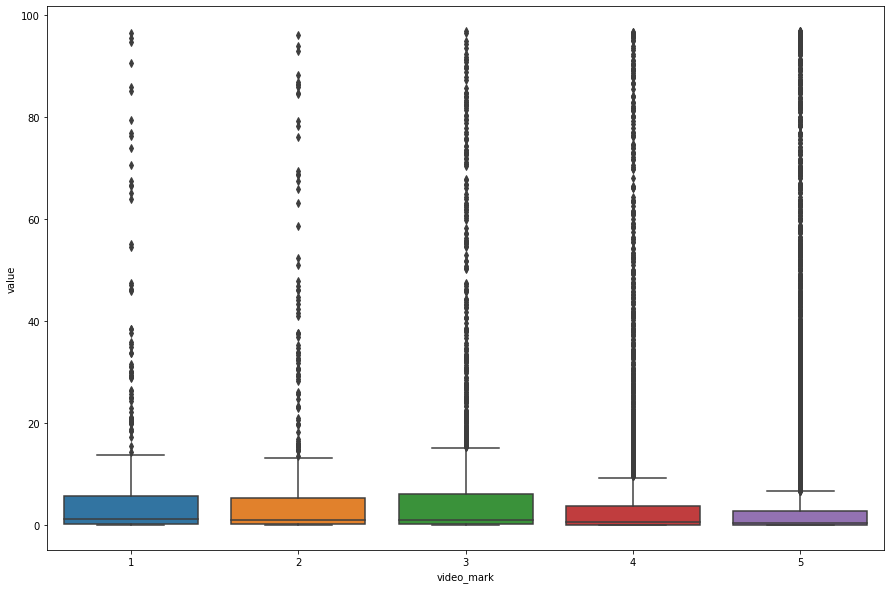

boxplot после чистки выбросов для учителей для inc_video_bitrate_6_sender_duration_share > 0


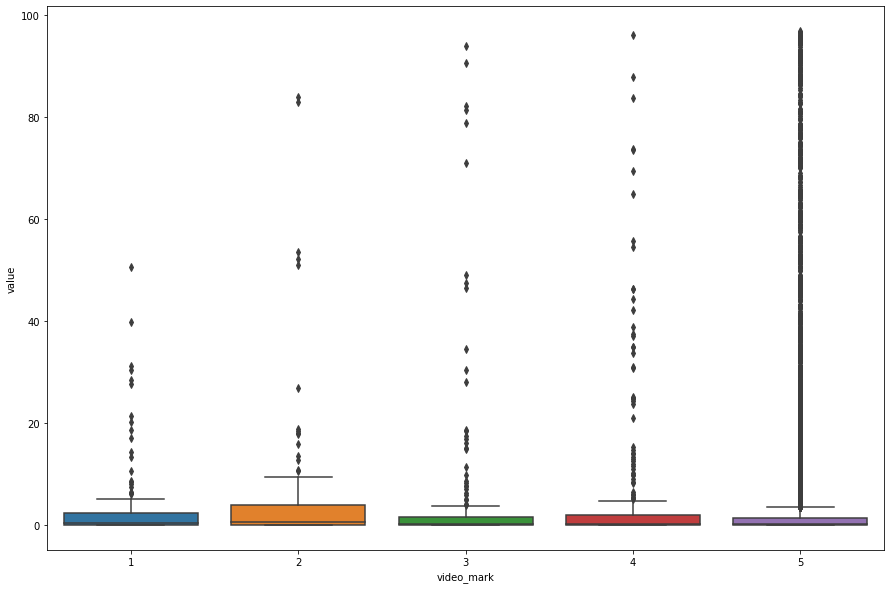

Гистограмма после чистки выбросов для inc_video_bitrate_6_sender_duration_share > 0


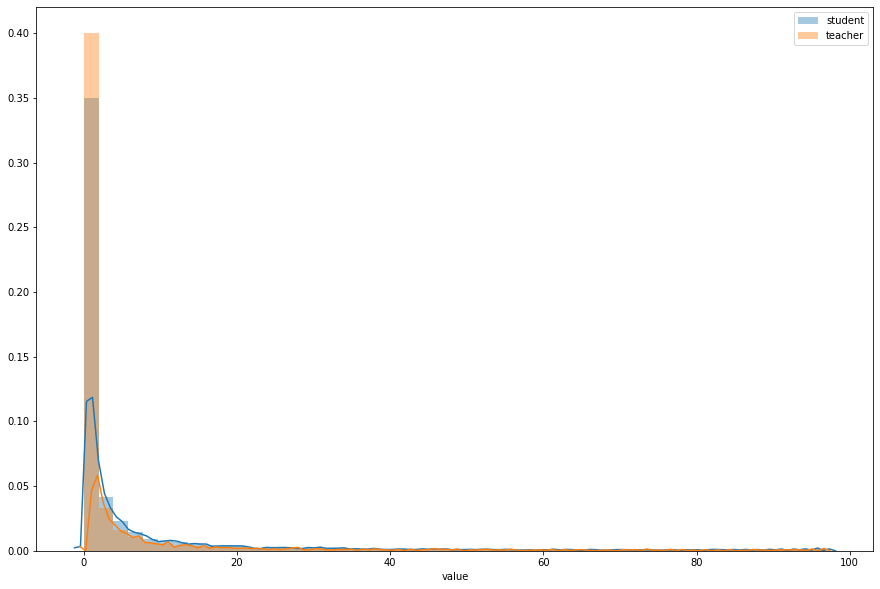

Изменение среднего по времени после чистки выбросов и учета только нужных периодов



Гистограмма для студентов для inc_video_bitrate_6_sender_duration_share > 0


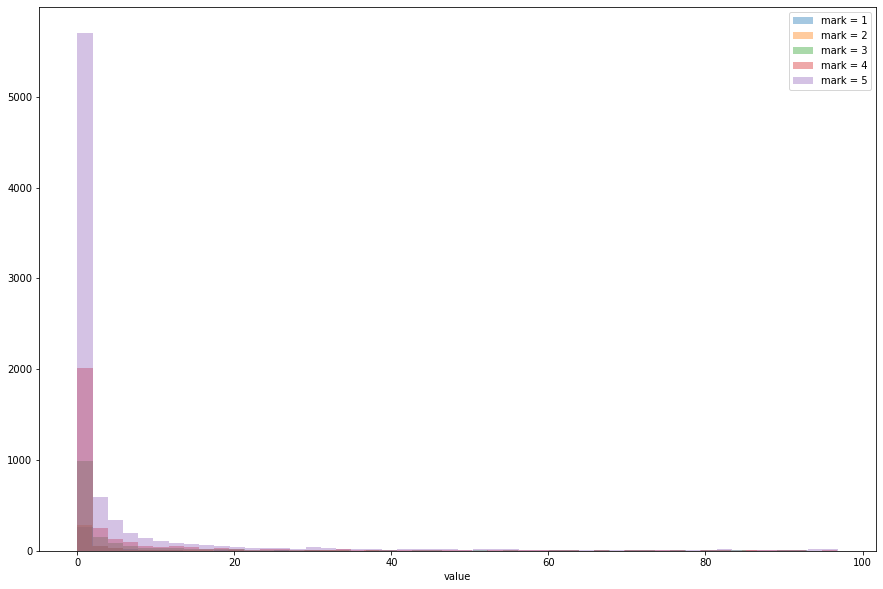

Гистограмма для учителей для inc_video_bitrate_6_sender_duration_share > 0


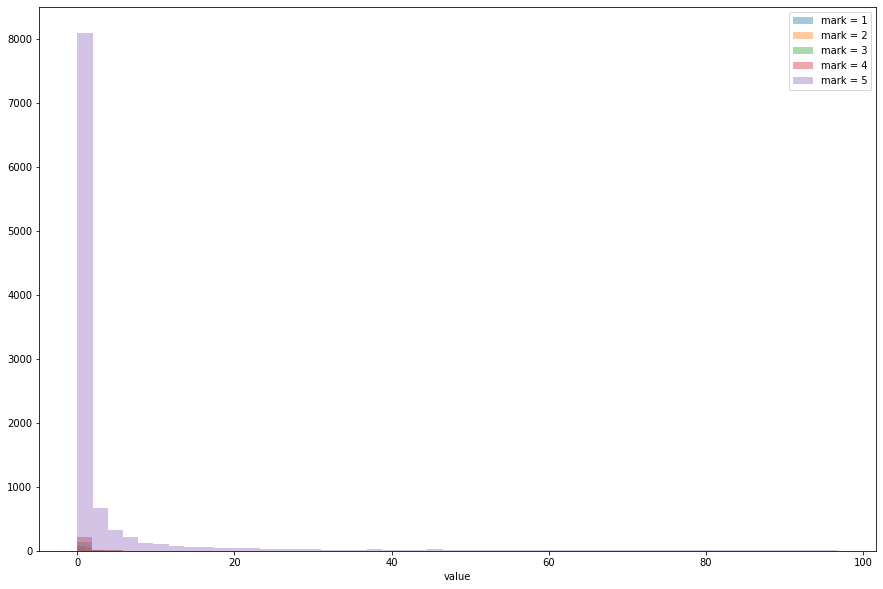

In [20]:
for metric in list(d.keys()):
    metric_analysis(metric, d)

# Model

In [5]:
q_b = '''
    SELECT
        video_mark.class_id,
        video_mark.total_tech_count_student,
        video_mark.total_tech_count_teacher,
        video_mark.video_mark
        
'''
        
q_e = '''
FROM 
( 
    SELECT DISTINCT
        st.class_id,
        st.video_mark,
        st.total_tech_count_student,
        t.total_tech_count_teacher 
    FROM
    (
        SELECT
            class_id,
            total_tech_count AS total_tech_count_student,
            video_mark
        FROM report.video_quality_metric_first_packet_dataset
        WHERE start_at > '2020-04-29' 
        AND rooms_count_in_room = 1
        AND role = 'student'
    ) AS st
    LEFT JOIN
    (
        SELECT
            class_id,
            total_tech_count AS total_tech_count_teacher
        FROM report.video_quality_metric_first_packet_dataset
        WHERE start_at > '2020-04-29' 
        AND rooms_count_in_room = 1
        AND role = 'teacher'
    ) AS t
    ON st.class_id = t.class_id
) AS video_mark
'''

for key in list(set(d.keys()) - set(['total_tech_count'])) :
    q = get_select_raw(key, d)
    q_b = '{0}, {1}.{1}_student'.format(q_b, key)
    q_b = '{0}, {1}.{1}_teacher'.format(q_b, key)
    q_b = '{0}, {1}.{1}_is_nan'.format(q_b, key)
    
    q_e = '{0} {1}'.format(q_e, q)
    
q = '''
{0} {1}
'''.format(q_b, q_e)

In [11]:
df_gr = get_data_new_query(q)

In [6]:
q

"\n\n    SELECT\n        video_mark.class_id,\n        video_mark.total_tech_count_student,\n        video_mark.total_tech_count_teacher,\n        video_mark.video_mark\n        \n, inc_qp_receiver_duration_share.inc_qp_receiver_duration_share_student, inc_qp_receiver_duration_share.inc_qp_receiver_duration_share_teacher, inc_qp_receiver_duration_share.inc_qp_receiver_duration_share_is_nan, video_state_down.video_state_down_student, video_state_down.video_state_down_teacher, video_state_down.video_state_down_is_nan, web_rtc_down_count.web_rtc_down_count_student, web_rtc_down_count.web_rtc_down_count_teacher, web_rtc_down_count.web_rtc_down_count_is_nan, inc_lag_audio_video_receiver_duration_share.inc_lag_audio_video_receiver_duration_share_student, inc_lag_audio_video_receiver_duration_share.inc_lag_audio_video_receiver_duration_share_teacher, inc_lag_audio_video_receiver_duration_share.inc_lag_audio_video_receiver_duration_share_is_nan, inc_resolution_receiver_duration_share.inc_resol

In [12]:
df_gr.shape

(99715, 46)

In [13]:
same_cols = []
for col in df_gr.columns:
    if (len(np.unique(df_gr[col].astype(str))) == 1):
        print(col)
        same_cols.append(col)

In [14]:
df_gr['total_tech_count_student'] = df_gr['total_tech_count_student'].fillna(0)
df_gr['total_tech_count_teacher'] = df_gr['total_tech_count_teacher'].fillna(0)
df_gr['total_tech_count_student'] = df_gr['total_tech_count_student'].astype(int)
df_gr['total_tech_count_teacher'] = df_gr['total_tech_count_teacher'].astype(int)
df_gr = df_gr.dropna()
df_gr['video_mark'] = df_gr['video_mark'].astype(int)

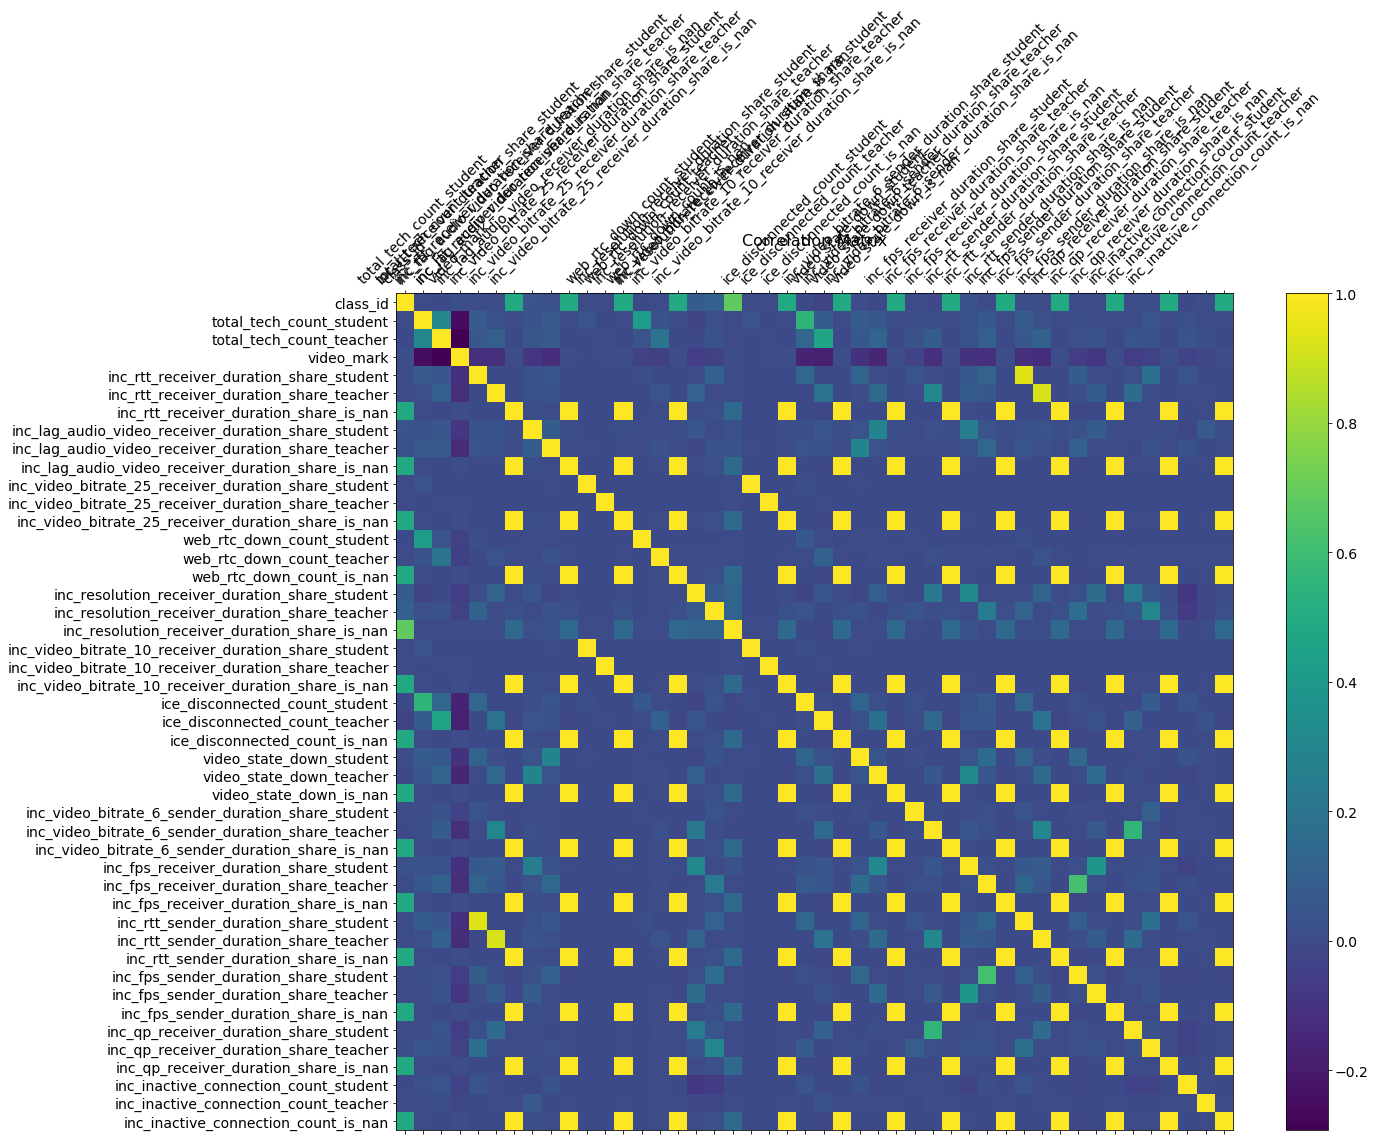

In [15]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_gr.corr(), fignum=f.number)
plt.xticks(range(df_gr.shape[1]), df_gr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_gr.shape[1]), df_gr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);